In [1]:
import os
import numpy as np
import scipy.io
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Paths
DATASET_PATH = "/kaggle/input/flowers"
LABELS_MAT = os.path.join(DATASET_PATH, "imagelabels.mat")
TGZ_FILE = os.path.join(DATASET_PATH, "102flowers.tgz")
EXTRACTED_IMG_DIR = "/kaggle/working/extracted_images"

# Extract images if not already done
if not os.path.exists(EXTRACTED_IMG_DIR):
    os.makedirs(EXTRACTED_IMG_DIR, exist_ok=True)
    with tarfile.open(TGZ_FILE, "r:gz") as tar:
        for member in tar.getmembers():
            if member.name.endswith(('.jpg', '.png', '.jpeg')): 
                member.name = os.path.basename(member.name)
                tar.extract(member, EXTRACTED_IMG_DIR)

# Load labels
labels_mat = scipy.io.loadmat(LABELS_MAT)
labels = labels_mat["labels"].flatten() - 1  # Convert 1-based to 0-based indexing

# Load and preprocess images
IMG_SIZE = (224, 224)  # For VGG19
image_files = sorted([f for f in os.listdir(EXTRACTED_IMG_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))])

X = []
for img_file in image_files:
    img_path = os.path.join(EXTRACTED_IMG_DIR, img_file)
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0  # Normalize
    X.append(img_array)

X = np.array(X)
y = np.array(labels)

# Convert labels to categorical (for softmax output)
num_classes = len(np.unique(y))
y = to_categorical(y, num_classes)

print(f"Total samples: {len(X)}, Classes: {num_classes}")


Total samples: 8189, Classes: 102


In [ ]:
# Define function for dataset split
def split_data(X, y, seed=None):
    # First split: Train (50%) and Temp (50%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=seed)
    
    # Second split: Validation (25%) and Test (25%) from Temp
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Perform split twice with different random seeds
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1 = split_data(X, y, seed=42)
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = split_data(X, y, seed=99)

print(f"Split 1 - Train: {len(X_train1)}, Val: {len(X_val1)}, Test: {len(X_test1)}")
print(f"Split 2 - Train: {len(X_train2)}, Val: {len(X_val2)}, Test: {len(X_test2)}")


In [14]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Load Pre-trained VGG19
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers

# Add new classifier on top
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x) 
x = Dropout(0.5)(x)
x = Dense(num_classes, activation="softmax")(x)  # Multi-class classification

# Create the model
vgg19_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train using first split
history_vgg19 = vgg19_model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=30, batch_size=32)

# Save the model
vgg19_model.save("/kaggle/working/vgg19_flower_classifier.h5")


Epoch 1/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.0359 - loss: 4.5822 - val_accuracy: 0.1500 - val_loss: 4.0870
Epoch 2/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.1439 - loss: 3.9611 - val_accuracy: 0.2702 - val_loss: 3.6146
Epoch 3/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.2222 - loss: 3.4972 - val_accuracy: 0.3498 - val_loss: 3.2560
Epoch 4/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.2920 - loss: 3.1035 - val_accuracy: 0.4055 - val_loss: 2.9805
Epoch 5/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.3759 - loss: 2.7858 - val_accuracy: 0.4587 - val_loss: 2.7183
Epoch 6/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.4368 - loss: 2.4685 - val_accuracy: 0.4900 - val_loss: 2.5294
Epoch 7/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.4637 - loss: 2.2800 - val_accuracy: 0.5467 - val_loss: 2.3513
Epoch 8/30
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.5184 - loss: 2

In [34]:
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib numpy


In [ ]:
import torch
import torch.nn as nn
import cv2
import numpy as np


# Load the YOLOv5 model
base_model = torch.hub.load('ultralytics/yolov5', 'yolov5n', pretrained=True)
#base_model.eval()  # Set model to evaluation mode

def preprocess_image(img):
    """
    Resizes an image to 640x640 and converts it to a PyTorch tensor.
    """
    img_resized = cv2.resize(img, (640, 640))  # Resize image
    img_resized = img_resized / 255.0  # Normalize to [0,1]
    img_resized = np.transpose(img_resized, (2, 0, 1))  # Change to (C, H, W)
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return img_tensor

def pool_output(output, reduction_factor=100):
    """
    Applies Adaptive Average Pooling to reduce YOLO output size.
    Reduces detections from (1, 25200, 85) → (1, 252, 85)
    """
    batch, num_boxes, num_features = output.shape  # Shape: (1, 25200, 85)
    target_size = 1 

    # Apply Adaptive Average Pooling on the detection dimension (25200 → 252)
    pooled_output = torch.nn.functional.adaptive_avg_pool1d(output.squeeze(0).T, target_size).T.unsqueeze(0)

    return pooled_output  # Shape: (1, 252, 85)

# Run YOLO on images with pooling
pooled_features = []
counter = 0
for img in X:
    img_tensor = preprocess_image(img)
    with torch.no_grad():
        output = base_model(img_tensor) # Extract raw prediction (1, 25200, 85)

    pooled_output = pool_output(output)  # Reduce size
    pooled_features.append(pooled_output.cpu().numpy())  # Convert to NumPy for storage
    print(pooled_output.shape)
    print(counter)
    counter +=1

# `pooled_features` contains the reduced output (100x smaller)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-1-29 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/m

torch.Size([1, 1, 85])
0
torch.Size([1, 1, 85])
1
torch.Size([1, 1, 85])
2
torch.Size([1, 1, 85])
3
torch.Size([1, 1, 85])
4
torch.Size([1, 1, 85])
5
torch.Size([1, 1, 85])
6
torch.Size([1, 1, 85])
7
torch.Size([1, 1, 85])
8
torch.Size([1, 1, 85])
9
torch.Size([1, 1, 85])
10
torch.Size([1, 1, 85])
11
torch.Size([1, 1, 85])
12
torch.Size([1, 1, 85])
13
torch.Size([1, 1, 85])
14
torch.Size([1, 1, 85])
15
torch.Size([1, 1, 85])
16
torch.Size([1, 1, 85])
17
torch.Size([1, 1, 85])
18
torch.Size([1, 1, 85])
19
torch.Size([1, 1, 85])
20


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
21
torch.Size([1, 1, 85])
22
torch.Size([1, 1, 85])
23
torch.Size([1, 1, 85])
24
torch.Size([1, 1, 85])
25
torch.Size([1, 1, 85])
26
torch.Size([1, 1, 85])
27
torch.Size([1, 1, 85])
28
torch.Size([1, 1, 85])
29
torch.Size([1, 1, 85])
30
torch.Size([1, 1, 85])
31
torch.Size([1, 1, 85])
32
torch.Size([1, 1, 85])
33
torch.Size([1, 1, 85])
34
torch.Size([1, 1, 85])
35
torch.Size([1, 1, 85])
36
torch.Size([1, 1, 85])
37
torch.Size([1, 1, 85])
38
torch.Size([1, 1, 85])
39
torch.Size([1, 1, 85])
40


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
41
torch.Size([1, 1, 85])
42
torch.Size([1, 1, 85])
43
torch.Size([1, 1, 85])
44
torch.Size([1, 1, 85])
45
torch.Size([1, 1, 85])
46
torch.Size([1, 1, 85])
47
torch.Size([1, 1, 85])
48
torch.Size([1, 1, 85])
49
torch.Size([1, 1, 85])
50
torch.Size([1, 1, 85])
51
torch.Size([1, 1, 85])
52
torch.Size([1, 1, 85])
53
torch.Size([1, 1, 85])
54
torch.Size([1, 1, 85])
55
torch.Size([1, 1, 85])
56
torch.Size([1, 1, 85])
57
torch.Size([1, 1, 85])
58
torch.Size([1, 1, 85])
59
torch.Size([1, 1, 85])
60


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
61
torch.Size([1, 1, 85])
62
torch.Size([1, 1, 85])
63
torch.Size([1, 1, 85])
64
torch.Size([1, 1, 85])
65
torch.Size([1, 1, 85])
66
torch.Size([1, 1, 85])
67
torch.Size([1, 1, 85])
68
torch.Size([1, 1, 85])
69
torch.Size([1, 1, 85])
70
torch.Size([1, 1, 85])
71
torch.Size([1, 1, 85])
72
torch.Size([1, 1, 85])
73
torch.Size([1, 1, 85])
74
torch.Size([1, 1, 85])
75
torch.Size([1, 1, 85])
76
torch.Size([1, 1, 85])
77
torch.Size([1, 1, 85])
78
torch.Size([1, 1, 85])
79
torch.Size([1, 1, 85])
80
torch.Size([1, 1, 85])
81


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
82
torch.Size([1, 1, 85])
83
torch.Size([1, 1, 85])
84
torch.Size([1, 1, 85])
85
torch.Size([1, 1, 85])
86
torch.Size([1, 1, 85])
87
torch.Size([1, 1, 85])
88
torch.Size([1, 1, 85])
89
torch.Size([1, 1, 85])
90
torch.Size([1, 1, 85])
91
torch.Size([1, 1, 85])
92
torch.Size([1, 1, 85])
93
torch.Size([1, 1, 85])
94
torch.Size([1, 1, 85])
95
torch.Size([1, 1, 85])
96
torch.Size([1, 1, 85])
97
torch.Size([1, 1, 85])
98
torch.Size([1, 1, 85])
99
torch.Size([1, 1, 85])
100
torch.Size([1, 1, 85])
101
torch.Size([1, 1, 85])
102


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
103
torch.Size([1, 1, 85])
104
torch.Size([1, 1, 85])
105
torch.Size([1, 1, 85])
106
torch.Size([1, 1, 85])
107
torch.Size([1, 1, 85])
108
torch.Size([1, 1, 85])
109
torch.Size([1, 1, 85])
110
torch.Size([1, 1, 85])
111
torch.Size([1, 1, 85])
112
torch.Size([1, 1, 85])
113
torch.Size([1, 1, 85])
114
torch.Size([1, 1, 85])
115
torch.Size([1, 1, 85])
116
torch.Size([1, 1, 85])
117
torch.Size([1, 1, 85])
118
torch.Size([1, 1, 85])
119
torch.Size([1, 1, 85])
120
torch.Size([1, 1, 85])
121
torch.Size([1, 1, 85])
122
torch.Size([1, 1, 85])
123


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
124
torch.Size([1, 1, 85])
125
torch.Size([1, 1, 85])
126
torch.Size([1, 1, 85])
127
torch.Size([1, 1, 85])
128
torch.Size([1, 1, 85])
129
torch.Size([1, 1, 85])
130
torch.Size([1, 1, 85])
131
torch.Size([1, 1, 85])
132
torch.Size([1, 1, 85])
133
torch.Size([1, 1, 85])
134
torch.Size([1, 1, 85])
135
torch.Size([1, 1, 85])
136
torch.Size([1, 1, 85])
137
torch.Size([1, 1, 85])
138
torch.Size([1, 1, 85])
139
torch.Size([1, 1, 85])
140
torch.Size([1, 1, 85])
141
torch.Size([1, 1, 85])
142
torch.Size([1, 1, 85])
143
torch.Size([1, 1, 85])
144


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
145
torch.Size([1, 1, 85])
146
torch.Size([1, 1, 85])
147
torch.Size([1, 1, 85])
148
torch.Size([1, 1, 85])
149
torch.Size([1, 1, 85])
150
torch.Size([1, 1, 85])
151
torch.Size([1, 1, 85])
152
torch.Size([1, 1, 85])
153
torch.Size([1, 1, 85])
154
torch.Size([1, 1, 85])
155
torch.Size([1, 1, 85])
156
torch.Size([1, 1, 85])
157
torch.Size([1, 1, 85])
158
torch.Size([1, 1, 85])
159
torch.Size([1, 1, 85])
160
torch.Size([1, 1, 85])
161
torch.Size([1, 1, 85])
162
torch.Size([1, 1, 85])
163
torch.Size([1, 1, 85])
164
torch.Size([1, 1, 85])
165


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
166
torch.Size([1, 1, 85])
167
torch.Size([1, 1, 85])
168
torch.Size([1, 1, 85])
169
torch.Size([1, 1, 85])
170
torch.Size([1, 1, 85])
171
torch.Size([1, 1, 85])
172
torch.Size([1, 1, 85])
173
torch.Size([1, 1, 85])
174
torch.Size([1, 1, 85])
175
torch.Size([1, 1, 85])
176
torch.Size([1, 1, 85])
177
torch.Size([1, 1, 85])
178
torch.Size([1, 1, 85])
179
torch.Size([1, 1, 85])
180
torch.Size([1, 1, 85])
181
torch.Size([1, 1, 85])
182
torch.Size([1, 1, 85])
183
torch.Size([1, 1, 85])
184
torch.Size([1, 1, 85])
185


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
186
torch.Size([1, 1, 85])
187
torch.Size([1, 1, 85])
188
torch.Size([1, 1, 85])
189
torch.Size([1, 1, 85])
190
torch.Size([1, 1, 85])
191
torch.Size([1, 1, 85])
192
torch.Size([1, 1, 85])
193
torch.Size([1, 1, 85])
194
torch.Size([1, 1, 85])
195
torch.Size([1, 1, 85])
196
torch.Size([1, 1, 85])
197
torch.Size([1, 1, 85])
198
torch.Size([1, 1, 85])
199
torch.Size([1, 1, 85])
200
torch.Size([1, 1, 85])
201
torch.Size([1, 1, 85])
202
torch.Size([1, 1, 85])
203
torch.Size([1, 1, 85])
204
torch.Size([1, 1, 85])
205
torch.Size([1, 1, 85])
206


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
207
torch.Size([1, 1, 85])
208
torch.Size([1, 1, 85])
209
torch.Size([1, 1, 85])
210
torch.Size([1, 1, 85])
211
torch.Size([1, 1, 85])
212
torch.Size([1, 1, 85])
213
torch.Size([1, 1, 85])
214
torch.Size([1, 1, 85])
215
torch.Size([1, 1, 85])
216
torch.Size([1, 1, 85])
217
torch.Size([1, 1, 85])
218
torch.Size([1, 1, 85])
219
torch.Size([1, 1, 85])
220
torch.Size([1, 1, 85])
221
torch.Size([1, 1, 85])
222
torch.Size([1, 1, 85])
223
torch.Size([1, 1, 85])
224
torch.Size([1, 1, 85])
225
torch.Size([1, 1, 85])
226
torch.Size([1, 1, 85])
227


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
228
torch.Size([1, 1, 85])
229
torch.Size([1, 1, 85])
230
torch.Size([1, 1, 85])
231
torch.Size([1, 1, 85])
232
torch.Size([1, 1, 85])
233
torch.Size([1, 1, 85])
234
torch.Size([1, 1, 85])
235
torch.Size([1, 1, 85])
236
torch.Size([1, 1, 85])
237
torch.Size([1, 1, 85])
238
torch.Size([1, 1, 85])
239
torch.Size([1, 1, 85])
240
torch.Size([1, 1, 85])
241
torch.Size([1, 1, 85])
242
torch.Size([1, 1, 85])
243
torch.Size([1, 1, 85])
244
torch.Size([1, 1, 85])
245
torch.Size([1, 1, 85])
246
torch.Size([1, 1, 85])
247
torch.Size([1, 1, 85])
248


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
249
torch.Size([1, 1, 85])
250
torch.Size([1, 1, 85])
251
torch.Size([1, 1, 85])
252
torch.Size([1, 1, 85])
253
torch.Size([1, 1, 85])
254
torch.Size([1, 1, 85])
255
torch.Size([1, 1, 85])
256
torch.Size([1, 1, 85])
257
torch.Size([1, 1, 85])
258
torch.Size([1, 1, 85])
259
torch.Size([1, 1, 85])
260
torch.Size([1, 1, 85])
261
torch.Size([1, 1, 85])
262
torch.Size([1, 1, 85])
263
torch.Size([1, 1, 85])
264
torch.Size([1, 1, 85])
265
torch.Size([1, 1, 85])
266
torch.Size([1, 1, 85])
267
torch.Size([1, 1, 85])
268
torch.Size([1, 1, 85])
269


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
270
torch.Size([1, 1, 85])
271
torch.Size([1, 1, 85])
272
torch.Size([1, 1, 85])
273
torch.Size([1, 1, 85])
274
torch.Size([1, 1, 85])
275
torch.Size([1, 1, 85])
276
torch.Size([1, 1, 85])
277
torch.Size([1, 1, 85])
278
torch.Size([1, 1, 85])
279
torch.Size([1, 1, 85])
280
torch.Size([1, 1, 85])
281
torch.Size([1, 1, 85])
282
torch.Size([1, 1, 85])
283
torch.Size([1, 1, 85])
284
torch.Size([1, 1, 85])
285
torch.Size([1, 1, 85])
286
torch.Size([1, 1, 85])
287
torch.Size([1, 1, 85])
288
torch.Size([1, 1, 85])
289


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
290
torch.Size([1, 1, 85])
291
torch.Size([1, 1, 85])
292
torch.Size([1, 1, 85])
293
torch.Size([1, 1, 85])
294
torch.Size([1, 1, 85])
295
torch.Size([1, 1, 85])
296
torch.Size([1, 1, 85])
297
torch.Size([1, 1, 85])
298
torch.Size([1, 1, 85])
299
torch.Size([1, 1, 85])
300
torch.Size([1, 1, 85])
301
torch.Size([1, 1, 85])
302
torch.Size([1, 1, 85])
303
torch.Size([1, 1, 85])
304
torch.Size([1, 1, 85])
305
torch.Size([1, 1, 85])
306
torch.Size([1, 1, 85])
307
torch.Size([1, 1, 85])
308
torch.Size([1, 1, 85])
309


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
310
torch.Size([1, 1, 85])
311
torch.Size([1, 1, 85])
312
torch.Size([1, 1, 85])
313
torch.Size([1, 1, 85])
314
torch.Size([1, 1, 85])
315
torch.Size([1, 1, 85])
316
torch.Size([1, 1, 85])
317
torch.Size([1, 1, 85])
318
torch.Size([1, 1, 85])
319
torch.Size([1, 1, 85])
320
torch.Size([1, 1, 85])
321
torch.Size([1, 1, 85])
322
torch.Size([1, 1, 85])
323
torch.Size([1, 1, 85])
324
torch.Size([1, 1, 85])
325
torch.Size([1, 1, 85])
326
torch.Size([1, 1, 85])
327
torch.Size([1, 1, 85])
328
torch.Size([1, 1, 85])
329
torch.Size([1, 1, 85])
330


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
331
torch.Size([1, 1, 85])
332
torch.Size([1, 1, 85])
333
torch.Size([1, 1, 85])
334
torch.Size([1, 1, 85])
335
torch.Size([1, 1, 85])
336
torch.Size([1, 1, 85])
337
torch.Size([1, 1, 85])
338
torch.Size([1, 1, 85])
339
torch.Size([1, 1, 85])
340
torch.Size([1, 1, 85])
341
torch.Size([1, 1, 85])
342
torch.Size([1, 1, 85])
343
torch.Size([1, 1, 85])
344
torch.Size([1, 1, 85])
345
torch.Size([1, 1, 85])
346
torch.Size([1, 1, 85])
347
torch.Size([1, 1, 85])
348
torch.Size([1, 1, 85])
349
torch.Size([1, 1, 85])
350


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
351
torch.Size([1, 1, 85])
352
torch.Size([1, 1, 85])
353
torch.Size([1, 1, 85])
354
torch.Size([1, 1, 85])
355
torch.Size([1, 1, 85])
356
torch.Size([1, 1, 85])
357
torch.Size([1, 1, 85])
358
torch.Size([1, 1, 85])
359
torch.Size([1, 1, 85])
360
torch.Size([1, 1, 85])
361
torch.Size([1, 1, 85])
362
torch.Size([1, 1, 85])
363
torch.Size([1, 1, 85])
364
torch.Size([1, 1, 85])
365
torch.Size([1, 1, 85])
366
torch.Size([1, 1, 85])
367
torch.Size([1, 1, 85])
368
torch.Size([1, 1, 85])
369
torch.Size([1, 1, 85])
370
torch.Size([1, 1, 85])
371


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
372
torch.Size([1, 1, 85])
373
torch.Size([1, 1, 85])
374
torch.Size([1, 1, 85])
375
torch.Size([1, 1, 85])
376
torch.Size([1, 1, 85])
377
torch.Size([1, 1, 85])
378
torch.Size([1, 1, 85])
379
torch.Size([1, 1, 85])
380
torch.Size([1, 1, 85])
381
torch.Size([1, 1, 85])
382
torch.Size([1, 1, 85])
383
torch.Size([1, 1, 85])
384
torch.Size([1, 1, 85])
385
torch.Size([1, 1, 85])
386
torch.Size([1, 1, 85])
387
torch.Size([1, 1, 85])
388
torch.Size([1, 1, 85])
389
torch.Size([1, 1, 85])
390
torch.Size([1, 1, 85])
391
torch.Size([1, 1, 85])
392
torch.Size([1, 1, 85])
393


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
394
torch.Size([1, 1, 85])
395
torch.Size([1, 1, 85])
396
torch.Size([1, 1, 85])
397
torch.Size([1, 1, 85])
398
torch.Size([1, 1, 85])
399
torch.Size([1, 1, 85])
400
torch.Size([1, 1, 85])
401
torch.Size([1, 1, 85])
402
torch.Size([1, 1, 85])
403
torch.Size([1, 1, 85])
404
torch.Size([1, 1, 85])
405
torch.Size([1, 1, 85])
406
torch.Size([1, 1, 85])
407
torch.Size([1, 1, 85])
408
torch.Size([1, 1, 85])
409
torch.Size([1, 1, 85])
410
torch.Size([1, 1, 85])
411
torch.Size([1, 1, 85])
412
torch.Size([1, 1, 85])
413


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
414
torch.Size([1, 1, 85])
415
torch.Size([1, 1, 85])
416
torch.Size([1, 1, 85])
417
torch.Size([1, 1, 85])
418
torch.Size([1, 1, 85])
419
torch.Size([1, 1, 85])
420
torch.Size([1, 1, 85])
421
torch.Size([1, 1, 85])
422
torch.Size([1, 1, 85])
423
torch.Size([1, 1, 85])
424
torch.Size([1, 1, 85])
425
torch.Size([1, 1, 85])
426
torch.Size([1, 1, 85])
427
torch.Size([1, 1, 85])
428
torch.Size([1, 1, 85])
429
torch.Size([1, 1, 85])
430
torch.Size([1, 1, 85])
431
torch.Size([1, 1, 85])
432
torch.Size([1, 1, 85])
433
torch.Size([1, 1, 85])
434


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
435
torch.Size([1, 1, 85])
436
torch.Size([1, 1, 85])
437
torch.Size([1, 1, 85])
438
torch.Size([1, 1, 85])
439
torch.Size([1, 1, 85])
440
torch.Size([1, 1, 85])
441
torch.Size([1, 1, 85])
442
torch.Size([1, 1, 85])
443
torch.Size([1, 1, 85])
444
torch.Size([1, 1, 85])
445
torch.Size([1, 1, 85])
446
torch.Size([1, 1, 85])
447
torch.Size([1, 1, 85])
448
torch.Size([1, 1, 85])
449
torch.Size([1, 1, 85])
450
torch.Size([1, 1, 85])
451
torch.Size([1, 1, 85])
452
torch.Size([1, 1, 85])
453
torch.Size([1, 1, 85])
454
torch.Size([1, 1, 85])
455


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
456
torch.Size([1, 1, 85])
457
torch.Size([1, 1, 85])
458
torch.Size([1, 1, 85])
459
torch.Size([1, 1, 85])
460
torch.Size([1, 1, 85])
461
torch.Size([1, 1, 85])
462
torch.Size([1, 1, 85])
463
torch.Size([1, 1, 85])
464
torch.Size([1, 1, 85])
465
torch.Size([1, 1, 85])
466
torch.Size([1, 1, 85])
467
torch.Size([1, 1, 85])
468
torch.Size([1, 1, 85])
469
torch.Size([1, 1, 85])
470
torch.Size([1, 1, 85])
471
torch.Size([1, 1, 85])
472
torch.Size([1, 1, 85])
473
torch.Size([1, 1, 85])
474
torch.Size([1, 1, 85])
475
torch.Size([1, 1, 85])
476


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
477
torch.Size([1, 1, 85])
478
torch.Size([1, 1, 85])
479
torch.Size([1, 1, 85])
480
torch.Size([1, 1, 85])
481
torch.Size([1, 1, 85])
482
torch.Size([1, 1, 85])
483
torch.Size([1, 1, 85])
484
torch.Size([1, 1, 85])
485
torch.Size([1, 1, 85])
486
torch.Size([1, 1, 85])
487
torch.Size([1, 1, 85])
488
torch.Size([1, 1, 85])
489
torch.Size([1, 1, 85])
490
torch.Size([1, 1, 85])
491
torch.Size([1, 1, 85])
492
torch.Size([1, 1, 85])
493
torch.Size([1, 1, 85])
494
torch.Size([1, 1, 85])
495
torch.Size([1, 1, 85])
496
torch.Size([1, 1, 85])
497


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
498
torch.Size([1, 1, 85])
499
torch.Size([1, 1, 85])
500
torch.Size([1, 1, 85])
501
torch.Size([1, 1, 85])
502
torch.Size([1, 1, 85])
503
torch.Size([1, 1, 85])
504
torch.Size([1, 1, 85])
505
torch.Size([1, 1, 85])
506
torch.Size([1, 1, 85])
507
torch.Size([1, 1, 85])
508
torch.Size([1, 1, 85])
509
torch.Size([1, 1, 85])
510
torch.Size([1, 1, 85])
511
torch.Size([1, 1, 85])
512
torch.Size([1, 1, 85])
513
torch.Size([1, 1, 85])
514
torch.Size([1, 1, 85])
515
torch.Size([1, 1, 85])
516
torch.Size([1, 1, 85])
517
torch.Size([1, 1, 85])
518
torch.Size([1, 1, 85])
519


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
520
torch.Size([1, 1, 85])
521
torch.Size([1, 1, 85])
522
torch.Size([1, 1, 85])
523
torch.Size([1, 1, 85])
524
torch.Size([1, 1, 85])
525
torch.Size([1, 1, 85])
526
torch.Size([1, 1, 85])
527
torch.Size([1, 1, 85])
528
torch.Size([1, 1, 85])
529
torch.Size([1, 1, 85])
530
torch.Size([1, 1, 85])
531
torch.Size([1, 1, 85])
532
torch.Size([1, 1, 85])
533
torch.Size([1, 1, 85])
534
torch.Size([1, 1, 85])
535
torch.Size([1, 1, 85])
536
torch.Size([1, 1, 85])
537
torch.Size([1, 1, 85])
538
torch.Size([1, 1, 85])
539
torch.Size([1, 1, 85])
540


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
541
torch.Size([1, 1, 85])
542
torch.Size([1, 1, 85])
543
torch.Size([1, 1, 85])
544
torch.Size([1, 1, 85])
545
torch.Size([1, 1, 85])
546
torch.Size([1, 1, 85])
547
torch.Size([1, 1, 85])
548
torch.Size([1, 1, 85])
549
torch.Size([1, 1, 85])
550
torch.Size([1, 1, 85])
551
torch.Size([1, 1, 85])
552
torch.Size([1, 1, 85])
553
torch.Size([1, 1, 85])
554
torch.Size([1, 1, 85])
555
torch.Size([1, 1, 85])
556
torch.Size([1, 1, 85])
557
torch.Size([1, 1, 85])
558
torch.Size([1, 1, 85])
559
torch.Size([1, 1, 85])
560


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
561
torch.Size([1, 1, 85])
562
torch.Size([1, 1, 85])
563
torch.Size([1, 1, 85])
564
torch.Size([1, 1, 85])
565
torch.Size([1, 1, 85])
566
torch.Size([1, 1, 85])
567
torch.Size([1, 1, 85])
568
torch.Size([1, 1, 85])
569
torch.Size([1, 1, 85])
570
torch.Size([1, 1, 85])
571
torch.Size([1, 1, 85])
572
torch.Size([1, 1, 85])
573
torch.Size([1, 1, 85])
574
torch.Size([1, 1, 85])
575
torch.Size([1, 1, 85])
576
torch.Size([1, 1, 85])
577
torch.Size([1, 1, 85])
578
torch.Size([1, 1, 85])
579
torch.Size([1, 1, 85])
580


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
581
torch.Size([1, 1, 85])
582
torch.Size([1, 1, 85])
583
torch.Size([1, 1, 85])
584
torch.Size([1, 1, 85])
585
torch.Size([1, 1, 85])
586
torch.Size([1, 1, 85])
587
torch.Size([1, 1, 85])
588
torch.Size([1, 1, 85])
589
torch.Size([1, 1, 85])
590
torch.Size([1, 1, 85])
591
torch.Size([1, 1, 85])
592
torch.Size([1, 1, 85])
593
torch.Size([1, 1, 85])
594
torch.Size([1, 1, 85])
595
torch.Size([1, 1, 85])
596
torch.Size([1, 1, 85])
597
torch.Size([1, 1, 85])
598
torch.Size([1, 1, 85])
599
torch.Size([1, 1, 85])
600
torch.Size([1, 1, 85])
601


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
602
torch.Size([1, 1, 85])
603
torch.Size([1, 1, 85])
604
torch.Size([1, 1, 85])
605
torch.Size([1, 1, 85])
606
torch.Size([1, 1, 85])
607
torch.Size([1, 1, 85])
608
torch.Size([1, 1, 85])
609
torch.Size([1, 1, 85])
610
torch.Size([1, 1, 85])
611
torch.Size([1, 1, 85])
612
torch.Size([1, 1, 85])
613
torch.Size([1, 1, 85])
614
torch.Size([1, 1, 85])
615
torch.Size([1, 1, 85])
616
torch.Size([1, 1, 85])
617
torch.Size([1, 1, 85])
618
torch.Size([1, 1, 85])
619
torch.Size([1, 1, 85])
620


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
621
torch.Size([1, 1, 85])
622
torch.Size([1, 1, 85])
623
torch.Size([1, 1, 85])
624
torch.Size([1, 1, 85])
625
torch.Size([1, 1, 85])
626
torch.Size([1, 1, 85])
627
torch.Size([1, 1, 85])
628
torch.Size([1, 1, 85])
629
torch.Size([1, 1, 85])
630
torch.Size([1, 1, 85])
631
torch.Size([1, 1, 85])
632
torch.Size([1, 1, 85])
633
torch.Size([1, 1, 85])
634
torch.Size([1, 1, 85])
635
torch.Size([1, 1, 85])
636
torch.Size([1, 1, 85])
637
torch.Size([1, 1, 85])
638


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
639
torch.Size([1, 1, 85])
640
torch.Size([1, 1, 85])
641
torch.Size([1, 1, 85])
642
torch.Size([1, 1, 85])
643
torch.Size([1, 1, 85])
644
torch.Size([1, 1, 85])
645
torch.Size([1, 1, 85])
646
torch.Size([1, 1, 85])
647
torch.Size([1, 1, 85])
648
torch.Size([1, 1, 85])
649
torch.Size([1, 1, 85])
650
torch.Size([1, 1, 85])
651
torch.Size([1, 1, 85])
652
torch.Size([1, 1, 85])
653
torch.Size([1, 1, 85])
654
torch.Size([1, 1, 85])
655
torch.Size([1, 1, 85])
656
torch.Size([1, 1, 85])
657
torch.Size([1, 1, 85])
658
torch.Size([1, 1, 85])
659


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
660
torch.Size([1, 1, 85])
661
torch.Size([1, 1, 85])
662
torch.Size([1, 1, 85])
663
torch.Size([1, 1, 85])
664
torch.Size([1, 1, 85])
665
torch.Size([1, 1, 85])
666
torch.Size([1, 1, 85])
667
torch.Size([1, 1, 85])
668
torch.Size([1, 1, 85])
669
torch.Size([1, 1, 85])
670
torch.Size([1, 1, 85])
671
torch.Size([1, 1, 85])
672
torch.Size([1, 1, 85])
673
torch.Size([1, 1, 85])
674
torch.Size([1, 1, 85])
675
torch.Size([1, 1, 85])
676
torch.Size([1, 1, 85])
677
torch.Size([1, 1, 85])
678
torch.Size([1, 1, 85])
679


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
680
torch.Size([1, 1, 85])
681
torch.Size([1, 1, 85])
682
torch.Size([1, 1, 85])
683
torch.Size([1, 1, 85])
684
torch.Size([1, 1, 85])
685
torch.Size([1, 1, 85])
686
torch.Size([1, 1, 85])
687
torch.Size([1, 1, 85])
688
torch.Size([1, 1, 85])
689
torch.Size([1, 1, 85])
690
torch.Size([1, 1, 85])
691
torch.Size([1, 1, 85])
692
torch.Size([1, 1, 85])
693
torch.Size([1, 1, 85])
694
torch.Size([1, 1, 85])
695
torch.Size([1, 1, 85])
696
torch.Size([1, 1, 85])
697
torch.Size([1, 1, 85])
698
torch.Size([1, 1, 85])
699
torch.Size([1, 1, 85])
700


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
701
torch.Size([1, 1, 85])
702
torch.Size([1, 1, 85])
703
torch.Size([1, 1, 85])
704
torch.Size([1, 1, 85])
705
torch.Size([1, 1, 85])
706
torch.Size([1, 1, 85])
707
torch.Size([1, 1, 85])
708
torch.Size([1, 1, 85])
709
torch.Size([1, 1, 85])
710
torch.Size([1, 1, 85])
711
torch.Size([1, 1, 85])
712
torch.Size([1, 1, 85])
713
torch.Size([1, 1, 85])
714
torch.Size([1, 1, 85])
715
torch.Size([1, 1, 85])
716
torch.Size([1, 1, 85])
717
torch.Size([1, 1, 85])
718
torch.Size([1, 1, 85])
719
torch.Size([1, 1, 85])
720
torch.Size([1, 1, 85])
721


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
722
torch.Size([1, 1, 85])
723
torch.Size([1, 1, 85])
724
torch.Size([1, 1, 85])
725
torch.Size([1, 1, 85])
726
torch.Size([1, 1, 85])
727
torch.Size([1, 1, 85])
728
torch.Size([1, 1, 85])
729
torch.Size([1, 1, 85])
730
torch.Size([1, 1, 85])
731
torch.Size([1, 1, 85])
732
torch.Size([1, 1, 85])
733
torch.Size([1, 1, 85])
734
torch.Size([1, 1, 85])
735
torch.Size([1, 1, 85])
736
torch.Size([1, 1, 85])
737
torch.Size([1, 1, 85])
738
torch.Size([1, 1, 85])
739
torch.Size([1, 1, 85])
740
torch.Size([1, 1, 85])
741
torch.Size([1, 1, 85])
742


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
743
torch.Size([1, 1, 85])
744
torch.Size([1, 1, 85])
745
torch.Size([1, 1, 85])
746
torch.Size([1, 1, 85])
747
torch.Size([1, 1, 85])
748
torch.Size([1, 1, 85])
749
torch.Size([1, 1, 85])
750
torch.Size([1, 1, 85])
751
torch.Size([1, 1, 85])
752
torch.Size([1, 1, 85])
753
torch.Size([1, 1, 85])
754
torch.Size([1, 1, 85])
755
torch.Size([1, 1, 85])
756
torch.Size([1, 1, 85])
757
torch.Size([1, 1, 85])
758
torch.Size([1, 1, 85])
759
torch.Size([1, 1, 85])
760
torch.Size([1, 1, 85])
761
torch.Size([1, 1, 85])
762
torch.Size([1, 1, 85])
763
torch.Size([1, 1, 85])
764


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
765
torch.Size([1, 1, 85])
766
torch.Size([1, 1, 85])
767
torch.Size([1, 1, 85])
768
torch.Size([1, 1, 85])
769
torch.Size([1, 1, 85])
770
torch.Size([1, 1, 85])
771
torch.Size([1, 1, 85])
772
torch.Size([1, 1, 85])
773
torch.Size([1, 1, 85])
774
torch.Size([1, 1, 85])
775
torch.Size([1, 1, 85])
776
torch.Size([1, 1, 85])
777
torch.Size([1, 1, 85])
778
torch.Size([1, 1, 85])
779
torch.Size([1, 1, 85])
780
torch.Size([1, 1, 85])
781
torch.Size([1, 1, 85])
782
torch.Size([1, 1, 85])
783
torch.Size([1, 1, 85])
784
torch.Size([1, 1, 85])
785


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
786
torch.Size([1, 1, 85])
787
torch.Size([1, 1, 85])
788
torch.Size([1, 1, 85])
789
torch.Size([1, 1, 85])
790
torch.Size([1, 1, 85])
791
torch.Size([1, 1, 85])
792
torch.Size([1, 1, 85])
793
torch.Size([1, 1, 85])
794
torch.Size([1, 1, 85])
795
torch.Size([1, 1, 85])
796
torch.Size([1, 1, 85])
797
torch.Size([1, 1, 85])
798
torch.Size([1, 1, 85])
799
torch.Size([1, 1, 85])
800
torch.Size([1, 1, 85])
801
torch.Size([1, 1, 85])
802
torch.Size([1, 1, 85])
803
torch.Size([1, 1, 85])
804
torch.Size([1, 1, 85])
805


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
806
torch.Size([1, 1, 85])
807
torch.Size([1, 1, 85])
808
torch.Size([1, 1, 85])
809
torch.Size([1, 1, 85])
810
torch.Size([1, 1, 85])
811
torch.Size([1, 1, 85])
812
torch.Size([1, 1, 85])
813
torch.Size([1, 1, 85])
814
torch.Size([1, 1, 85])
815
torch.Size([1, 1, 85])
816
torch.Size([1, 1, 85])
817
torch.Size([1, 1, 85])
818
torch.Size([1, 1, 85])
819
torch.Size([1, 1, 85])
820
torch.Size([1, 1, 85])
821
torch.Size([1, 1, 85])
822
torch.Size([1, 1, 85])
823
torch.Size([1, 1, 85])
824
torch.Size([1, 1, 85])
825
torch.Size([1, 1, 85])
826


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
827
torch.Size([1, 1, 85])
828
torch.Size([1, 1, 85])
829
torch.Size([1, 1, 85])
830
torch.Size([1, 1, 85])
831
torch.Size([1, 1, 85])
832
torch.Size([1, 1, 85])
833
torch.Size([1, 1, 85])
834
torch.Size([1, 1, 85])
835
torch.Size([1, 1, 85])
836
torch.Size([1, 1, 85])
837
torch.Size([1, 1, 85])
838
torch.Size([1, 1, 85])
839
torch.Size([1, 1, 85])
840
torch.Size([1, 1, 85])
841
torch.Size([1, 1, 85])
842
torch.Size([1, 1, 85])
843
torch.Size([1, 1, 85])
844
torch.Size([1, 1, 85])
845
torch.Size([1, 1, 85])
846
torch.Size([1, 1, 85])
847


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
848
torch.Size([1, 1, 85])
849
torch.Size([1, 1, 85])
850
torch.Size([1, 1, 85])
851
torch.Size([1, 1, 85])
852
torch.Size([1, 1, 85])
853
torch.Size([1, 1, 85])
854
torch.Size([1, 1, 85])
855
torch.Size([1, 1, 85])
856
torch.Size([1, 1, 85])
857
torch.Size([1, 1, 85])
858
torch.Size([1, 1, 85])
859
torch.Size([1, 1, 85])
860
torch.Size([1, 1, 85])
861
torch.Size([1, 1, 85])
862
torch.Size([1, 1, 85])
863
torch.Size([1, 1, 85])
864
torch.Size([1, 1, 85])
865
torch.Size([1, 1, 85])
866
torch.Size([1, 1, 85])
867
torch.Size([1, 1, 85])
868


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
869
torch.Size([1, 1, 85])
870
torch.Size([1, 1, 85])
871
torch.Size([1, 1, 85])
872
torch.Size([1, 1, 85])
873
torch.Size([1, 1, 85])
874
torch.Size([1, 1, 85])
875
torch.Size([1, 1, 85])
876
torch.Size([1, 1, 85])
877
torch.Size([1, 1, 85])
878
torch.Size([1, 1, 85])
879
torch.Size([1, 1, 85])
880
torch.Size([1, 1, 85])
881
torch.Size([1, 1, 85])
882
torch.Size([1, 1, 85])
883
torch.Size([1, 1, 85])
884
torch.Size([1, 1, 85])
885
torch.Size([1, 1, 85])
886
torch.Size([1, 1, 85])
887
torch.Size([1, 1, 85])
888
torch.Size([1, 1, 85])
889


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
890
torch.Size([1, 1, 85])
891
torch.Size([1, 1, 85])
892
torch.Size([1, 1, 85])
893
torch.Size([1, 1, 85])
894
torch.Size([1, 1, 85])
895
torch.Size([1, 1, 85])
896
torch.Size([1, 1, 85])
897
torch.Size([1, 1, 85])
898
torch.Size([1, 1, 85])
899
torch.Size([1, 1, 85])
900
torch.Size([1, 1, 85])
901
torch.Size([1, 1, 85])
902
torch.Size([1, 1, 85])
903
torch.Size([1, 1, 85])
904
torch.Size([1, 1, 85])
905
torch.Size([1, 1, 85])
906
torch.Size([1, 1, 85])
907
torch.Size([1, 1, 85])
908
torch.Size([1, 1, 85])
909


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
910
torch.Size([1, 1, 85])
911
torch.Size([1, 1, 85])
912
torch.Size([1, 1, 85])
913
torch.Size([1, 1, 85])
914
torch.Size([1, 1, 85])
915
torch.Size([1, 1, 85])
916
torch.Size([1, 1, 85])
917
torch.Size([1, 1, 85])
918
torch.Size([1, 1, 85])
919
torch.Size([1, 1, 85])
920
torch.Size([1, 1, 85])
921
torch.Size([1, 1, 85])
922
torch.Size([1, 1, 85])
923
torch.Size([1, 1, 85])
924
torch.Size([1, 1, 85])
925
torch.Size([1, 1, 85])
926
torch.Size([1, 1, 85])
927
torch.Size([1, 1, 85])
928
torch.Size([1, 1, 85])
929


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
930
torch.Size([1, 1, 85])
931
torch.Size([1, 1, 85])
932
torch.Size([1, 1, 85])
933
torch.Size([1, 1, 85])
934
torch.Size([1, 1, 85])
935
torch.Size([1, 1, 85])
936
torch.Size([1, 1, 85])
937
torch.Size([1, 1, 85])
938
torch.Size([1, 1, 85])
939
torch.Size([1, 1, 85])
940
torch.Size([1, 1, 85])
941
torch.Size([1, 1, 85])
942
torch.Size([1, 1, 85])
943
torch.Size([1, 1, 85])
944
torch.Size([1, 1, 85])
945
torch.Size([1, 1, 85])
946
torch.Size([1, 1, 85])
947
torch.Size([1, 1, 85])
948
torch.Size([1, 1, 85])
949
torch.Size([1, 1, 85])
950


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
951
torch.Size([1, 1, 85])
952
torch.Size([1, 1, 85])
953
torch.Size([1, 1, 85])
954
torch.Size([1, 1, 85])
955
torch.Size([1, 1, 85])
956
torch.Size([1, 1, 85])
957
torch.Size([1, 1, 85])
958
torch.Size([1, 1, 85])
959
torch.Size([1, 1, 85])
960
torch.Size([1, 1, 85])
961
torch.Size([1, 1, 85])
962
torch.Size([1, 1, 85])
963
torch.Size([1, 1, 85])
964
torch.Size([1, 1, 85])
965
torch.Size([1, 1, 85])
966
torch.Size([1, 1, 85])
967
torch.Size([1, 1, 85])
968
torch.Size([1, 1, 85])
969
torch.Size([1, 1, 85])
970
torch.Size([1, 1, 85])
971


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
972
torch.Size([1, 1, 85])
973
torch.Size([1, 1, 85])
974
torch.Size([1, 1, 85])
975
torch.Size([1, 1, 85])
976
torch.Size([1, 1, 85])
977
torch.Size([1, 1, 85])
978
torch.Size([1, 1, 85])
979
torch.Size([1, 1, 85])
980
torch.Size([1, 1, 85])
981
torch.Size([1, 1, 85])
982
torch.Size([1, 1, 85])
983
torch.Size([1, 1, 85])
984
torch.Size([1, 1, 85])
985
torch.Size([1, 1, 85])
986
torch.Size([1, 1, 85])
987
torch.Size([1, 1, 85])
988
torch.Size([1, 1, 85])
989
torch.Size([1, 1, 85])
990
torch.Size([1, 1, 85])
991


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
992
torch.Size([1, 1, 85])
993
torch.Size([1, 1, 85])
994
torch.Size([1, 1, 85])
995
torch.Size([1, 1, 85])
996
torch.Size([1, 1, 85])
997
torch.Size([1, 1, 85])
998
torch.Size([1, 1, 85])
999
torch.Size([1, 1, 85])
1000
torch.Size([1, 1, 85])
1001
torch.Size([1, 1, 85])
1002
torch.Size([1, 1, 85])
1003
torch.Size([1, 1, 85])
1004
torch.Size([1, 1, 85])
1005
torch.Size([1, 1, 85])
1006
torch.Size([1, 1, 85])
1007
torch.Size([1, 1, 85])
1008
torch.Size([1, 1, 85])
1009
torch.Size([1, 1, 85])
1010
torch.Size([1, 1, 85])
1011
torch.Size([1, 1, 85])
1012


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1013
torch.Size([1, 1, 85])
1014
torch.Size([1, 1, 85])
1015
torch.Size([1, 1, 85])
1016
torch.Size([1, 1, 85])
1017
torch.Size([1, 1, 85])
1018
torch.Size([1, 1, 85])
1019
torch.Size([1, 1, 85])
1020
torch.Size([1, 1, 85])
1021
torch.Size([1, 1, 85])
1022
torch.Size([1, 1, 85])
1023
torch.Size([1, 1, 85])
1024
torch.Size([1, 1, 85])
1025
torch.Size([1, 1, 85])
1026
torch.Size([1, 1, 85])
1027
torch.Size([1, 1, 85])
1028
torch.Size([1, 1, 85])
1029
torch.Size([1, 1, 85])
1030
torch.Size([1, 1, 85])
1031
torch.Size([1, 1, 85])
1032
torch.Size([1, 1, 85])
1033


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1034
torch.Size([1, 1, 85])
1035
torch.Size([1, 1, 85])
1036
torch.Size([1, 1, 85])
1037
torch.Size([1, 1, 85])
1038
torch.Size([1, 1, 85])
1039
torch.Size([1, 1, 85])
1040
torch.Size([1, 1, 85])
1041
torch.Size([1, 1, 85])
1042
torch.Size([1, 1, 85])
1043
torch.Size([1, 1, 85])
1044
torch.Size([1, 1, 85])
1045
torch.Size([1, 1, 85])
1046
torch.Size([1, 1, 85])
1047
torch.Size([1, 1, 85])
1048
torch.Size([1, 1, 85])
1049
torch.Size([1, 1, 85])
1050
torch.Size([1, 1, 85])
1051
torch.Size([1, 1, 85])
1052
torch.Size([1, 1, 85])
1053
torch.Size([1, 1, 85])
1054


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1055
torch.Size([1, 1, 85])
1056
torch.Size([1, 1, 85])
1057
torch.Size([1, 1, 85])
1058
torch.Size([1, 1, 85])
1059
torch.Size([1, 1, 85])
1060
torch.Size([1, 1, 85])
1061
torch.Size([1, 1, 85])
1062
torch.Size([1, 1, 85])
1063
torch.Size([1, 1, 85])
1064
torch.Size([1, 1, 85])
1065
torch.Size([1, 1, 85])
1066
torch.Size([1, 1, 85])
1067
torch.Size([1, 1, 85])
1068
torch.Size([1, 1, 85])
1069
torch.Size([1, 1, 85])
1070
torch.Size([1, 1, 85])
1071
torch.Size([1, 1, 85])
1072
torch.Size([1, 1, 85])
1073
torch.Size([1, 1, 85])
1074
torch.Size([1, 1, 85])
1075

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am


torch.Size([1, 1, 85])
1076
torch.Size([1, 1, 85])
1077
torch.Size([1, 1, 85])
1078
torch.Size([1, 1, 85])
1079
torch.Size([1, 1, 85])
1080
torch.Size([1, 1, 85])
1081
torch.Size([1, 1, 85])
1082
torch.Size([1, 1, 85])
1083
torch.Size([1, 1, 85])
1084
torch.Size([1, 1, 85])
1085
torch.Size([1, 1, 85])
1086
torch.Size([1, 1, 85])
1087
torch.Size([1, 1, 85])
1088
torch.Size([1, 1, 85])
1089
torch.Size([1, 1, 85])
1090
torch.Size([1, 1, 85])
1091
torch.Size([1, 1, 85])
1092
torch.Size([1, 1, 85])
1093
torch.Size([1, 1, 85])
1094
torch.Size([1, 1, 85])
1095


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1096
torch.Size([1, 1, 85])
1097
torch.Size([1, 1, 85])
1098
torch.Size([1, 1, 85])
1099
torch.Size([1, 1, 85])
1100
torch.Size([1, 1, 85])
1101
torch.Size([1, 1, 85])
1102
torch.Size([1, 1, 85])
1103
torch.Size([1, 1, 85])
1104
torch.Size([1, 1, 85])
1105
torch.Size([1, 1, 85])
1106
torch.Size([1, 1, 85])
1107
torch.Size([1, 1, 85])
1108
torch.Size([1, 1, 85])
1109
torch.Size([1, 1, 85])
1110
torch.Size([1, 1, 85])
1111
torch.Size([1, 1, 85])
1112
torch.Size([1, 1, 85])
1113
torch.Size([1, 1, 85])
1114
torch.Size([1, 1, 85])
1115
torch.Size([1, 1, 85])
1116


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1117
torch.Size([1, 1, 85])
1118
torch.Size([1, 1, 85])
1119
torch.Size([1, 1, 85])
1120
torch.Size([1, 1, 85])
1121
torch.Size([1, 1, 85])
1122
torch.Size([1, 1, 85])
1123
torch.Size([1, 1, 85])
1124
torch.Size([1, 1, 85])
1125
torch.Size([1, 1, 85])
1126
torch.Size([1, 1, 85])
1127
torch.Size([1, 1, 85])
1128
torch.Size([1, 1, 85])
1129
torch.Size([1, 1, 85])
1130
torch.Size([1, 1, 85])
1131
torch.Size([1, 1, 85])
1132
torch.Size([1, 1, 85])
1133
torch.Size([1, 1, 85])
1134
torch.Size([1, 1, 85])
1135
torch.Size([1, 1, 85])
1136
torch.Size([1, 1, 85])
1137
torch.Size([1, 1, 85])
1138


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1139
torch.Size([1, 1, 85])
1140
torch.Size([1, 1, 85])
1141
torch.Size([1, 1, 85])
1142
torch.Size([1, 1, 85])
1143
torch.Size([1, 1, 85])
1144
torch.Size([1, 1, 85])
1145
torch.Size([1, 1, 85])
1146
torch.Size([1, 1, 85])
1147
torch.Size([1, 1, 85])
1148
torch.Size([1, 1, 85])
1149
torch.Size([1, 1, 85])
1150
torch.Size([1, 1, 85])
1151
torch.Size([1, 1, 85])
1152
torch.Size([1, 1, 85])
1153
torch.Size([1, 1, 85])
1154
torch.Size([1, 1, 85])
1155
torch.Size([1, 1, 85])
1156
torch.Size([1, 1, 85])
1157
torch.Size([1, 1, 85])
1158
torch.Size([1, 1, 85])
1159


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1160
torch.Size([1, 1, 85])
1161
torch.Size([1, 1, 85])
1162
torch.Size([1, 1, 85])
1163
torch.Size([1, 1, 85])
1164
torch.Size([1, 1, 85])
1165
torch.Size([1, 1, 85])
1166
torch.Size([1, 1, 85])
1167
torch.Size([1, 1, 85])
1168
torch.Size([1, 1, 85])
1169
torch.Size([1, 1, 85])
1170
torch.Size([1, 1, 85])
1171
torch.Size([1, 1, 85])
1172
torch.Size([1, 1, 85])
1173
torch.Size([1, 1, 85])
1174
torch.Size([1, 1, 85])
1175
torch.Size([1, 1, 85])
1176
torch.Size([1, 1, 85])
1177
torch.Size([1, 1, 85])
1178
torch.Size([1, 1, 85])
1179


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1180
torch.Size([1, 1, 85])
1181
torch.Size([1, 1, 85])
1182
torch.Size([1, 1, 85])
1183
torch.Size([1, 1, 85])
1184
torch.Size([1, 1, 85])
1185
torch.Size([1, 1, 85])
1186
torch.Size([1, 1, 85])
1187
torch.Size([1, 1, 85])
1188
torch.Size([1, 1, 85])
1189
torch.Size([1, 1, 85])
1190
torch.Size([1, 1, 85])
1191
torch.Size([1, 1, 85])
1192
torch.Size([1, 1, 85])
1193
torch.Size([1, 1, 85])
1194
torch.Size([1, 1, 85])
1195
torch.Size([1, 1, 85])
1196
torch.Size([1, 1, 85])
1197
torch.Size([1, 1, 85])
1198
torch.Size([1, 1, 85])
1199
torch.Size([1, 1, 85])
1200


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1201
torch.Size([1, 1, 85])
1202
torch.Size([1, 1, 85])
1203
torch.Size([1, 1, 85])
1204
torch.Size([1, 1, 85])
1205
torch.Size([1, 1, 85])
1206
torch.Size([1, 1, 85])
1207
torch.Size([1, 1, 85])
1208
torch.Size([1, 1, 85])
1209
torch.Size([1, 1, 85])
1210
torch.Size([1, 1, 85])
1211
torch.Size([1, 1, 85])
1212
torch.Size([1, 1, 85])
1213
torch.Size([1, 1, 85])
1214
torch.Size([1, 1, 85])
1215
torch.Size([1, 1, 85])
1216
torch.Size([1, 1, 85])
1217
torch.Size([1, 1, 85])
1218
torch.Size([1, 1, 85])
1219
torch.Size([1, 1, 85])
1220


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1221
torch.Size([1, 1, 85])
1222
torch.Size([1, 1, 85])
1223
torch.Size([1, 1, 85])
1224
torch.Size([1, 1, 85])
1225
torch.Size([1, 1, 85])
1226
torch.Size([1, 1, 85])
1227
torch.Size([1, 1, 85])
1228
torch.Size([1, 1, 85])
1229
torch.Size([1, 1, 85])
1230
torch.Size([1, 1, 85])
1231
torch.Size([1, 1, 85])
1232
torch.Size([1, 1, 85])
1233
torch.Size([1, 1, 85])
1234
torch.Size([1, 1, 85])
1235
torch.Size([1, 1, 85])
1236
torch.Size([1, 1, 85])
1237
torch.Size([1, 1, 85])
1238
torch.Size([1, 1, 85])
1239
torch.Size([1, 1, 85])
1240
torch.Size([1, 1, 85])
1241


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1242
torch.Size([1, 1, 85])
1243
torch.Size([1, 1, 85])
1244
torch.Size([1, 1, 85])
1245
torch.Size([1, 1, 85])
1246
torch.Size([1, 1, 85])
1247
torch.Size([1, 1, 85])
1248
torch.Size([1, 1, 85])
1249
torch.Size([1, 1, 85])
1250
torch.Size([1, 1, 85])
1251
torch.Size([1, 1, 85])
1252
torch.Size([1, 1, 85])
1253
torch.Size([1, 1, 85])
1254
torch.Size([1, 1, 85])
1255
torch.Size([1, 1, 85])
1256
torch.Size([1, 1, 85])
1257
torch.Size([1, 1, 85])
1258
torch.Size([1, 1, 85])
1259
torch.Size([1, 1, 85])
1260
torch.Size([1, 1, 85])
1261
torch.Size([1, 1, 85])
1262


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1263
torch.Size([1, 1, 85])
1264
torch.Size([1, 1, 85])
1265
torch.Size([1, 1, 85])
1266
torch.Size([1, 1, 85])
1267
torch.Size([1, 1, 85])
1268
torch.Size([1, 1, 85])
1269
torch.Size([1, 1, 85])
1270
torch.Size([1, 1, 85])
1271
torch.Size([1, 1, 85])
1272
torch.Size([1, 1, 85])
1273
torch.Size([1, 1, 85])
1274
torch.Size([1, 1, 85])
1275
torch.Size([1, 1, 85])
1276
torch.Size([1, 1, 85])
1277
torch.Size([1, 1, 85])
1278
torch.Size([1, 1, 85])
1279
torch.Size([1, 1, 85])
1280
torch.Size([1, 1, 85])
1281
torch.Size([1, 1, 85])
1282
torch.Size([1, 1, 85])
1283


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1284
torch.Size([1, 1, 85])
1285
torch.Size([1, 1, 85])
1286
torch.Size([1, 1, 85])
1287
torch.Size([1, 1, 85])
1288
torch.Size([1, 1, 85])
1289
torch.Size([1, 1, 85])
1290
torch.Size([1, 1, 85])
1291
torch.Size([1, 1, 85])
1292
torch.Size([1, 1, 85])
1293
torch.Size([1, 1, 85])
1294
torch.Size([1, 1, 85])
1295
torch.Size([1, 1, 85])
1296
torch.Size([1, 1, 85])
1297
torch.Size([1, 1, 85])
1298
torch.Size([1, 1, 85])
1299
torch.Size([1, 1, 85])
1300
torch.Size([1, 1, 85])
1301
torch.Size([1, 1, 85])
1302
torch.Size([1, 1, 85])
1303
torch.Size([1, 1, 85])
1304


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1305
torch.Size([1, 1, 85])
1306
torch.Size([1, 1, 85])
1307
torch.Size([1, 1, 85])
1308
torch.Size([1, 1, 85])
1309
torch.Size([1, 1, 85])
1310
torch.Size([1, 1, 85])
1311
torch.Size([1, 1, 85])
1312
torch.Size([1, 1, 85])
1313
torch.Size([1, 1, 85])
1314
torch.Size([1, 1, 85])
1315
torch.Size([1, 1, 85])
1316
torch.Size([1, 1, 85])
1317
torch.Size([1, 1, 85])
1318
torch.Size([1, 1, 85])
1319
torch.Size([1, 1, 85])
1320
torch.Size([1, 1, 85])
1321
torch.Size([1, 1, 85])
1322
torch.Size([1, 1, 85])
1323
torch.Size([1, 1, 85])
1324
torch.Size([1, 1, 85])
1325


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1326
torch.Size([1, 1, 85])
1327
torch.Size([1, 1, 85])
1328
torch.Size([1, 1, 85])
1329
torch.Size([1, 1, 85])
1330
torch.Size([1, 1, 85])
1331
torch.Size([1, 1, 85])
1332
torch.Size([1, 1, 85])
1333
torch.Size([1, 1, 85])
1334
torch.Size([1, 1, 85])
1335
torch.Size([1, 1, 85])
1336
torch.Size([1, 1, 85])
1337
torch.Size([1, 1, 85])
1338
torch.Size([1, 1, 85])
1339
torch.Size([1, 1, 85])
1340
torch.Size([1, 1, 85])
1341
torch.Size([1, 1, 85])
1342
torch.Size([1, 1, 85])
1343
torch.Size([1, 1, 85])
1344
torch.Size([1, 1, 85])
1345
torch.Size([1, 1, 85])
1346
torch.Size([1, 1, 85])
1347


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1348
torch.Size([1, 1, 85])
1349
torch.Size([1, 1, 85])
1350
torch.Size([1, 1, 85])
1351
torch.Size([1, 1, 85])
1352
torch.Size([1, 1, 85])
1353
torch.Size([1, 1, 85])
1354
torch.Size([1, 1, 85])
1355
torch.Size([1, 1, 85])
1356
torch.Size([1, 1, 85])
1357
torch.Size([1, 1, 85])
1358
torch.Size([1, 1, 85])
1359
torch.Size([1, 1, 85])
1360
torch.Size([1, 1, 85])
1361
torch.Size([1, 1, 85])
1362
torch.Size([1, 1, 85])
1363
torch.Size([1, 1, 85])
1364
torch.Size([1, 1, 85])
1365
torch.Size([1, 1, 85])
1366
torch.Size([1, 1, 85])
1367
torch.Size([1, 1, 85])
1368


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1369
torch.Size([1, 1, 85])
1370
torch.Size([1, 1, 85])
1371
torch.Size([1, 1, 85])
1372
torch.Size([1, 1, 85])
1373
torch.Size([1, 1, 85])
1374
torch.Size([1, 1, 85])
1375
torch.Size([1, 1, 85])
1376
torch.Size([1, 1, 85])
1377
torch.Size([1, 1, 85])
1378
torch.Size([1, 1, 85])
1379
torch.Size([1, 1, 85])
1380
torch.Size([1, 1, 85])
1381
torch.Size([1, 1, 85])
1382
torch.Size([1, 1, 85])
1383
torch.Size([1, 1, 85])
1384
torch.Size([1, 1, 85])
1385
torch.Size([1, 1, 85])
1386
torch.Size([1, 1, 85])
1387
torch.Size([1, 1, 85])
1388
torch.Size([1, 1, 85])
1389


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1390
torch.Size([1, 1, 85])
1391
torch.Size([1, 1, 85])
1392
torch.Size([1, 1, 85])
1393
torch.Size([1, 1, 85])
1394
torch.Size([1, 1, 85])
1395
torch.Size([1, 1, 85])
1396
torch.Size([1, 1, 85])
1397
torch.Size([1, 1, 85])
1398
torch.Size([1, 1, 85])
1399
torch.Size([1, 1, 85])
1400
torch.Size([1, 1, 85])
1401
torch.Size([1, 1, 85])
1402
torch.Size([1, 1, 85])
1403
torch.Size([1, 1, 85])
1404
torch.Size([1, 1, 85])
1405
torch.Size([1, 1, 85])
1406
torch.Size([1, 1, 85])
1407
torch.Size([1, 1, 85])
1408
torch.Size([1, 1, 85])
1409
torch.Size([1, 1, 85])
1410
torch.Size([1, 1, 85])
1411


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1412
torch.Size([1, 1, 85])
1413
torch.Size([1, 1, 85])
1414
torch.Size([1, 1, 85])
1415
torch.Size([1, 1, 85])
1416
torch.Size([1, 1, 85])
1417
torch.Size([1, 1, 85])
1418
torch.Size([1, 1, 85])
1419
torch.Size([1, 1, 85])
1420
torch.Size([1, 1, 85])
1421
torch.Size([1, 1, 85])
1422
torch.Size([1, 1, 85])
1423
torch.Size([1, 1, 85])
1424
torch.Size([1, 1, 85])
1425
torch.Size([1, 1, 85])
1426
torch.Size([1, 1, 85])
1427
torch.Size([1, 1, 85])
1428
torch.Size([1, 1, 85])
1429
torch.Size([1, 1, 85])
1430


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1431
torch.Size([1, 1, 85])
1432
torch.Size([1, 1, 85])
1433
torch.Size([1, 1, 85])
1434
torch.Size([1, 1, 85])
1435
torch.Size([1, 1, 85])
1436
torch.Size([1, 1, 85])
1437
torch.Size([1, 1, 85])
1438
torch.Size([1, 1, 85])
1439
torch.Size([1, 1, 85])
1440
torch.Size([1, 1, 85])
1441
torch.Size([1, 1, 85])
1442
torch.Size([1, 1, 85])
1443
torch.Size([1, 1, 85])
1444
torch.Size([1, 1, 85])
1445
torch.Size([1, 1, 85])
1446
torch.Size([1, 1, 85])
1447
torch.Size([1, 1, 85])
1448
torch.Size([1, 1, 85])
1449
torch.Size([1, 1, 85])
1450
torch.Size([1, 1, 85])
1451


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1452
torch.Size([1, 1, 85])
1453
torch.Size([1, 1, 85])
1454
torch.Size([1, 1, 85])
1455
torch.Size([1, 1, 85])
1456
torch.Size([1, 1, 85])
1457
torch.Size([1, 1, 85])
1458
torch.Size([1, 1, 85])
1459
torch.Size([1, 1, 85])
1460
torch.Size([1, 1, 85])
1461
torch.Size([1, 1, 85])
1462
torch.Size([1, 1, 85])
1463
torch.Size([1, 1, 85])
1464
torch.Size([1, 1, 85])
1465
torch.Size([1, 1, 85])
1466
torch.Size([1, 1, 85])
1467
torch.Size([1, 1, 85])
1468
torch.Size([1, 1, 85])
1469
torch.Size([1, 1, 85])
1470
torch.Size([1, 1, 85])
1471
torch.Size([1, 1, 85])
1472


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1473
torch.Size([1, 1, 85])
1474
torch.Size([1, 1, 85])
1475
torch.Size([1, 1, 85])
1476
torch.Size([1, 1, 85])
1477
torch.Size([1, 1, 85])
1478
torch.Size([1, 1, 85])
1479
torch.Size([1, 1, 85])
1480
torch.Size([1, 1, 85])
1481
torch.Size([1, 1, 85])
1482
torch.Size([1, 1, 85])
1483
torch.Size([1, 1, 85])
1484
torch.Size([1, 1, 85])
1485
torch.Size([1, 1, 85])
1486
torch.Size([1, 1, 85])
1487
torch.Size([1, 1, 85])
1488
torch.Size([1, 1, 85])
1489
torch.Size([1, 1, 85])
1490
torch.Size([1, 1, 85])
1491
torch.Size([1, 1, 85])
1492
torch.Size([1, 1, 85])
1493


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1494
torch.Size([1, 1, 85])
1495
torch.Size([1, 1, 85])
1496
torch.Size([1, 1, 85])
1497
torch.Size([1, 1, 85])
1498
torch.Size([1, 1, 85])
1499
torch.Size([1, 1, 85])
1500
torch.Size([1, 1, 85])
1501
torch.Size([1, 1, 85])
1502
torch.Size([1, 1, 85])
1503
torch.Size([1, 1, 85])
1504
torch.Size([1, 1, 85])
1505
torch.Size([1, 1, 85])
1506
torch.Size([1, 1, 85])
1507
torch.Size([1, 1, 85])
1508
torch.Size([1, 1, 85])
1509
torch.Size([1, 1, 85])
1510
torch.Size([1, 1, 85])
1511
torch.Size([1, 1, 85])
1512


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1513
torch.Size([1, 1, 85])
1514
torch.Size([1, 1, 85])
1515
torch.Size([1, 1, 85])
1516
torch.Size([1, 1, 85])
1517
torch.Size([1, 1, 85])
1518
torch.Size([1, 1, 85])
1519
torch.Size([1, 1, 85])
1520
torch.Size([1, 1, 85])
1521
torch.Size([1, 1, 85])
1522
torch.Size([1, 1, 85])
1523
torch.Size([1, 1, 85])
1524
torch.Size([1, 1, 85])
1525
torch.Size([1, 1, 85])
1526
torch.Size([1, 1, 85])
1527
torch.Size([1, 1, 85])
1528
torch.Size([1, 1, 85])
1529
torch.Size([1, 1, 85])
1530
torch.Size([1, 1, 85])
1531
torch.Size([1, 1, 85])
1532


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1533
torch.Size([1, 1, 85])
1534
torch.Size([1, 1, 85])
1535
torch.Size([1, 1, 85])
1536
torch.Size([1, 1, 85])
1537
torch.Size([1, 1, 85])
1538
torch.Size([1, 1, 85])
1539
torch.Size([1, 1, 85])
1540
torch.Size([1, 1, 85])
1541
torch.Size([1, 1, 85])
1542
torch.Size([1, 1, 85])
1543
torch.Size([1, 1, 85])
1544
torch.Size([1, 1, 85])
1545
torch.Size([1, 1, 85])
1546
torch.Size([1, 1, 85])
1547
torch.Size([1, 1, 85])
1548
torch.Size([1, 1, 85])
1549
torch.Size([1, 1, 85])
1550
torch.Size([1, 1, 85])
1551


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1552
torch.Size([1, 1, 85])
1553
torch.Size([1, 1, 85])
1554
torch.Size([1, 1, 85])
1555
torch.Size([1, 1, 85])
1556
torch.Size([1, 1, 85])
1557
torch.Size([1, 1, 85])
1558
torch.Size([1, 1, 85])
1559
torch.Size([1, 1, 85])
1560
torch.Size([1, 1, 85])
1561
torch.Size([1, 1, 85])
1562
torch.Size([1, 1, 85])
1563
torch.Size([1, 1, 85])
1564
torch.Size([1, 1, 85])
1565
torch.Size([1, 1, 85])
1566
torch.Size([1, 1, 85])
1567
torch.Size([1, 1, 85])
1568
torch.Size([1, 1, 85])
1569


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1570
torch.Size([1, 1, 85])
1571
torch.Size([1, 1, 85])
1572
torch.Size([1, 1, 85])
1573
torch.Size([1, 1, 85])
1574
torch.Size([1, 1, 85])
1575
torch.Size([1, 1, 85])
1576
torch.Size([1, 1, 85])
1577
torch.Size([1, 1, 85])
1578
torch.Size([1, 1, 85])
1579
torch.Size([1, 1, 85])
1580
torch.Size([1, 1, 85])
1581
torch.Size([1, 1, 85])
1582
torch.Size([1, 1, 85])
1583
torch.Size([1, 1, 85])
1584
torch.Size([1, 1, 85])
1585
torch.Size([1, 1, 85])
1586
torch.Size([1, 1, 85])
1587
torch.Size([1, 1, 85])
1588


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1589
torch.Size([1, 1, 85])
1590
torch.Size([1, 1, 85])
1591
torch.Size([1, 1, 85])
1592
torch.Size([1, 1, 85])
1593
torch.Size([1, 1, 85])
1594
torch.Size([1, 1, 85])
1595
torch.Size([1, 1, 85])
1596
torch.Size([1, 1, 85])
1597
torch.Size([1, 1, 85])
1598
torch.Size([1, 1, 85])
1599
torch.Size([1, 1, 85])
1600
torch.Size([1, 1, 85])
1601
torch.Size([1, 1, 85])
1602
torch.Size([1, 1, 85])
1603
torch.Size([1, 1, 85])
1604
torch.Size([1, 1, 85])
1605
torch.Size([1, 1, 85])
1606
torch.Size([1, 1, 85])
1607
torch.Size([1, 1, 85])
1608


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1609
torch.Size([1, 1, 85])
1610
torch.Size([1, 1, 85])
1611
torch.Size([1, 1, 85])
1612
torch.Size([1, 1, 85])
1613
torch.Size([1, 1, 85])
1614
torch.Size([1, 1, 85])
1615
torch.Size([1, 1, 85])
1616
torch.Size([1, 1, 85])
1617
torch.Size([1, 1, 85])
1618
torch.Size([1, 1, 85])
1619
torch.Size([1, 1, 85])
1620
torch.Size([1, 1, 85])
1621
torch.Size([1, 1, 85])
1622
torch.Size([1, 1, 85])
1623
torch.Size([1, 1, 85])
1624
torch.Size([1, 1, 85])
1625


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1626
torch.Size([1, 1, 85])
1627
torch.Size([1, 1, 85])
1628
torch.Size([1, 1, 85])
1629
torch.Size([1, 1, 85])
1630
torch.Size([1, 1, 85])
1631
torch.Size([1, 1, 85])
1632
torch.Size([1, 1, 85])
1633
torch.Size([1, 1, 85])
1634
torch.Size([1, 1, 85])
1635
torch.Size([1, 1, 85])
1636
torch.Size([1, 1, 85])
1637
torch.Size([1, 1, 85])
1638
torch.Size([1, 1, 85])
1639
torch.Size([1, 1, 85])
1640
torch.Size([1, 1, 85])
1641
torch.Size([1, 1, 85])
1642
torch.Size([1, 1, 85])
1643


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1644
torch.Size([1, 1, 85])
1645
torch.Size([1, 1, 85])
1646
torch.Size([1, 1, 85])
1647
torch.Size([1, 1, 85])
1648
torch.Size([1, 1, 85])
1649
torch.Size([1, 1, 85])
1650
torch.Size([1, 1, 85])
1651
torch.Size([1, 1, 85])
1652
torch.Size([1, 1, 85])
1653
torch.Size([1, 1, 85])
1654
torch.Size([1, 1, 85])
1655
torch.Size([1, 1, 85])
1656
torch.Size([1, 1, 85])
1657
torch.Size([1, 1, 85])
1658
torch.Size([1, 1, 85])
1659
torch.Size([1, 1, 85])
1660
torch.Size([1, 1, 85])
1661
torch.Size([1, 1, 85])
1662


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1663
torch.Size([1, 1, 85])
1664
torch.Size([1, 1, 85])
1665
torch.Size([1, 1, 85])
1666
torch.Size([1, 1, 85])
1667
torch.Size([1, 1, 85])
1668
torch.Size([1, 1, 85])
1669
torch.Size([1, 1, 85])
1670
torch.Size([1, 1, 85])
1671
torch.Size([1, 1, 85])
1672
torch.Size([1, 1, 85])
1673
torch.Size([1, 1, 85])
1674
torch.Size([1, 1, 85])
1675
torch.Size([1, 1, 85])
1676
torch.Size([1, 1, 85])
1677
torch.Size([1, 1, 85])
1678
torch.Size([1, 1, 85])
1679
torch.Size([1, 1, 85])
1680


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1681
torch.Size([1, 1, 85])
1682
torch.Size([1, 1, 85])
1683
torch.Size([1, 1, 85])
1684
torch.Size([1, 1, 85])
1685
torch.Size([1, 1, 85])
1686
torch.Size([1, 1, 85])
1687
torch.Size([1, 1, 85])
1688
torch.Size([1, 1, 85])
1689
torch.Size([1, 1, 85])
1690
torch.Size([1, 1, 85])
1691
torch.Size([1, 1, 85])
1692
torch.Size([1, 1, 85])
1693
torch.Size([1, 1, 85])
1694
torch.Size([1, 1, 85])
1695
torch.Size([1, 1, 85])
1696
torch.Size([1, 1, 85])
1697
torch.Size([1, 1, 85])
1698
torch.Size([1, 1, 85])
1699


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1700
torch.Size([1, 1, 85])
1701
torch.Size([1, 1, 85])
1702
torch.Size([1, 1, 85])
1703
torch.Size([1, 1, 85])
1704
torch.Size([1, 1, 85])
1705
torch.Size([1, 1, 85])
1706
torch.Size([1, 1, 85])
1707
torch.Size([1, 1, 85])
1708
torch.Size([1, 1, 85])
1709
torch.Size([1, 1, 85])
1710
torch.Size([1, 1, 85])
1711
torch.Size([1, 1, 85])
1712
torch.Size([1, 1, 85])
1713
torch.Size([1, 1, 85])
1714
torch.Size([1, 1, 85])
1715
torch.Size([1, 1, 85])
1716
torch.Size([1, 1, 85])
1717
torch.Size([1, 1, 85])
1718


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1719
torch.Size([1, 1, 85])
1720
torch.Size([1, 1, 85])
1721
torch.Size([1, 1, 85])
1722
torch.Size([1, 1, 85])
1723
torch.Size([1, 1, 85])
1724
torch.Size([1, 1, 85])
1725
torch.Size([1, 1, 85])
1726
torch.Size([1, 1, 85])
1727
torch.Size([1, 1, 85])
1728
torch.Size([1, 1, 85])
1729
torch.Size([1, 1, 85])
1730
torch.Size([1, 1, 85])
1731
torch.Size([1, 1, 85])
1732
torch.Size([1, 1, 85])
1733
torch.Size([1, 1, 85])
1734
torch.Size([1, 1, 85])
1735
torch.Size([1, 1, 85])
1736
torch.Size([1, 1, 85])
1737
torch.Size([1, 1, 85])
1738


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1739
torch.Size([1, 1, 85])
1740
torch.Size([1, 1, 85])
1741
torch.Size([1, 1, 85])
1742
torch.Size([1, 1, 85])
1743
torch.Size([1, 1, 85])
1744
torch.Size([1, 1, 85])
1745
torch.Size([1, 1, 85])
1746
torch.Size([1, 1, 85])
1747
torch.Size([1, 1, 85])
1748
torch.Size([1, 1, 85])
1749
torch.Size([1, 1, 85])
1750
torch.Size([1, 1, 85])
1751
torch.Size([1, 1, 85])
1752
torch.Size([1, 1, 85])
1753
torch.Size([1, 1, 85])
1754
torch.Size([1, 1, 85])
1755
torch.Size([1, 1, 85])
1756
torch.Size([1, 1, 85])
1757
torch.Size([1, 1, 85])
1758


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1759
torch.Size([1, 1, 85])
1760
torch.Size([1, 1, 85])
1761
torch.Size([1, 1, 85])
1762
torch.Size([1, 1, 85])
1763
torch.Size([1, 1, 85])
1764
torch.Size([1, 1, 85])
1765
torch.Size([1, 1, 85])
1766
torch.Size([1, 1, 85])
1767
torch.Size([1, 1, 85])
1768
torch.Size([1, 1, 85])
1769
torch.Size([1, 1, 85])
1770
torch.Size([1, 1, 85])
1771
torch.Size([1, 1, 85])
1772
torch.Size([1, 1, 85])
1773
torch.Size([1, 1, 85])
1774
torch.Size([1, 1, 85])
1775
torch.Size([1, 1, 85])
1776
torch.Size([1, 1, 85])
1777
torch.Size([1, 1, 85])
1778


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1779
torch.Size([1, 1, 85])
1780
torch.Size([1, 1, 85])
1781
torch.Size([1, 1, 85])
1782
torch.Size([1, 1, 85])
1783
torch.Size([1, 1, 85])
1784
torch.Size([1, 1, 85])
1785
torch.Size([1, 1, 85])
1786
torch.Size([1, 1, 85])
1787
torch.Size([1, 1, 85])
1788
torch.Size([1, 1, 85])
1789
torch.Size([1, 1, 85])
1790
torch.Size([1, 1, 85])
1791
torch.Size([1, 1, 85])
1792
torch.Size([1, 1, 85])
1793
torch.Size([1, 1, 85])
1794
torch.Size([1, 1, 85])
1795
torch.Size([1, 1, 85])
1796
torch.Size([1, 1, 85])
1797


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1798
torch.Size([1, 1, 85])
1799
torch.Size([1, 1, 85])
1800
torch.Size([1, 1, 85])
1801
torch.Size([1, 1, 85])
1802
torch.Size([1, 1, 85])
1803
torch.Size([1, 1, 85])
1804
torch.Size([1, 1, 85])
1805
torch.Size([1, 1, 85])
1806
torch.Size([1, 1, 85])
1807
torch.Size([1, 1, 85])
1808
torch.Size([1, 1, 85])
1809
torch.Size([1, 1, 85])
1810
torch.Size([1, 1, 85])
1811
torch.Size([1, 1, 85])
1812
torch.Size([1, 1, 85])
1813
torch.Size([1, 1, 85])
1814
torch.Size([1, 1, 85])
1815
torch.Size([1, 1, 85])
1816


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1817
torch.Size([1, 1, 85])
1818
torch.Size([1, 1, 85])
1819
torch.Size([1, 1, 85])
1820
torch.Size([1, 1, 85])
1821
torch.Size([1, 1, 85])
1822
torch.Size([1, 1, 85])
1823
torch.Size([1, 1, 85])
1824
torch.Size([1, 1, 85])
1825
torch.Size([1, 1, 85])
1826
torch.Size([1, 1, 85])
1827
torch.Size([1, 1, 85])
1828
torch.Size([1, 1, 85])
1829
torch.Size([1, 1, 85])
1830
torch.Size([1, 1, 85])
1831
torch.Size([1, 1, 85])
1832
torch.Size([1, 1, 85])
1833
torch.Size([1, 1, 85])
1834
torch.Size([1, 1, 85])
1835
torch.Size([1, 1, 85])
1836


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1837
torch.Size([1, 1, 85])
1838
torch.Size([1, 1, 85])
1839
torch.Size([1, 1, 85])
1840
torch.Size([1, 1, 85])
1841
torch.Size([1, 1, 85])
1842
torch.Size([1, 1, 85])
1843
torch.Size([1, 1, 85])
1844
torch.Size([1, 1, 85])
1845
torch.Size([1, 1, 85])
1846
torch.Size([1, 1, 85])
1847
torch.Size([1, 1, 85])
1848
torch.Size([1, 1, 85])
1849
torch.Size([1, 1, 85])
1850
torch.Size([1, 1, 85])
1851
torch.Size([1, 1, 85])
1852
torch.Size([1, 1, 85])
1853
torch.Size([1, 1, 85])
1854
torch.Size([1, 1, 85])
1855


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1856
torch.Size([1, 1, 85])
1857
torch.Size([1, 1, 85])
1858
torch.Size([1, 1, 85])
1859
torch.Size([1, 1, 85])
1860
torch.Size([1, 1, 85])
1861
torch.Size([1, 1, 85])
1862
torch.Size([1, 1, 85])
1863
torch.Size([1, 1, 85])
1864
torch.Size([1, 1, 85])
1865
torch.Size([1, 1, 85])
1866
torch.Size([1, 1, 85])
1867
torch.Size([1, 1, 85])
1868
torch.Size([1, 1, 85])
1869
torch.Size([1, 1, 85])
1870
torch.Size([1, 1, 85])
1871
torch.Size([1, 1, 85])
1872
torch.Size([1, 1, 85])
1873
torch.Size([1, 1, 85])
1874


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1875
torch.Size([1, 1, 85])
1876
torch.Size([1, 1, 85])
1877
torch.Size([1, 1, 85])
1878
torch.Size([1, 1, 85])
1879
torch.Size([1, 1, 85])
1880
torch.Size([1, 1, 85])
1881
torch.Size([1, 1, 85])
1882
torch.Size([1, 1, 85])
1883
torch.Size([1, 1, 85])
1884
torch.Size([1, 1, 85])
1885
torch.Size([1, 1, 85])
1886
torch.Size([1, 1, 85])
1887
torch.Size([1, 1, 85])
1888
torch.Size([1, 1, 85])
1889
torch.Size([1, 1, 85])
1890
torch.Size([1, 1, 85])
1891
torch.Size([1, 1, 85])
1892
torch.Size([1, 1, 85])
1893
torch.Size([1, 1, 85])
1894


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1895
torch.Size([1, 1, 85])
1896
torch.Size([1, 1, 85])
1897
torch.Size([1, 1, 85])
1898
torch.Size([1, 1, 85])
1899
torch.Size([1, 1, 85])
1900
torch.Size([1, 1, 85])
1901
torch.Size([1, 1, 85])
1902
torch.Size([1, 1, 85])
1903
torch.Size([1, 1, 85])
1904
torch.Size([1, 1, 85])
1905
torch.Size([1, 1, 85])
1906
torch.Size([1, 1, 85])
1907
torch.Size([1, 1, 85])
1908
torch.Size([1, 1, 85])
1909
torch.Size([1, 1, 85])
1910
torch.Size([1, 1, 85])
1911
torch.Size([1, 1, 85])
1912
torch.Size([1, 1, 85])
1913
torch.Size([1, 1, 85])
1914


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1915
torch.Size([1, 1, 85])
1916
torch.Size([1, 1, 85])
1917
torch.Size([1, 1, 85])
1918
torch.Size([1, 1, 85])
1919
torch.Size([1, 1, 85])
1920
torch.Size([1, 1, 85])
1921
torch.Size([1, 1, 85])
1922
torch.Size([1, 1, 85])
1923
torch.Size([1, 1, 85])
1924
torch.Size([1, 1, 85])
1925
torch.Size([1, 1, 85])
1926
torch.Size([1, 1, 85])
1927
torch.Size([1, 1, 85])
1928
torch.Size([1, 1, 85])
1929
torch.Size([1, 1, 85])
1930
torch.Size([1, 1, 85])
1931
torch.Size([1, 1, 85])
1932
torch.Size([1, 1, 85])
1933
torch.Size([1, 1, 85])
1934


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1935
torch.Size([1, 1, 85])
1936
torch.Size([1, 1, 85])
1937
torch.Size([1, 1, 85])
1938
torch.Size([1, 1, 85])
1939
torch.Size([1, 1, 85])
1940
torch.Size([1, 1, 85])
1941
torch.Size([1, 1, 85])
1942
torch.Size([1, 1, 85])
1943
torch.Size([1, 1, 85])
1944
torch.Size([1, 1, 85])
1945
torch.Size([1, 1, 85])
1946
torch.Size([1, 1, 85])
1947
torch.Size([1, 1, 85])
1948
torch.Size([1, 1, 85])
1949
torch.Size([1, 1, 85])
1950
torch.Size([1, 1, 85])
1951
torch.Size([1, 1, 85])
1952
torch.Size([1, 1, 85])
1953


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1954
torch.Size([1, 1, 85])
1955
torch.Size([1, 1, 85])
1956
torch.Size([1, 1, 85])
1957
torch.Size([1, 1, 85])
1958
torch.Size([1, 1, 85])
1959
torch.Size([1, 1, 85])
1960
torch.Size([1, 1, 85])
1961
torch.Size([1, 1, 85])
1962
torch.Size([1, 1, 85])
1963
torch.Size([1, 1, 85])
1964
torch.Size([1, 1, 85])
1965
torch.Size([1, 1, 85])
1966
torch.Size([1, 1, 85])
1967
torch.Size([1, 1, 85])
1968
torch.Size([1, 1, 85])
1969
torch.Size([1, 1, 85])
1970
torch.Size([1, 1, 85])
1971
torch.Size([1, 1, 85])
1972


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1973
torch.Size([1, 1, 85])
1974
torch.Size([1, 1, 85])
1975
torch.Size([1, 1, 85])
1976
torch.Size([1, 1, 85])
1977
torch.Size([1, 1, 85])
1978
torch.Size([1, 1, 85])
1979
torch.Size([1, 1, 85])
1980
torch.Size([1, 1, 85])
1981
torch.Size([1, 1, 85])
1982
torch.Size([1, 1, 85])
1983
torch.Size([1, 1, 85])
1984
torch.Size([1, 1, 85])
1985
torch.Size([1, 1, 85])
1986
torch.Size([1, 1, 85])
1987
torch.Size([1, 1, 85])
1988
torch.Size([1, 1, 85])
1989
torch.Size([1, 1, 85])
1990
torch.Size([1, 1, 85])
1991


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
1992
torch.Size([1, 1, 85])
1993
torch.Size([1, 1, 85])
1994
torch.Size([1, 1, 85])
1995
torch.Size([1, 1, 85])
1996
torch.Size([1, 1, 85])
1997
torch.Size([1, 1, 85])
1998
torch.Size([1, 1, 85])
1999
torch.Size([1, 1, 85])
2000
torch.Size([1, 1, 85])
2001
torch.Size([1, 1, 85])
2002
torch.Size([1, 1, 85])
2003
torch.Size([1, 1, 85])
2004
torch.Size([1, 1, 85])
2005
torch.Size([1, 1, 85])
2006
torch.Size([1, 1, 85])
2007
torch.Size([1, 1, 85])
2008
torch.Size([1, 1, 85])
2009
torch.Size([1, 1, 85])
2010


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2011
torch.Size([1, 1, 85])
2012
torch.Size([1, 1, 85])
2013
torch.Size([1, 1, 85])
2014
torch.Size([1, 1, 85])
2015
torch.Size([1, 1, 85])
2016
torch.Size([1, 1, 85])
2017
torch.Size([1, 1, 85])
2018
torch.Size([1, 1, 85])
2019
torch.Size([1, 1, 85])
2020
torch.Size([1, 1, 85])
2021
torch.Size([1, 1, 85])
2022
torch.Size([1, 1, 85])
2023
torch.Size([1, 1, 85])
2024
torch.Size([1, 1, 85])
2025
torch.Size([1, 1, 85])
2026
torch.Size([1, 1, 85])
2027
torch.Size([1, 1, 85])
2028
torch.Size([1, 1, 85])
2029


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2030
torch.Size([1, 1, 85])
2031
torch.Size([1, 1, 85])
2032
torch.Size([1, 1, 85])
2033
torch.Size([1, 1, 85])
2034
torch.Size([1, 1, 85])
2035
torch.Size([1, 1, 85])
2036
torch.Size([1, 1, 85])
2037
torch.Size([1, 1, 85])
2038
torch.Size([1, 1, 85])
2039
torch.Size([1, 1, 85])
2040
torch.Size([1, 1, 85])
2041
torch.Size([1, 1, 85])
2042
torch.Size([1, 1, 85])
2043
torch.Size([1, 1, 85])
2044
torch.Size([1, 1, 85])
2045
torch.Size([1, 1, 85])
2046
torch.Size([1, 1, 85])
2047
torch.Size([1, 1, 85])
2048


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2049
torch.Size([1, 1, 85])
2050
torch.Size([1, 1, 85])
2051
torch.Size([1, 1, 85])
2052
torch.Size([1, 1, 85])
2053
torch.Size([1, 1, 85])
2054
torch.Size([1, 1, 85])
2055
torch.Size([1, 1, 85])
2056
torch.Size([1, 1, 85])
2057
torch.Size([1, 1, 85])
2058
torch.Size([1, 1, 85])
2059
torch.Size([1, 1, 85])
2060
torch.Size([1, 1, 85])
2061
torch.Size([1, 1, 85])
2062
torch.Size([1, 1, 85])
2063
torch.Size([1, 1, 85])
2064
torch.Size([1, 1, 85])
2065
torch.Size([1, 1, 85])
2066
torch.Size([1, 1, 85])
2067


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2068
torch.Size([1, 1, 85])
2069
torch.Size([1, 1, 85])
2070
torch.Size([1, 1, 85])
2071
torch.Size([1, 1, 85])
2072
torch.Size([1, 1, 85])
2073
torch.Size([1, 1, 85])
2074
torch.Size([1, 1, 85])
2075
torch.Size([1, 1, 85])
2076
torch.Size([1, 1, 85])
2077
torch.Size([1, 1, 85])
2078
torch.Size([1, 1, 85])
2079
torch.Size([1, 1, 85])
2080
torch.Size([1, 1, 85])
2081
torch.Size([1, 1, 85])
2082
torch.Size([1, 1, 85])
2083
torch.Size([1, 1, 85])
2084
torch.Size([1, 1, 85])
2085
torch.Size([1, 1, 85])
2086


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2087
torch.Size([1, 1, 85])
2088
torch.Size([1, 1, 85])
2089
torch.Size([1, 1, 85])
2090
torch.Size([1, 1, 85])
2091
torch.Size([1, 1, 85])
2092
torch.Size([1, 1, 85])
2093
torch.Size([1, 1, 85])
2094
torch.Size([1, 1, 85])
2095
torch.Size([1, 1, 85])
2096
torch.Size([1, 1, 85])
2097
torch.Size([1, 1, 85])
2098
torch.Size([1, 1, 85])
2099
torch.Size([1, 1, 85])
2100
torch.Size([1, 1, 85])
2101
torch.Size([1, 1, 85])
2102
torch.Size([1, 1, 85])
2103
torch.Size([1, 1, 85])
2104
torch.Size([1, 1, 85])
2105
torch.Size([1, 1, 85])
2106


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2107
torch.Size([1, 1, 85])
2108
torch.Size([1, 1, 85])
2109
torch.Size([1, 1, 85])
2110
torch.Size([1, 1, 85])
2111
torch.Size([1, 1, 85])
2112
torch.Size([1, 1, 85])
2113
torch.Size([1, 1, 85])
2114
torch.Size([1, 1, 85])
2115
torch.Size([1, 1, 85])
2116
torch.Size([1, 1, 85])
2117
torch.Size([1, 1, 85])
2118
torch.Size([1, 1, 85])
2119
torch.Size([1, 1, 85])
2120
torch.Size([1, 1, 85])
2121
torch.Size([1, 1, 85])
2122
torch.Size([1, 1, 85])
2123
torch.Size([1, 1, 85])
2124
torch.Size([1, 1, 85])
2125
torch.Size([1, 1, 85])
2126


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2127
torch.Size([1, 1, 85])
2128
torch.Size([1, 1, 85])
2129
torch.Size([1, 1, 85])
2130
torch.Size([1, 1, 85])
2131
torch.Size([1, 1, 85])
2132
torch.Size([1, 1, 85])
2133
torch.Size([1, 1, 85])
2134
torch.Size([1, 1, 85])
2135
torch.Size([1, 1, 85])
2136
torch.Size([1, 1, 85])
2137
torch.Size([1, 1, 85])
2138
torch.Size([1, 1, 85])
2139
torch.Size([1, 1, 85])
2140
torch.Size([1, 1, 85])
2141
torch.Size([1, 1, 85])
2142
torch.Size([1, 1, 85])
2143
torch.Size([1, 1, 85])
2144
torch.Size([1, 1, 85])
2145


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2146
torch.Size([1, 1, 85])
2147
torch.Size([1, 1, 85])
2148
torch.Size([1, 1, 85])
2149
torch.Size([1, 1, 85])
2150
torch.Size([1, 1, 85])
2151
torch.Size([1, 1, 85])
2152
torch.Size([1, 1, 85])
2153
torch.Size([1, 1, 85])
2154
torch.Size([1, 1, 85])
2155
torch.Size([1, 1, 85])
2156
torch.Size([1, 1, 85])
2157
torch.Size([1, 1, 85])
2158
torch.Size([1, 1, 85])
2159
torch.Size([1, 1, 85])
2160
torch.Size([1, 1, 85])
2161
torch.Size([1, 1, 85])
2162
torch.Size([1, 1, 85])
2163
torch.Size([1, 1, 85])
2164


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2165
torch.Size([1, 1, 85])
2166
torch.Size([1, 1, 85])
2167
torch.Size([1, 1, 85])
2168
torch.Size([1, 1, 85])
2169
torch.Size([1, 1, 85])
2170
torch.Size([1, 1, 85])
2171
torch.Size([1, 1, 85])
2172
torch.Size([1, 1, 85])
2173
torch.Size([1, 1, 85])
2174
torch.Size([1, 1, 85])
2175
torch.Size([1, 1, 85])
2176
torch.Size([1, 1, 85])
2177
torch.Size([1, 1, 85])
2178
torch.Size([1, 1, 85])
2179
torch.Size([1, 1, 85])
2180
torch.Size([1, 1, 85])
2181
torch.Size([1, 1, 85])
2182


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2183
torch.Size([1, 1, 85])
2184
torch.Size([1, 1, 85])
2185
torch.Size([1, 1, 85])
2186
torch.Size([1, 1, 85])
2187
torch.Size([1, 1, 85])
2188
torch.Size([1, 1, 85])
2189
torch.Size([1, 1, 85])
2190
torch.Size([1, 1, 85])
2191
torch.Size([1, 1, 85])
2192
torch.Size([1, 1, 85])
2193
torch.Size([1, 1, 85])
2194
torch.Size([1, 1, 85])
2195
torch.Size([1, 1, 85])
2196
torch.Size([1, 1, 85])
2197
torch.Size([1, 1, 85])
2198
torch.Size([1, 1, 85])
2199
torch.Size([1, 1, 85])
2200
torch.Size([1, 1, 85])
2201


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2202
torch.Size([1, 1, 85])
2203
torch.Size([1, 1, 85])
2204
torch.Size([1, 1, 85])
2205
torch.Size([1, 1, 85])
2206
torch.Size([1, 1, 85])
2207
torch.Size([1, 1, 85])
2208
torch.Size([1, 1, 85])
2209
torch.Size([1, 1, 85])
2210
torch.Size([1, 1, 85])
2211
torch.Size([1, 1, 85])
2212
torch.Size([1, 1, 85])
2213
torch.Size([1, 1, 85])
2214
torch.Size([1, 1, 85])
2215
torch.Size([1, 1, 85])
2216
torch.Size([1, 1, 85])
2217
torch.Size([1, 1, 85])
2218
torch.Size([1, 1, 85])
2219
torch.Size([1, 1, 85])
2220


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2221
torch.Size([1, 1, 85])
2222
torch.Size([1, 1, 85])
2223
torch.Size([1, 1, 85])
2224
torch.Size([1, 1, 85])
2225
torch.Size([1, 1, 85])
2226
torch.Size([1, 1, 85])
2227
torch.Size([1, 1, 85])
2228
torch.Size([1, 1, 85])
2229
torch.Size([1, 1, 85])
2230
torch.Size([1, 1, 85])
2231
torch.Size([1, 1, 85])
2232
torch.Size([1, 1, 85])
2233
torch.Size([1, 1, 85])
2234
torch.Size([1, 1, 85])
2235
torch.Size([1, 1, 85])
2236
torch.Size([1, 1, 85])
2237
torch.Size([1, 1, 85])
2238
torch.Size([1, 1, 85])
2239
torch.Size([1, 1, 85])
2240


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2241
torch.Size([1, 1, 85])
2242
torch.Size([1, 1, 85])
2243
torch.Size([1, 1, 85])
2244
torch.Size([1, 1, 85])
2245
torch.Size([1, 1, 85])
2246
torch.Size([1, 1, 85])
2247
torch.Size([1, 1, 85])
2248
torch.Size([1, 1, 85])
2249
torch.Size([1, 1, 85])
2250
torch.Size([1, 1, 85])
2251
torch.Size([1, 1, 85])
2252
torch.Size([1, 1, 85])
2253
torch.Size([1, 1, 85])
2254
torch.Size([1, 1, 85])
2255
torch.Size([1, 1, 85])
2256
torch.Size([1, 1, 85])
2257
torch.Size([1, 1, 85])
2258
torch.Size([1, 1, 85])
2259


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2260
torch.Size([1, 1, 85])
2261
torch.Size([1, 1, 85])
2262
torch.Size([1, 1, 85])
2263
torch.Size([1, 1, 85])
2264
torch.Size([1, 1, 85])
2265
torch.Size([1, 1, 85])
2266
torch.Size([1, 1, 85])
2267
torch.Size([1, 1, 85])
2268
torch.Size([1, 1, 85])
2269
torch.Size([1, 1, 85])
2270
torch.Size([1, 1, 85])
2271
torch.Size([1, 1, 85])
2272
torch.Size([1, 1, 85])
2273
torch.Size([1, 1, 85])
2274
torch.Size([1, 1, 85])
2275
torch.Size([1, 1, 85])
2276
torch.Size([1, 1, 85])
2277


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2278
torch.Size([1, 1, 85])
2279
torch.Size([1, 1, 85])
2280
torch.Size([1, 1, 85])
2281
torch.Size([1, 1, 85])
2282
torch.Size([1, 1, 85])
2283
torch.Size([1, 1, 85])
2284
torch.Size([1, 1, 85])
2285
torch.Size([1, 1, 85])
2286
torch.Size([1, 1, 85])
2287
torch.Size([1, 1, 85])
2288
torch.Size([1, 1, 85])
2289
torch.Size([1, 1, 85])
2290
torch.Size([1, 1, 85])
2291
torch.Size([1, 1, 85])
2292
torch.Size([1, 1, 85])
2293
torch.Size([1, 1, 85])
2294
torch.Size([1, 1, 85])
2295
torch.Size([1, 1, 85])
2296


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2297
torch.Size([1, 1, 85])
2298
torch.Size([1, 1, 85])
2299
torch.Size([1, 1, 85])
2300
torch.Size([1, 1, 85])
2301
torch.Size([1, 1, 85])
2302
torch.Size([1, 1, 85])
2303
torch.Size([1, 1, 85])
2304
torch.Size([1, 1, 85])
2305
torch.Size([1, 1, 85])
2306
torch.Size([1, 1, 85])
2307
torch.Size([1, 1, 85])
2308
torch.Size([1, 1, 85])
2309
torch.Size([1, 1, 85])
2310
torch.Size([1, 1, 85])
2311
torch.Size([1, 1, 85])
2312
torch.Size([1, 1, 85])
2313
torch.Size([1, 1, 85])
2314
torch.Size([1, 1, 85])
2315


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2316
torch.Size([1, 1, 85])
2317
torch.Size([1, 1, 85])
2318
torch.Size([1, 1, 85])
2319
torch.Size([1, 1, 85])
2320
torch.Size([1, 1, 85])
2321
torch.Size([1, 1, 85])
2322
torch.Size([1, 1, 85])
2323
torch.Size([1, 1, 85])
2324
torch.Size([1, 1, 85])
2325
torch.Size([1, 1, 85])
2326
torch.Size([1, 1, 85])
2327
torch.Size([1, 1, 85])
2328
torch.Size([1, 1, 85])
2329
torch.Size([1, 1, 85])
2330
torch.Size([1, 1, 85])
2331
torch.Size([1, 1, 85])
2332
torch.Size([1, 1, 85])
2333
torch.Size([1, 1, 85])
2334


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2335
torch.Size([1, 1, 85])
2336
torch.Size([1, 1, 85])
2337
torch.Size([1, 1, 85])
2338
torch.Size([1, 1, 85])
2339
torch.Size([1, 1, 85])
2340
torch.Size([1, 1, 85])
2341
torch.Size([1, 1, 85])
2342
torch.Size([1, 1, 85])
2343
torch.Size([1, 1, 85])
2344
torch.Size([1, 1, 85])
2345
torch.Size([1, 1, 85])
2346
torch.Size([1, 1, 85])
2347
torch.Size([1, 1, 85])
2348
torch.Size([1, 1, 85])
2349
torch.Size([1, 1, 85])
2350
torch.Size([1, 1, 85])
2351
torch.Size([1, 1, 85])
2352
torch.Size([1, 1, 85])
2353
torch.Size([1, 1, 85])
2354


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2355
torch.Size([1, 1, 85])
2356
torch.Size([1, 1, 85])
2357
torch.Size([1, 1, 85])
2358
torch.Size([1, 1, 85])
2359
torch.Size([1, 1, 85])
2360
torch.Size([1, 1, 85])
2361
torch.Size([1, 1, 85])
2362
torch.Size([1, 1, 85])
2363
torch.Size([1, 1, 85])
2364
torch.Size([1, 1, 85])
2365
torch.Size([1, 1, 85])
2366
torch.Size([1, 1, 85])
2367
torch.Size([1, 1, 85])
2368
torch.Size([1, 1, 85])
2369
torch.Size([1, 1, 85])
2370
torch.Size([1, 1, 85])
2371
torch.Size([1, 1, 85])
2372


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2373
torch.Size([1, 1, 85])
2374
torch.Size([1, 1, 85])
2375
torch.Size([1, 1, 85])
2376
torch.Size([1, 1, 85])
2377
torch.Size([1, 1, 85])
2378
torch.Size([1, 1, 85])
2379
torch.Size([1, 1, 85])
2380
torch.Size([1, 1, 85])
2381
torch.Size([1, 1, 85])
2382
torch.Size([1, 1, 85])
2383
torch.Size([1, 1, 85])
2384
torch.Size([1, 1, 85])
2385
torch.Size([1, 1, 85])
2386
torch.Size([1, 1, 85])
2387
torch.Size([1, 1, 85])
2388
torch.Size([1, 1, 85])
2389
torch.Size([1, 1, 85])
2390
torch.Size([1, 1, 85])
2391


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2392
torch.Size([1, 1, 85])
2393
torch.Size([1, 1, 85])
2394
torch.Size([1, 1, 85])
2395
torch.Size([1, 1, 85])
2396
torch.Size([1, 1, 85])
2397
torch.Size([1, 1, 85])
2398
torch.Size([1, 1, 85])
2399
torch.Size([1, 1, 85])
2400
torch.Size([1, 1, 85])
2401
torch.Size([1, 1, 85])
2402
torch.Size([1, 1, 85])
2403
torch.Size([1, 1, 85])
2404
torch.Size([1, 1, 85])
2405
torch.Size([1, 1, 85])
2406
torch.Size([1, 1, 85])
2407
torch.Size([1, 1, 85])
2408
torch.Size([1, 1, 85])
2409
torch.Size([1, 1, 85])
2410


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2411
torch.Size([1, 1, 85])
2412
torch.Size([1, 1, 85])
2413
torch.Size([1, 1, 85])
2414
torch.Size([1, 1, 85])
2415
torch.Size([1, 1, 85])
2416
torch.Size([1, 1, 85])
2417
torch.Size([1, 1, 85])
2418
torch.Size([1, 1, 85])
2419
torch.Size([1, 1, 85])
2420
torch.Size([1, 1, 85])
2421
torch.Size([1, 1, 85])
2422
torch.Size([1, 1, 85])
2423
torch.Size([1, 1, 85])
2424
torch.Size([1, 1, 85])
2425
torch.Size([1, 1, 85])
2426
torch.Size([1, 1, 85])
2427
torch.Size([1, 1, 85])
2428
torch.Size([1, 1, 85])
2429
torch.Size([1, 1, 85])
2430


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2431
torch.Size([1, 1, 85])
2432
torch.Size([1, 1, 85])
2433
torch.Size([1, 1, 85])
2434
torch.Size([1, 1, 85])
2435
torch.Size([1, 1, 85])
2436
torch.Size([1, 1, 85])
2437
torch.Size([1, 1, 85])
2438
torch.Size([1, 1, 85])
2439
torch.Size([1, 1, 85])
2440
torch.Size([1, 1, 85])
2441
torch.Size([1, 1, 85])
2442
torch.Size([1, 1, 85])
2443
torch.Size([1, 1, 85])
2444
torch.Size([1, 1, 85])
2445
torch.Size([1, 1, 85])
2446
torch.Size([1, 1, 85])
2447
torch.Size([1, 1, 85])
2448
torch.Size([1, 1, 85])
2449
torch.Size([1, 1, 85])
2450


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2451
torch.Size([1, 1, 85])
2452
torch.Size([1, 1, 85])
2453
torch.Size([1, 1, 85])
2454
torch.Size([1, 1, 85])
2455
torch.Size([1, 1, 85])
2456
torch.Size([1, 1, 85])
2457
torch.Size([1, 1, 85])
2458
torch.Size([1, 1, 85])
2459
torch.Size([1, 1, 85])
2460
torch.Size([1, 1, 85])
2461
torch.Size([1, 1, 85])
2462
torch.Size([1, 1, 85])
2463
torch.Size([1, 1, 85])
2464
torch.Size([1, 1, 85])
2465
torch.Size([1, 1, 85])
2466
torch.Size([1, 1, 85])
2467
torch.Size([1, 1, 85])
2468
torch.Size([1, 1, 85])
2469
torch.Size([1, 1, 85])
2470


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2471
torch.Size([1, 1, 85])
2472
torch.Size([1, 1, 85])
2473
torch.Size([1, 1, 85])
2474
torch.Size([1, 1, 85])
2475
torch.Size([1, 1, 85])
2476
torch.Size([1, 1, 85])
2477
torch.Size([1, 1, 85])
2478
torch.Size([1, 1, 85])
2479
torch.Size([1, 1, 85])
2480
torch.Size([1, 1, 85])
2481
torch.Size([1, 1, 85])
2482
torch.Size([1, 1, 85])
2483
torch.Size([1, 1, 85])
2484
torch.Size([1, 1, 85])
2485
torch.Size([1, 1, 85])
2486
torch.Size([1, 1, 85])
2487
torch.Size([1, 1, 85])
2488
torch.Size([1, 1, 85])
2489
torch.Size([1, 1, 85])
2490


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2491
torch.Size([1, 1, 85])
2492
torch.Size([1, 1, 85])
2493
torch.Size([1, 1, 85])
2494
torch.Size([1, 1, 85])
2495
torch.Size([1, 1, 85])
2496
torch.Size([1, 1, 85])
2497
torch.Size([1, 1, 85])
2498
torch.Size([1, 1, 85])
2499
torch.Size([1, 1, 85])
2500
torch.Size([1, 1, 85])
2501
torch.Size([1, 1, 85])
2502
torch.Size([1, 1, 85])
2503
torch.Size([1, 1, 85])
2504
torch.Size([1, 1, 85])
2505
torch.Size([1, 1, 85])
2506
torch.Size([1, 1, 85])
2507
torch.Size([1, 1, 85])
2508
torch.Size([1, 1, 85])
2509
torch.Size([1, 1, 85])
2510


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2511
torch.Size([1, 1, 85])
2512
torch.Size([1, 1, 85])
2513
torch.Size([1, 1, 85])
2514
torch.Size([1, 1, 85])
2515
torch.Size([1, 1, 85])
2516
torch.Size([1, 1, 85])
2517
torch.Size([1, 1, 85])
2518
torch.Size([1, 1, 85])
2519
torch.Size([1, 1, 85])
2520
torch.Size([1, 1, 85])
2521
torch.Size([1, 1, 85])
2522
torch.Size([1, 1, 85])
2523
torch.Size([1, 1, 85])
2524
torch.Size([1, 1, 85])
2525
torch.Size([1, 1, 85])
2526
torch.Size([1, 1, 85])
2527
torch.Size([1, 1, 85])
2528
torch.Size([1, 1, 85])
2529
torch.Size([1, 1, 85])
2530


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2531
torch.Size([1, 1, 85])
2532
torch.Size([1, 1, 85])
2533
torch.Size([1, 1, 85])
2534
torch.Size([1, 1, 85])
2535
torch.Size([1, 1, 85])
2536
torch.Size([1, 1, 85])
2537
torch.Size([1, 1, 85])
2538
torch.Size([1, 1, 85])
2539
torch.Size([1, 1, 85])
2540
torch.Size([1, 1, 85])
2541
torch.Size([1, 1, 85])
2542
torch.Size([1, 1, 85])
2543
torch.Size([1, 1, 85])
2544
torch.Size([1, 1, 85])
2545
torch.Size([1, 1, 85])
2546
torch.Size([1, 1, 85])
2547
torch.Size([1, 1, 85])
2548
torch.Size([1, 1, 85])
2549


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2550
torch.Size([1, 1, 85])
2551
torch.Size([1, 1, 85])
2552
torch.Size([1, 1, 85])
2553
torch.Size([1, 1, 85])
2554
torch.Size([1, 1, 85])
2555
torch.Size([1, 1, 85])
2556
torch.Size([1, 1, 85])
2557
torch.Size([1, 1, 85])
2558
torch.Size([1, 1, 85])
2559
torch.Size([1, 1, 85])
2560
torch.Size([1, 1, 85])
2561
torch.Size([1, 1, 85])
2562
torch.Size([1, 1, 85])
2563
torch.Size([1, 1, 85])
2564
torch.Size([1, 1, 85])
2565
torch.Size([1, 1, 85])
2566


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2567
torch.Size([1, 1, 85])
2568
torch.Size([1, 1, 85])
2569
torch.Size([1, 1, 85])
2570
torch.Size([1, 1, 85])
2571
torch.Size([1, 1, 85])
2572
torch.Size([1, 1, 85])
2573
torch.Size([1, 1, 85])
2574
torch.Size([1, 1, 85])
2575
torch.Size([1, 1, 85])
2576
torch.Size([1, 1, 85])
2577
torch.Size([1, 1, 85])
2578
torch.Size([1, 1, 85])
2579
torch.Size([1, 1, 85])
2580
torch.Size([1, 1, 85])
2581
torch.Size([1, 1, 85])
2582
torch.Size([1, 1, 85])
2583
torch.Size([1, 1, 85])
2584
torch.Size([1, 1, 85])
2585
torch.Size([1, 1, 85])
2586


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2587
torch.Size([1, 1, 85])
2588
torch.Size([1, 1, 85])
2589
torch.Size([1, 1, 85])
2590
torch.Size([1, 1, 85])
2591
torch.Size([1, 1, 85])
2592
torch.Size([1, 1, 85])
2593
torch.Size([1, 1, 85])
2594
torch.Size([1, 1, 85])
2595
torch.Size([1, 1, 85])
2596
torch.Size([1, 1, 85])
2597
torch.Size([1, 1, 85])
2598
torch.Size([1, 1, 85])
2599
torch.Size([1, 1, 85])
2600
torch.Size([1, 1, 85])
2601
torch.Size([1, 1, 85])
2602
torch.Size([1, 1, 85])
2603
torch.Size([1, 1, 85])
2604
torch.Size([1, 1, 85])
2605


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2606
torch.Size([1, 1, 85])
2607
torch.Size([1, 1, 85])
2608
torch.Size([1, 1, 85])
2609
torch.Size([1, 1, 85])
2610
torch.Size([1, 1, 85])
2611
torch.Size([1, 1, 85])
2612
torch.Size([1, 1, 85])
2613
torch.Size([1, 1, 85])
2614
torch.Size([1, 1, 85])
2615
torch.Size([1, 1, 85])
2616
torch.Size([1, 1, 85])
2617
torch.Size([1, 1, 85])
2618
torch.Size([1, 1, 85])
2619
torch.Size([1, 1, 85])
2620
torch.Size([1, 1, 85])
2621
torch.Size([1, 1, 85])
2622
torch.Size([1, 1, 85])
2623
torch.Size([1, 1, 85])
2624


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2625
torch.Size([1, 1, 85])
2626
torch.Size([1, 1, 85])
2627
torch.Size([1, 1, 85])
2628
torch.Size([1, 1, 85])
2629
torch.Size([1, 1, 85])
2630
torch.Size([1, 1, 85])
2631
torch.Size([1, 1, 85])
2632
torch.Size([1, 1, 85])
2633
torch.Size([1, 1, 85])
2634
torch.Size([1, 1, 85])
2635
torch.Size([1, 1, 85])
2636
torch.Size([1, 1, 85])
2637
torch.Size([1, 1, 85])
2638
torch.Size([1, 1, 85])
2639
torch.Size([1, 1, 85])
2640
torch.Size([1, 1, 85])
2641
torch.Size([1, 1, 85])
2642
torch.Size([1, 1, 85])
2643
torch.Size([1, 1, 85])
2644


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2645
torch.Size([1, 1, 85])
2646
torch.Size([1, 1, 85])
2647
torch.Size([1, 1, 85])
2648
torch.Size([1, 1, 85])
2649
torch.Size([1, 1, 85])
2650
torch.Size([1, 1, 85])
2651
torch.Size([1, 1, 85])
2652
torch.Size([1, 1, 85])
2653
torch.Size([1, 1, 85])
2654
torch.Size([1, 1, 85])
2655
torch.Size([1, 1, 85])
2656
torch.Size([1, 1, 85])
2657
torch.Size([1, 1, 85])
2658
torch.Size([1, 1, 85])
2659
torch.Size([1, 1, 85])
2660
torch.Size([1, 1, 85])
2661
torch.Size([1, 1, 85])
2662
torch.Size([1, 1, 85])
2663
torch.Size([1, 1, 85])
2664


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2665
torch.Size([1, 1, 85])
2666
torch.Size([1, 1, 85])
2667
torch.Size([1, 1, 85])
2668
torch.Size([1, 1, 85])
2669
torch.Size([1, 1, 85])
2670
torch.Size([1, 1, 85])
2671
torch.Size([1, 1, 85])
2672
torch.Size([1, 1, 85])
2673
torch.Size([1, 1, 85])
2674
torch.Size([1, 1, 85])
2675
torch.Size([1, 1, 85])
2676
torch.Size([1, 1, 85])
2677
torch.Size([1, 1, 85])
2678
torch.Size([1, 1, 85])
2679
torch.Size([1, 1, 85])
2680
torch.Size([1, 1, 85])
2681
torch.Size([1, 1, 85])
2682
torch.Size([1, 1, 85])
2683
torch.Size([1, 1, 85])
2684


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2685
torch.Size([1, 1, 85])
2686
torch.Size([1, 1, 85])
2687
torch.Size([1, 1, 85])
2688
torch.Size([1, 1, 85])
2689
torch.Size([1, 1, 85])
2690
torch.Size([1, 1, 85])
2691
torch.Size([1, 1, 85])
2692
torch.Size([1, 1, 85])
2693
torch.Size([1, 1, 85])
2694
torch.Size([1, 1, 85])
2695
torch.Size([1, 1, 85])
2696
torch.Size([1, 1, 85])
2697
torch.Size([1, 1, 85])
2698
torch.Size([1, 1, 85])
2699
torch.Size([1, 1, 85])
2700
torch.Size([1, 1, 85])
2701
torch.Size([1, 1, 85])
2702
torch.Size([1, 1, 85])
2703
torch.Size([1, 1, 85])
2704


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2705
torch.Size([1, 1, 85])
2706
torch.Size([1, 1, 85])
2707
torch.Size([1, 1, 85])
2708
torch.Size([1, 1, 85])
2709
torch.Size([1, 1, 85])
2710
torch.Size([1, 1, 85])
2711
torch.Size([1, 1, 85])
2712
torch.Size([1, 1, 85])
2713
torch.Size([1, 1, 85])
2714
torch.Size([1, 1, 85])
2715
torch.Size([1, 1, 85])
2716
torch.Size([1, 1, 85])
2717
torch.Size([1, 1, 85])
2718
torch.Size([1, 1, 85])
2719
torch.Size([1, 1, 85])
2720
torch.Size([1, 1, 85])
2721
torch.Size([1, 1, 85])
2722
torch.Size([1, 1, 85])
2723
torch.Size([1, 1, 85])
2724


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2725
torch.Size([1, 1, 85])
2726
torch.Size([1, 1, 85])
2727
torch.Size([1, 1, 85])
2728
torch.Size([1, 1, 85])
2729
torch.Size([1, 1, 85])
2730
torch.Size([1, 1, 85])
2731
torch.Size([1, 1, 85])
2732
torch.Size([1, 1, 85])
2733
torch.Size([1, 1, 85])
2734
torch.Size([1, 1, 85])
2735
torch.Size([1, 1, 85])
2736
torch.Size([1, 1, 85])
2737
torch.Size([1, 1, 85])
2738
torch.Size([1, 1, 85])
2739
torch.Size([1, 1, 85])
2740
torch.Size([1, 1, 85])
2741
torch.Size([1, 1, 85])
2742
torch.Size([1, 1, 85])
2743
torch.Size([1, 1, 85])
2744


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2745
torch.Size([1, 1, 85])
2746
torch.Size([1, 1, 85])
2747
torch.Size([1, 1, 85])
2748
torch.Size([1, 1, 85])
2749
torch.Size([1, 1, 85])
2750
torch.Size([1, 1, 85])
2751
torch.Size([1, 1, 85])
2752
torch.Size([1, 1, 85])
2753
torch.Size([1, 1, 85])
2754
torch.Size([1, 1, 85])
2755
torch.Size([1, 1, 85])
2756
torch.Size([1, 1, 85])
2757
torch.Size([1, 1, 85])
2758
torch.Size([1, 1, 85])
2759
torch.Size([1, 1, 85])
2760
torch.Size([1, 1, 85])
2761
torch.Size([1, 1, 85])
2762
torch.Size([1, 1, 85])
2763
torch.Size([1, 1, 85])
2764


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2765
torch.Size([1, 1, 85])
2766
torch.Size([1, 1, 85])
2767
torch.Size([1, 1, 85])
2768
torch.Size([1, 1, 85])
2769
torch.Size([1, 1, 85])
2770
torch.Size([1, 1, 85])
2771
torch.Size([1, 1, 85])
2772
torch.Size([1, 1, 85])
2773
torch.Size([1, 1, 85])
2774
torch.Size([1, 1, 85])
2775
torch.Size([1, 1, 85])
2776
torch.Size([1, 1, 85])
2777
torch.Size([1, 1, 85])
2778
torch.Size([1, 1, 85])
2779


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2780
torch.Size([1, 1, 85])
2781
torch.Size([1, 1, 85])
2782
torch.Size([1, 1, 85])
2783
torch.Size([1, 1, 85])
2784
torch.Size([1, 1, 85])
2785
torch.Size([1, 1, 85])
2786
torch.Size([1, 1, 85])
2787
torch.Size([1, 1, 85])
2788
torch.Size([1, 1, 85])
2789
torch.Size([1, 1, 85])
2790
torch.Size([1, 1, 85])
2791
torch.Size([1, 1, 85])
2792
torch.Size([1, 1, 85])
2793
torch.Size([1, 1, 85])
2794
torch.Size([1, 1, 85])
2795
torch.Size([1, 1, 85])
2796


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2797
torch.Size([1, 1, 85])
2798
torch.Size([1, 1, 85])
2799
torch.Size([1, 1, 85])
2800
torch.Size([1, 1, 85])
2801
torch.Size([1, 1, 85])
2802
torch.Size([1, 1, 85])
2803
torch.Size([1, 1, 85])
2804
torch.Size([1, 1, 85])
2805
torch.Size([1, 1, 85])
2806
torch.Size([1, 1, 85])
2807
torch.Size([1, 1, 85])
2808
torch.Size([1, 1, 85])
2809
torch.Size([1, 1, 85])
2810
torch.Size([1, 1, 85])
2811
torch.Size([1, 1, 85])
2812
torch.Size([1, 1, 85])
2813
torch.Size([1, 1, 85])
2814


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2815
torch.Size([1, 1, 85])
2816
torch.Size([1, 1, 85])
2817
torch.Size([1, 1, 85])
2818
torch.Size([1, 1, 85])
2819
torch.Size([1, 1, 85])
2820
torch.Size([1, 1, 85])
2821
torch.Size([1, 1, 85])
2822
torch.Size([1, 1, 85])
2823
torch.Size([1, 1, 85])
2824
torch.Size([1, 1, 85])
2825
torch.Size([1, 1, 85])
2826
torch.Size([1, 1, 85])
2827
torch.Size([1, 1, 85])
2828
torch.Size([1, 1, 85])
2829
torch.Size([1, 1, 85])
2830
torch.Size([1, 1, 85])
2831
torch.Size([1, 1, 85])
2832
torch.Size([1, 1, 85])
2833
torch.Size([1, 1, 85])
2834


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2835
torch.Size([1, 1, 85])
2836
torch.Size([1, 1, 85])
2837
torch.Size([1, 1, 85])
2838
torch.Size([1, 1, 85])
2839
torch.Size([1, 1, 85])
2840
torch.Size([1, 1, 85])
2841
torch.Size([1, 1, 85])
2842
torch.Size([1, 1, 85])
2843
torch.Size([1, 1, 85])
2844
torch.Size([1, 1, 85])
2845
torch.Size([1, 1, 85])
2846
torch.Size([1, 1, 85])
2847
torch.Size([1, 1, 85])
2848
torch.Size([1, 1, 85])
2849
torch.Size([1, 1, 85])
2850
torch.Size([1, 1, 85])
2851
torch.Size([1, 1, 85])
2852
torch.Size([1, 1, 85])
2853


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2854
torch.Size([1, 1, 85])
2855
torch.Size([1, 1, 85])
2856
torch.Size([1, 1, 85])
2857
torch.Size([1, 1, 85])
2858
torch.Size([1, 1, 85])
2859
torch.Size([1, 1, 85])
2860
torch.Size([1, 1, 85])
2861
torch.Size([1, 1, 85])
2862
torch.Size([1, 1, 85])
2863
torch.Size([1, 1, 85])
2864
torch.Size([1, 1, 85])
2865
torch.Size([1, 1, 85])
2866
torch.Size([1, 1, 85])
2867
torch.Size([1, 1, 85])
2868
torch.Size([1, 1, 85])
2869
torch.Size([1, 1, 85])
2870
torch.Size([1, 1, 85])
2871
torch.Size([1, 1, 85])
2872


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2873
torch.Size([1, 1, 85])
2874
torch.Size([1, 1, 85])
2875
torch.Size([1, 1, 85])
2876
torch.Size([1, 1, 85])
2877
torch.Size([1, 1, 85])
2878
torch.Size([1, 1, 85])
2879
torch.Size([1, 1, 85])
2880
torch.Size([1, 1, 85])
2881
torch.Size([1, 1, 85])
2882
torch.Size([1, 1, 85])
2883
torch.Size([1, 1, 85])
2884
torch.Size([1, 1, 85])
2885
torch.Size([1, 1, 85])
2886
torch.Size([1, 1, 85])
2887
torch.Size([1, 1, 85])
2888
torch.Size([1, 1, 85])
2889
torch.Size([1, 1, 85])
2890
torch.Size([1, 1, 85])
2891


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2892
torch.Size([1, 1, 85])
2893
torch.Size([1, 1, 85])
2894
torch.Size([1, 1, 85])
2895
torch.Size([1, 1, 85])
2896
torch.Size([1, 1, 85])
2897
torch.Size([1, 1, 85])
2898
torch.Size([1, 1, 85])
2899
torch.Size([1, 1, 85])
2900
torch.Size([1, 1, 85])
2901
torch.Size([1, 1, 85])
2902
torch.Size([1, 1, 85])
2903
torch.Size([1, 1, 85])
2904
torch.Size([1, 1, 85])
2905
torch.Size([1, 1, 85])
2906
torch.Size([1, 1, 85])
2907
torch.Size([1, 1, 85])
2908
torch.Size([1, 1, 85])
2909
torch.Size([1, 1, 85])
2910


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2911
torch.Size([1, 1, 85])
2912
torch.Size([1, 1, 85])
2913
torch.Size([1, 1, 85])
2914
torch.Size([1, 1, 85])
2915
torch.Size([1, 1, 85])
2916
torch.Size([1, 1, 85])
2917
torch.Size([1, 1, 85])
2918
torch.Size([1, 1, 85])
2919
torch.Size([1, 1, 85])
2920
torch.Size([1, 1, 85])
2921
torch.Size([1, 1, 85])
2922
torch.Size([1, 1, 85])
2923
torch.Size([1, 1, 85])
2924
torch.Size([1, 1, 85])
2925
torch.Size([1, 1, 85])
2926
torch.Size([1, 1, 85])
2927
torch.Size([1, 1, 85])
2928
torch.Size([1, 1, 85])
2929
torch.Size([1, 1, 85])
2930


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2931
torch.Size([1, 1, 85])
2932
torch.Size([1, 1, 85])
2933
torch.Size([1, 1, 85])
2934
torch.Size([1, 1, 85])
2935
torch.Size([1, 1, 85])
2936
torch.Size([1, 1, 85])
2937
torch.Size([1, 1, 85])
2938
torch.Size([1, 1, 85])
2939
torch.Size([1, 1, 85])
2940
torch.Size([1, 1, 85])
2941
torch.Size([1, 1, 85])
2942
torch.Size([1, 1, 85])
2943
torch.Size([1, 1, 85])
2944
torch.Size([1, 1, 85])
2945
torch.Size([1, 1, 85])
2946
torch.Size([1, 1, 85])
2947
torch.Size([1, 1, 85])
2948
torch.Size([1, 1, 85])
2949
torch.Size([1, 1, 85])
2950


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2951
torch.Size([1, 1, 85])
2952
torch.Size([1, 1, 85])
2953
torch.Size([1, 1, 85])
2954
torch.Size([1, 1, 85])
2955
torch.Size([1, 1, 85])
2956
torch.Size([1, 1, 85])
2957
torch.Size([1, 1, 85])
2958
torch.Size([1, 1, 85])
2959
torch.Size([1, 1, 85])
2960
torch.Size([1, 1, 85])
2961
torch.Size([1, 1, 85])
2962
torch.Size([1, 1, 85])
2963
torch.Size([1, 1, 85])
2964
torch.Size([1, 1, 85])
2965
torch.Size([1, 1, 85])
2966
torch.Size([1, 1, 85])
2967
torch.Size([1, 1, 85])
2968
torch.Size([1, 1, 85])
2969
torch.Size([1, 1, 85])
2970


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2971
torch.Size([1, 1, 85])
2972
torch.Size([1, 1, 85])
2973
torch.Size([1, 1, 85])
2974
torch.Size([1, 1, 85])
2975
torch.Size([1, 1, 85])
2976
torch.Size([1, 1, 85])
2977
torch.Size([1, 1, 85])
2978
torch.Size([1, 1, 85])
2979
torch.Size([1, 1, 85])
2980
torch.Size([1, 1, 85])
2981
torch.Size([1, 1, 85])
2982
torch.Size([1, 1, 85])
2983
torch.Size([1, 1, 85])
2984
torch.Size([1, 1, 85])
2985
torch.Size([1, 1, 85])
2986
torch.Size([1, 1, 85])
2987
torch.Size([1, 1, 85])
2988
torch.Size([1, 1, 85])
2989
torch.Size([1, 1, 85])
2990


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
2991
torch.Size([1, 1, 85])
2992
torch.Size([1, 1, 85])
2993
torch.Size([1, 1, 85])
2994
torch.Size([1, 1, 85])
2995
torch.Size([1, 1, 85])
2996
torch.Size([1, 1, 85])
2997
torch.Size([1, 1, 85])
2998
torch.Size([1, 1, 85])
2999
torch.Size([1, 1, 85])
3000
torch.Size([1, 1, 85])
3001
torch.Size([1, 1, 85])
3002
torch.Size([1, 1, 85])
3003
torch.Size([1, 1, 85])
3004
torch.Size([1, 1, 85])
3005
torch.Size([1, 1, 85])
3006
torch.Size([1, 1, 85])
3007
torch.Size([1, 1, 85])
3008
torch.Size([1, 1, 85])
3009
torch.Size([1, 1, 85])
3010


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3011
torch.Size([1, 1, 85])
3012
torch.Size([1, 1, 85])
3013
torch.Size([1, 1, 85])
3014
torch.Size([1, 1, 85])
3015
torch.Size([1, 1, 85])
3016
torch.Size([1, 1, 85])
3017
torch.Size([1, 1, 85])
3018
torch.Size([1, 1, 85])
3019
torch.Size([1, 1, 85])
3020
torch.Size([1, 1, 85])
3021
torch.Size([1, 1, 85])
3022
torch.Size([1, 1, 85])
3023
torch.Size([1, 1, 85])
3024
torch.Size([1, 1, 85])
3025
torch.Size([1, 1, 85])
3026
torch.Size([1, 1, 85])
3027
torch.Size([1, 1, 85])
3028
torch.Size([1, 1, 85])
3029
torch.Size([1, 1, 85])
3030


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3031
torch.Size([1, 1, 85])
3032
torch.Size([1, 1, 85])
3033
torch.Size([1, 1, 85])
3034
torch.Size([1, 1, 85])
3035
torch.Size([1, 1, 85])
3036
torch.Size([1, 1, 85])
3037
torch.Size([1, 1, 85])
3038
torch.Size([1, 1, 85])
3039
torch.Size([1, 1, 85])
3040
torch.Size([1, 1, 85])
3041
torch.Size([1, 1, 85])
3042
torch.Size([1, 1, 85])
3043
torch.Size([1, 1, 85])
3044
torch.Size([1, 1, 85])
3045
torch.Size([1, 1, 85])
3046
torch.Size([1, 1, 85])
3047
torch.Size([1, 1, 85])
3048
torch.Size([1, 1, 85])
3049


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3050
torch.Size([1, 1, 85])
3051
torch.Size([1, 1, 85])
3052
torch.Size([1, 1, 85])
3053
torch.Size([1, 1, 85])
3054
torch.Size([1, 1, 85])
3055
torch.Size([1, 1, 85])
3056
torch.Size([1, 1, 85])
3057
torch.Size([1, 1, 85])
3058
torch.Size([1, 1, 85])
3059
torch.Size([1, 1, 85])
3060
torch.Size([1, 1, 85])
3061
torch.Size([1, 1, 85])
3062
torch.Size([1, 1, 85])
3063
torch.Size([1, 1, 85])
3064
torch.Size([1, 1, 85])
3065
torch.Size([1, 1, 85])
3066
torch.Size([1, 1, 85])
3067
torch.Size([1, 1, 85])
3068
torch.Size([1, 1, 85])
3069


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3070
torch.Size([1, 1, 85])
3071
torch.Size([1, 1, 85])
3072
torch.Size([1, 1, 85])
3073
torch.Size([1, 1, 85])
3074
torch.Size([1, 1, 85])
3075
torch.Size([1, 1, 85])
3076
torch.Size([1, 1, 85])
3077
torch.Size([1, 1, 85])
3078
torch.Size([1, 1, 85])
3079
torch.Size([1, 1, 85])
3080
torch.Size([1, 1, 85])
3081
torch.Size([1, 1, 85])
3082
torch.Size([1, 1, 85])
3083
torch.Size([1, 1, 85])
3084
torch.Size([1, 1, 85])
3085
torch.Size([1, 1, 85])
3086
torch.Size([1, 1, 85])
3087
torch.Size([1, 1, 85])
3088
torch.Size([1, 1, 85])
3089


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3090
torch.Size([1, 1, 85])
3091
torch.Size([1, 1, 85])
3092
torch.Size([1, 1, 85])
3093
torch.Size([1, 1, 85])
3094
torch.Size([1, 1, 85])
3095
torch.Size([1, 1, 85])
3096
torch.Size([1, 1, 85])
3097
torch.Size([1, 1, 85])
3098
torch.Size([1, 1, 85])
3099
torch.Size([1, 1, 85])
3100
torch.Size([1, 1, 85])
3101
torch.Size([1, 1, 85])
3102
torch.Size([1, 1, 85])
3103
torch.Size([1, 1, 85])
3104
torch.Size([1, 1, 85])
3105
torch.Size([1, 1, 85])
3106
torch.Size([1, 1, 85])
3107
torch.Size([1, 1, 85])
3108
torch.Size([1, 1, 85])
3109


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3110
torch.Size([1, 1, 85])
3111
torch.Size([1, 1, 85])
3112
torch.Size([1, 1, 85])
3113
torch.Size([1, 1, 85])
3114
torch.Size([1, 1, 85])
3115
torch.Size([1, 1, 85])
3116
torch.Size([1, 1, 85])
3117
torch.Size([1, 1, 85])
3118
torch.Size([1, 1, 85])
3119
torch.Size([1, 1, 85])
3120
torch.Size([1, 1, 85])
3121
torch.Size([1, 1, 85])
3122
torch.Size([1, 1, 85])
3123
torch.Size([1, 1, 85])
3124
torch.Size([1, 1, 85])
3125
torch.Size([1, 1, 85])
3126
torch.Size([1, 1, 85])
3127
torch.Size([1, 1, 85])
3128


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3129
torch.Size([1, 1, 85])
3130
torch.Size([1, 1, 85])
3131
torch.Size([1, 1, 85])
3132
torch.Size([1, 1, 85])
3133
torch.Size([1, 1, 85])
3134
torch.Size([1, 1, 85])
3135
torch.Size([1, 1, 85])
3136
torch.Size([1, 1, 85])
3137
torch.Size([1, 1, 85])
3138
torch.Size([1, 1, 85])
3139
torch.Size([1, 1, 85])
3140
torch.Size([1, 1, 85])
3141
torch.Size([1, 1, 85])
3142
torch.Size([1, 1, 85])
3143
torch.Size([1, 1, 85])
3144
torch.Size([1, 1, 85])
3145
torch.Size([1, 1, 85])
3146
torch.Size([1, 1, 85])
3147
torch.Size([1, 1, 85])
3148


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3149
torch.Size([1, 1, 85])
3150
torch.Size([1, 1, 85])
3151
torch.Size([1, 1, 85])
3152
torch.Size([1, 1, 85])
3153
torch.Size([1, 1, 85])
3154
torch.Size([1, 1, 85])
3155
torch.Size([1, 1, 85])
3156
torch.Size([1, 1, 85])
3157
torch.Size([1, 1, 85])
3158
torch.Size([1, 1, 85])
3159
torch.Size([1, 1, 85])
3160
torch.Size([1, 1, 85])
3161
torch.Size([1, 1, 85])
3162
torch.Size([1, 1, 85])
3163
torch.Size([1, 1, 85])
3164
torch.Size([1, 1, 85])
3165
torch.Size([1, 1, 85])
3166
torch.Size([1, 1, 85])
3167
torch.Size([1, 1, 85])
3168


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3169
torch.Size([1, 1, 85])
3170
torch.Size([1, 1, 85])
3171
torch.Size([1, 1, 85])
3172
torch.Size([1, 1, 85])
3173
torch.Size([1, 1, 85])
3174
torch.Size([1, 1, 85])
3175
torch.Size([1, 1, 85])
3176
torch.Size([1, 1, 85])
3177
torch.Size([1, 1, 85])
3178
torch.Size([1, 1, 85])
3179
torch.Size([1, 1, 85])
3180
torch.Size([1, 1, 85])
3181
torch.Size([1, 1, 85])
3182
torch.Size([1, 1, 85])
3183
torch.Size([1, 1, 85])
3184
torch.Size([1, 1, 85])
3185
torch.Size([1, 1, 85])
3186
torch.Size([1, 1, 85])
3187


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3188
torch.Size([1, 1, 85])
3189
torch.Size([1, 1, 85])
3190
torch.Size([1, 1, 85])
3191
torch.Size([1, 1, 85])
3192
torch.Size([1, 1, 85])
3193
torch.Size([1, 1, 85])
3194
torch.Size([1, 1, 85])
3195
torch.Size([1, 1, 85])
3196
torch.Size([1, 1, 85])
3197
torch.Size([1, 1, 85])
3198
torch.Size([1, 1, 85])
3199
torch.Size([1, 1, 85])
3200
torch.Size([1, 1, 85])
3201
torch.Size([1, 1, 85])
3202
torch.Size([1, 1, 85])
3203
torch.Size([1, 1, 85])
3204
torch.Size([1, 1, 85])
3205
torch.Size([1, 1, 85])
3206


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3207
torch.Size([1, 1, 85])
3208
torch.Size([1, 1, 85])
3209
torch.Size([1, 1, 85])
3210
torch.Size([1, 1, 85])
3211
torch.Size([1, 1, 85])
3212
torch.Size([1, 1, 85])
3213
torch.Size([1, 1, 85])
3214
torch.Size([1, 1, 85])
3215
torch.Size([1, 1, 85])
3216
torch.Size([1, 1, 85])
3217
torch.Size([1, 1, 85])
3218
torch.Size([1, 1, 85])
3219
torch.Size([1, 1, 85])
3220
torch.Size([1, 1, 85])
3221
torch.Size([1, 1, 85])
3222
torch.Size([1, 1, 85])
3223
torch.Size([1, 1, 85])
3224
torch.Size([1, 1, 85])
3225


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3226
torch.Size([1, 1, 85])
3227
torch.Size([1, 1, 85])
3228
torch.Size([1, 1, 85])
3229
torch.Size([1, 1, 85])
3230
torch.Size([1, 1, 85])
3231
torch.Size([1, 1, 85])
3232
torch.Size([1, 1, 85])
3233
torch.Size([1, 1, 85])
3234
torch.Size([1, 1, 85])
3235
torch.Size([1, 1, 85])
3236
torch.Size([1, 1, 85])
3237
torch.Size([1, 1, 85])
3238
torch.Size([1, 1, 85])
3239
torch.Size([1, 1, 85])
3240
torch.Size([1, 1, 85])
3241
torch.Size([1, 1, 85])
3242
torch.Size([1, 1, 85])
3243
torch.Size([1, 1, 85])
3244
torch.Size([1, 1, 85])
3245


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3246
torch.Size([1, 1, 85])
3247
torch.Size([1, 1, 85])
3248
torch.Size([1, 1, 85])
3249
torch.Size([1, 1, 85])
3250
torch.Size([1, 1, 85])
3251
torch.Size([1, 1, 85])
3252
torch.Size([1, 1, 85])
3253
torch.Size([1, 1, 85])
3254
torch.Size([1, 1, 85])
3255
torch.Size([1, 1, 85])
3256
torch.Size([1, 1, 85])
3257
torch.Size([1, 1, 85])
3258
torch.Size([1, 1, 85])
3259
torch.Size([1, 1, 85])
3260
torch.Size([1, 1, 85])
3261
torch.Size([1, 1, 85])
3262
torch.Size([1, 1, 85])
3263
torch.Size([1, 1, 85])
3264
torch.Size([1, 1, 85])
3265


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3266
torch.Size([1, 1, 85])
3267
torch.Size([1, 1, 85])
3268
torch.Size([1, 1, 85])
3269
torch.Size([1, 1, 85])
3270
torch.Size([1, 1, 85])
3271
torch.Size([1, 1, 85])
3272
torch.Size([1, 1, 85])
3273
torch.Size([1, 1, 85])
3274
torch.Size([1, 1, 85])
3275
torch.Size([1, 1, 85])
3276
torch.Size([1, 1, 85])
3277
torch.Size([1, 1, 85])
3278
torch.Size([1, 1, 85])
3279
torch.Size([1, 1, 85])
3280
torch.Size([1, 1, 85])
3281
torch.Size([1, 1, 85])
3282
torch.Size([1, 1, 85])
3283
torch.Size([1, 1, 85])
3284
torch.Size([1, 1, 85])
3285


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3286
torch.Size([1, 1, 85])
3287
torch.Size([1, 1, 85])
3288
torch.Size([1, 1, 85])
3289
torch.Size([1, 1, 85])
3290
torch.Size([1, 1, 85])
3291
torch.Size([1, 1, 85])
3292
torch.Size([1, 1, 85])
3293
torch.Size([1, 1, 85])
3294
torch.Size([1, 1, 85])
3295
torch.Size([1, 1, 85])
3296
torch.Size([1, 1, 85])
3297
torch.Size([1, 1, 85])
3298
torch.Size([1, 1, 85])
3299
torch.Size([1, 1, 85])
3300
torch.Size([1, 1, 85])
3301
torch.Size([1, 1, 85])
3302
torch.Size([1, 1, 85])
3303
torch.Size([1, 1, 85])
3304


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3305
torch.Size([1, 1, 85])
3306
torch.Size([1, 1, 85])
3307
torch.Size([1, 1, 85])
3308
torch.Size([1, 1, 85])
3309
torch.Size([1, 1, 85])
3310
torch.Size([1, 1, 85])
3311
torch.Size([1, 1, 85])
3312
torch.Size([1, 1, 85])
3313
torch.Size([1, 1, 85])
3314
torch.Size([1, 1, 85])
3315
torch.Size([1, 1, 85])
3316
torch.Size([1, 1, 85])
3317
torch.Size([1, 1, 85])
3318
torch.Size([1, 1, 85])
3319
torch.Size([1, 1, 85])
3320
torch.Size([1, 1, 85])
3321
torch.Size([1, 1, 85])
3322
torch.Size([1, 1, 85])
3323
torch.Size([1, 1, 85])
3324


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3325
torch.Size([1, 1, 85])
3326
torch.Size([1, 1, 85])
3327
torch.Size([1, 1, 85])
3328
torch.Size([1, 1, 85])
3329
torch.Size([1, 1, 85])
3330
torch.Size([1, 1, 85])
3331
torch.Size([1, 1, 85])
3332
torch.Size([1, 1, 85])
3333
torch.Size([1, 1, 85])
3334
torch.Size([1, 1, 85])
3335
torch.Size([1, 1, 85])
3336
torch.Size([1, 1, 85])
3337
torch.Size([1, 1, 85])
3338
torch.Size([1, 1, 85])
3339
torch.Size([1, 1, 85])
3340
torch.Size([1, 1, 85])
3341
torch.Size([1, 1, 85])
3342
torch.Size([1, 1, 85])
3343
torch.Size([1, 1, 85])
3344


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3345
torch.Size([1, 1, 85])
3346
torch.Size([1, 1, 85])
3347
torch.Size([1, 1, 85])
3348
torch.Size([1, 1, 85])
3349
torch.Size([1, 1, 85])
3350
torch.Size([1, 1, 85])
3351
torch.Size([1, 1, 85])
3352
torch.Size([1, 1, 85])
3353
torch.Size([1, 1, 85])
3354
torch.Size([1, 1, 85])
3355
torch.Size([1, 1, 85])
3356
torch.Size([1, 1, 85])
3357
torch.Size([1, 1, 85])
3358
torch.Size([1, 1, 85])
3359
torch.Size([1, 1, 85])
3360
torch.Size([1, 1, 85])
3361
torch.Size([1, 1, 85])
3362
torch.Size([1, 1, 85])
3363
torch.Size([1, 1, 85])
3364


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3365
torch.Size([1, 1, 85])
3366
torch.Size([1, 1, 85])
3367
torch.Size([1, 1, 85])
3368
torch.Size([1, 1, 85])
3369
torch.Size([1, 1, 85])
3370
torch.Size([1, 1, 85])
3371
torch.Size([1, 1, 85])
3372
torch.Size([1, 1, 85])
3373
torch.Size([1, 1, 85])
3374
torch.Size([1, 1, 85])
3375
torch.Size([1, 1, 85])
3376
torch.Size([1, 1, 85])
3377
torch.Size([1, 1, 85])
3378
torch.Size([1, 1, 85])
3379
torch.Size([1, 1, 85])
3380
torch.Size([1, 1, 85])
3381
torch.Size([1, 1, 85])
3382
torch.Size([1, 1, 85])
3383
torch.Size([1, 1, 85])
3384

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am


torch.Size([1, 1, 85])
3385
torch.Size([1, 1, 85])
3386
torch.Size([1, 1, 85])
3387
torch.Size([1, 1, 85])
3388
torch.Size([1, 1, 85])
3389
torch.Size([1, 1, 85])
3390
torch.Size([1, 1, 85])
3391
torch.Size([1, 1, 85])
3392
torch.Size([1, 1, 85])
3393
torch.Size([1, 1, 85])
3394
torch.Size([1, 1, 85])
3395
torch.Size([1, 1, 85])
3396
torch.Size([1, 1, 85])
3397
torch.Size([1, 1, 85])
3398
torch.Size([1, 1, 85])
3399
torch.Size([1, 1, 85])
3400
torch.Size([1, 1, 85])
3401
torch.Size([1, 1, 85])
3402


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3403
torch.Size([1, 1, 85])
3404
torch.Size([1, 1, 85])
3405
torch.Size([1, 1, 85])
3406
torch.Size([1, 1, 85])
3407
torch.Size([1, 1, 85])
3408
torch.Size([1, 1, 85])
3409
torch.Size([1, 1, 85])
3410
torch.Size([1, 1, 85])
3411
torch.Size([1, 1, 85])
3412
torch.Size([1, 1, 85])
3413
torch.Size([1, 1, 85])
3414
torch.Size([1, 1, 85])
3415
torch.Size([1, 1, 85])
3416
torch.Size([1, 1, 85])
3417
torch.Size([1, 1, 85])
3418
torch.Size([1, 1, 85])
3419
torch.Size([1, 1, 85])
3420
torch.Size([1, 1, 85])
3421


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3422
torch.Size([1, 1, 85])
3423
torch.Size([1, 1, 85])
3424
torch.Size([1, 1, 85])
3425
torch.Size([1, 1, 85])
3426
torch.Size([1, 1, 85])
3427
torch.Size([1, 1, 85])
3428
torch.Size([1, 1, 85])
3429
torch.Size([1, 1, 85])
3430
torch.Size([1, 1, 85])
3431
torch.Size([1, 1, 85])
3432
torch.Size([1, 1, 85])
3433
torch.Size([1, 1, 85])
3434
torch.Size([1, 1, 85])
3435
torch.Size([1, 1, 85])
3436
torch.Size([1, 1, 85])
3437
torch.Size([1, 1, 85])
3438
torch.Size([1, 1, 85])
3439
torch.Size([1, 1, 85])
3440


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3441
torch.Size([1, 1, 85])
3442
torch.Size([1, 1, 85])
3443
torch.Size([1, 1, 85])
3444
torch.Size([1, 1, 85])
3445
torch.Size([1, 1, 85])
3446
torch.Size([1, 1, 85])
3447
torch.Size([1, 1, 85])
3448
torch.Size([1, 1, 85])
3449
torch.Size([1, 1, 85])
3450
torch.Size([1, 1, 85])
3451
torch.Size([1, 1, 85])
3452
torch.Size([1, 1, 85])
3453
torch.Size([1, 1, 85])
3454
torch.Size([1, 1, 85])
3455
torch.Size([1, 1, 85])
3456
torch.Size([1, 1, 85])
3457
torch.Size([1, 1, 85])
3458
torch.Size([1, 1, 85])
3459


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3460
torch.Size([1, 1, 85])
3461
torch.Size([1, 1, 85])
3462
torch.Size([1, 1, 85])
3463
torch.Size([1, 1, 85])
3464
torch.Size([1, 1, 85])
3465
torch.Size([1, 1, 85])
3466
torch.Size([1, 1, 85])
3467
torch.Size([1, 1, 85])
3468
torch.Size([1, 1, 85])
3469
torch.Size([1, 1, 85])
3470
torch.Size([1, 1, 85])
3471
torch.Size([1, 1, 85])
3472
torch.Size([1, 1, 85])
3473
torch.Size([1, 1, 85])
3474
torch.Size([1, 1, 85])
3475
torch.Size([1, 1, 85])
3476
torch.Size([1, 1, 85])
3477


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3478
torch.Size([1, 1, 85])
3479
torch.Size([1, 1, 85])
3480
torch.Size([1, 1, 85])
3481
torch.Size([1, 1, 85])
3482
torch.Size([1, 1, 85])
3483
torch.Size([1, 1, 85])
3484
torch.Size([1, 1, 85])
3485
torch.Size([1, 1, 85])
3486
torch.Size([1, 1, 85])
3487
torch.Size([1, 1, 85])
3488
torch.Size([1, 1, 85])
3489
torch.Size([1, 1, 85])
3490
torch.Size([1, 1, 85])
3491
torch.Size([1, 1, 85])
3492
torch.Size([1, 1, 85])
3493


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3494
torch.Size([1, 1, 85])
3495
torch.Size([1, 1, 85])
3496
torch.Size([1, 1, 85])
3497
torch.Size([1, 1, 85])
3498
torch.Size([1, 1, 85])
3499
torch.Size([1, 1, 85])
3500
torch.Size([1, 1, 85])
3501
torch.Size([1, 1, 85])
3502
torch.Size([1, 1, 85])
3503
torch.Size([1, 1, 85])
3504
torch.Size([1, 1, 85])
3505
torch.Size([1, 1, 85])
3506
torch.Size([1, 1, 85])
3507
torch.Size([1, 1, 85])
3508
torch.Size([1, 1, 85])
3509
torch.Size([1, 1, 85])
3510
torch.Size([1, 1, 85])
3511


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3512
torch.Size([1, 1, 85])
3513
torch.Size([1, 1, 85])
3514
torch.Size([1, 1, 85])
3515
torch.Size([1, 1, 85])
3516
torch.Size([1, 1, 85])
3517
torch.Size([1, 1, 85])
3518
torch.Size([1, 1, 85])
3519
torch.Size([1, 1, 85])
3520
torch.Size([1, 1, 85])
3521
torch.Size([1, 1, 85])
3522
torch.Size([1, 1, 85])
3523
torch.Size([1, 1, 85])
3524
torch.Size([1, 1, 85])
3525
torch.Size([1, 1, 85])
3526
torch.Size([1, 1, 85])
3527
torch.Size([1, 1, 85])
3528
torch.Size([1, 1, 85])
3529


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3530
torch.Size([1, 1, 85])
3531
torch.Size([1, 1, 85])
3532
torch.Size([1, 1, 85])
3533
torch.Size([1, 1, 85])
3534
torch.Size([1, 1, 85])
3535
torch.Size([1, 1, 85])
3536
torch.Size([1, 1, 85])
3537
torch.Size([1, 1, 85])
3538
torch.Size([1, 1, 85])
3539
torch.Size([1, 1, 85])
3540
torch.Size([1, 1, 85])
3541
torch.Size([1, 1, 85])
3542
torch.Size([1, 1, 85])
3543
torch.Size([1, 1, 85])
3544
torch.Size([1, 1, 85])
3545
torch.Size([1, 1, 85])
3546
torch.Size([1, 1, 85])
3547
torch.Size([1, 1, 85])
3548


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3549
torch.Size([1, 1, 85])
3550
torch.Size([1, 1, 85])
3551
torch.Size([1, 1, 85])
3552
torch.Size([1, 1, 85])
3553
torch.Size([1, 1, 85])
3554
torch.Size([1, 1, 85])
3555
torch.Size([1, 1, 85])
3556
torch.Size([1, 1, 85])
3557
torch.Size([1, 1, 85])
3558
torch.Size([1, 1, 85])
3559
torch.Size([1, 1, 85])
3560
torch.Size([1, 1, 85])
3561
torch.Size([1, 1, 85])
3562
torch.Size([1, 1, 85])
3563
torch.Size([1, 1, 85])
3564
torch.Size([1, 1, 85])
3565
torch.Size([1, 1, 85])
3566
torch.Size([1, 1, 85])
3567


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3568
torch.Size([1, 1, 85])
3569
torch.Size([1, 1, 85])
3570
torch.Size([1, 1, 85])
3571
torch.Size([1, 1, 85])
3572
torch.Size([1, 1, 85])
3573
torch.Size([1, 1, 85])
3574
torch.Size([1, 1, 85])
3575
torch.Size([1, 1, 85])
3576
torch.Size([1, 1, 85])
3577
torch.Size([1, 1, 85])
3578
torch.Size([1, 1, 85])
3579
torch.Size([1, 1, 85])
3580
torch.Size([1, 1, 85])
3581
torch.Size([1, 1, 85])
3582
torch.Size([1, 1, 85])
3583
torch.Size([1, 1, 85])
3584
torch.Size([1, 1, 85])
3585


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3586
torch.Size([1, 1, 85])
3587
torch.Size([1, 1, 85])
3588
torch.Size([1, 1, 85])
3589
torch.Size([1, 1, 85])
3590
torch.Size([1, 1, 85])
3591
torch.Size([1, 1, 85])
3592
torch.Size([1, 1, 85])
3593
torch.Size([1, 1, 85])
3594
torch.Size([1, 1, 85])
3595
torch.Size([1, 1, 85])
3596
torch.Size([1, 1, 85])
3597
torch.Size([1, 1, 85])
3598
torch.Size([1, 1, 85])
3599
torch.Size([1, 1, 85])
3600
torch.Size([1, 1, 85])
3601
torch.Size([1, 1, 85])
3602
torch.Size([1, 1, 85])
3603


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3604
torch.Size([1, 1, 85])
3605
torch.Size([1, 1, 85])
3606
torch.Size([1, 1, 85])
3607
torch.Size([1, 1, 85])
3608
torch.Size([1, 1, 85])
3609
torch.Size([1, 1, 85])
3610
torch.Size([1, 1, 85])
3611
torch.Size([1, 1, 85])
3612
torch.Size([1, 1, 85])
3613
torch.Size([1, 1, 85])
3614
torch.Size([1, 1, 85])
3615
torch.Size([1, 1, 85])
3616
torch.Size([1, 1, 85])
3617
torch.Size([1, 1, 85])
3618
torch.Size([1, 1, 85])
3619
torch.Size([1, 1, 85])
3620
torch.Size([1, 1, 85])
3621


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3622
torch.Size([1, 1, 85])
3623
torch.Size([1, 1, 85])
3624
torch.Size([1, 1, 85])
3625
torch.Size([1, 1, 85])
3626
torch.Size([1, 1, 85])
3627
torch.Size([1, 1, 85])
3628
torch.Size([1, 1, 85])
3629
torch.Size([1, 1, 85])
3630
torch.Size([1, 1, 85])
3631
torch.Size([1, 1, 85])
3632
torch.Size([1, 1, 85])
3633
torch.Size([1, 1, 85])
3634
torch.Size([1, 1, 85])
3635
torch.Size([1, 1, 85])
3636
torch.Size([1, 1, 85])
3637
torch.Size([1, 1, 85])
3638
torch.Size([1, 1, 85])
3639


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3640
torch.Size([1, 1, 85])
3641
torch.Size([1, 1, 85])
3642
torch.Size([1, 1, 85])
3643
torch.Size([1, 1, 85])
3644
torch.Size([1, 1, 85])
3645
torch.Size([1, 1, 85])
3646
torch.Size([1, 1, 85])
3647
torch.Size([1, 1, 85])
3648
torch.Size([1, 1, 85])
3649
torch.Size([1, 1, 85])
3650
torch.Size([1, 1, 85])
3651
torch.Size([1, 1, 85])
3652
torch.Size([1, 1, 85])
3653
torch.Size([1, 1, 85])
3654
torch.Size([1, 1, 85])
3655
torch.Size([1, 1, 85])
3656


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3657
torch.Size([1, 1, 85])
3658
torch.Size([1, 1, 85])
3659
torch.Size([1, 1, 85])
3660
torch.Size([1, 1, 85])
3661
torch.Size([1, 1, 85])
3662
torch.Size([1, 1, 85])
3663
torch.Size([1, 1, 85])
3664
torch.Size([1, 1, 85])
3665
torch.Size([1, 1, 85])
3666
torch.Size([1, 1, 85])
3667
torch.Size([1, 1, 85])
3668
torch.Size([1, 1, 85])
3669
torch.Size([1, 1, 85])
3670
torch.Size([1, 1, 85])
3671
torch.Size([1, 1, 85])
3672
torch.Size([1, 1, 85])
3673
torch.Size([1, 1, 85])
3674


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3675
torch.Size([1, 1, 85])
3676
torch.Size([1, 1, 85])
3677
torch.Size([1, 1, 85])
3678
torch.Size([1, 1, 85])
3679
torch.Size([1, 1, 85])
3680
torch.Size([1, 1, 85])
3681
torch.Size([1, 1, 85])
3682
torch.Size([1, 1, 85])
3683
torch.Size([1, 1, 85])
3684
torch.Size([1, 1, 85])
3685
torch.Size([1, 1, 85])
3686
torch.Size([1, 1, 85])
3687
torch.Size([1, 1, 85])
3688
torch.Size([1, 1, 85])
3689
torch.Size([1, 1, 85])
3690
torch.Size([1, 1, 85])
3691
torch.Size([1, 1, 85])
3692
torch.Size([1, 1, 85])
3693


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3694
torch.Size([1, 1, 85])
3695
torch.Size([1, 1, 85])
3696
torch.Size([1, 1, 85])
3697
torch.Size([1, 1, 85])
3698
torch.Size([1, 1, 85])
3699
torch.Size([1, 1, 85])
3700
torch.Size([1, 1, 85])
3701
torch.Size([1, 1, 85])
3702
torch.Size([1, 1, 85])
3703
torch.Size([1, 1, 85])
3704
torch.Size([1, 1, 85])
3705
torch.Size([1, 1, 85])
3706
torch.Size([1, 1, 85])
3707
torch.Size([1, 1, 85])
3708
torch.Size([1, 1, 85])
3709
torch.Size([1, 1, 85])
3710
torch.Size([1, 1, 85])
3711
torch.Size([1, 1, 85])
3712


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3713
torch.Size([1, 1, 85])
3714
torch.Size([1, 1, 85])
3715
torch.Size([1, 1, 85])
3716
torch.Size([1, 1, 85])
3717
torch.Size([1, 1, 85])
3718
torch.Size([1, 1, 85])
3719
torch.Size([1, 1, 85])
3720
torch.Size([1, 1, 85])
3721
torch.Size([1, 1, 85])
3722
torch.Size([1, 1, 85])
3723
torch.Size([1, 1, 85])
3724
torch.Size([1, 1, 85])
3725
torch.Size([1, 1, 85])
3726
torch.Size([1, 1, 85])
3727
torch.Size([1, 1, 85])
3728
torch.Size([1, 1, 85])
3729
torch.Size([1, 1, 85])
3730
torch.Size([1, 1, 85])
3731


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3732
torch.Size([1, 1, 85])
3733
torch.Size([1, 1, 85])
3734
torch.Size([1, 1, 85])
3735
torch.Size([1, 1, 85])
3736
torch.Size([1, 1, 85])
3737
torch.Size([1, 1, 85])
3738
torch.Size([1, 1, 85])
3739
torch.Size([1, 1, 85])
3740
torch.Size([1, 1, 85])
3741
torch.Size([1, 1, 85])
3742
torch.Size([1, 1, 85])
3743
torch.Size([1, 1, 85])
3744
torch.Size([1, 1, 85])
3745
torch.Size([1, 1, 85])
3746
torch.Size([1, 1, 85])
3747
torch.Size([1, 1, 85])
3748


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3749
torch.Size([1, 1, 85])
3750
torch.Size([1, 1, 85])
3751
torch.Size([1, 1, 85])
3752
torch.Size([1, 1, 85])
3753
torch.Size([1, 1, 85])
3754
torch.Size([1, 1, 85])
3755
torch.Size([1, 1, 85])
3756
torch.Size([1, 1, 85])
3757
torch.Size([1, 1, 85])
3758
torch.Size([1, 1, 85])
3759
torch.Size([1, 1, 85])
3760
torch.Size([1, 1, 85])
3761
torch.Size([1, 1, 85])
3762
torch.Size([1, 1, 85])
3763
torch.Size([1, 1, 85])
3764
torch.Size([1, 1, 85])
3765
torch.Size([1, 1, 85])
3766


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3767
torch.Size([1, 1, 85])
3768
torch.Size([1, 1, 85])
3769
torch.Size([1, 1, 85])
3770
torch.Size([1, 1, 85])
3771
torch.Size([1, 1, 85])
3772
torch.Size([1, 1, 85])
3773
torch.Size([1, 1, 85])
3774
torch.Size([1, 1, 85])
3775
torch.Size([1, 1, 85])
3776
torch.Size([1, 1, 85])
3777
torch.Size([1, 1, 85])
3778
torch.Size([1, 1, 85])
3779
torch.Size([1, 1, 85])
3780
torch.Size([1, 1, 85])
3781
torch.Size([1, 1, 85])
3782
torch.Size([1, 1, 85])
3783
torch.Size([1, 1, 85])
3784


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3785
torch.Size([1, 1, 85])
3786
torch.Size([1, 1, 85])
3787
torch.Size([1, 1, 85])
3788
torch.Size([1, 1, 85])
3789
torch.Size([1, 1, 85])
3790
torch.Size([1, 1, 85])
3791
torch.Size([1, 1, 85])
3792
torch.Size([1, 1, 85])
3793
torch.Size([1, 1, 85])
3794
torch.Size([1, 1, 85])
3795
torch.Size([1, 1, 85])
3796
torch.Size([1, 1, 85])
3797
torch.Size([1, 1, 85])
3798
torch.Size([1, 1, 85])
3799
torch.Size([1, 1, 85])
3800
torch.Size([1, 1, 85])
3801
torch.Size([1, 1, 85])
3802


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3803
torch.Size([1, 1, 85])
3804
torch.Size([1, 1, 85])
3805
torch.Size([1, 1, 85])
3806
torch.Size([1, 1, 85])
3807
torch.Size([1, 1, 85])
3808
torch.Size([1, 1, 85])
3809
torch.Size([1, 1, 85])
3810
torch.Size([1, 1, 85])
3811
torch.Size([1, 1, 85])
3812
torch.Size([1, 1, 85])
3813
torch.Size([1, 1, 85])
3814
torch.Size([1, 1, 85])
3815
torch.Size([1, 1, 85])
3816
torch.Size([1, 1, 85])
3817
torch.Size([1, 1, 85])
3818
torch.Size([1, 1, 85])
3819
torch.Size([1, 1, 85])
3820
torch.Size([1, 1, 85])
3821


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3822
torch.Size([1, 1, 85])
3823
torch.Size([1, 1, 85])
3824
torch.Size([1, 1, 85])
3825
torch.Size([1, 1, 85])
3826
torch.Size([1, 1, 85])
3827
torch.Size([1, 1, 85])
3828
torch.Size([1, 1, 85])
3829
torch.Size([1, 1, 85])
3830
torch.Size([1, 1, 85])
3831
torch.Size([1, 1, 85])
3832
torch.Size([1, 1, 85])
3833
torch.Size([1, 1, 85])
3834
torch.Size([1, 1, 85])
3835
torch.Size([1, 1, 85])
3836
torch.Size([1, 1, 85])
3837
torch.Size([1, 1, 85])
3838
torch.Size([1, 1, 85])
3839


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3840
torch.Size([1, 1, 85])
3841
torch.Size([1, 1, 85])
3842
torch.Size([1, 1, 85])
3843
torch.Size([1, 1, 85])
3844
torch.Size([1, 1, 85])
3845
torch.Size([1, 1, 85])
3846
torch.Size([1, 1, 85])
3847
torch.Size([1, 1, 85])
3848
torch.Size([1, 1, 85])
3849
torch.Size([1, 1, 85])
3850
torch.Size([1, 1, 85])
3851
torch.Size([1, 1, 85])
3852
torch.Size([1, 1, 85])
3853
torch.Size([1, 1, 85])
3854
torch.Size([1, 1, 85])
3855
torch.Size([1, 1, 85])
3856
torch.Size([1, 1, 85])
3857


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3858
torch.Size([1, 1, 85])
3859
torch.Size([1, 1, 85])
3860
torch.Size([1, 1, 85])
3861
torch.Size([1, 1, 85])
3862
torch.Size([1, 1, 85])
3863
torch.Size([1, 1, 85])
3864
torch.Size([1, 1, 85])
3865
torch.Size([1, 1, 85])
3866
torch.Size([1, 1, 85])
3867
torch.Size([1, 1, 85])
3868
torch.Size([1, 1, 85])
3869
torch.Size([1, 1, 85])
3870
torch.Size([1, 1, 85])
3871
torch.Size([1, 1, 85])
3872
torch.Size([1, 1, 85])
3873
torch.Size([1, 1, 85])
3874
torch.Size([1, 1, 85])
3875
torch.Size([1, 1, 85])
3876


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3877
torch.Size([1, 1, 85])
3878
torch.Size([1, 1, 85])
3879
torch.Size([1, 1, 85])
3880
torch.Size([1, 1, 85])
3881
torch.Size([1, 1, 85])
3882
torch.Size([1, 1, 85])
3883
torch.Size([1, 1, 85])
3884
torch.Size([1, 1, 85])
3885
torch.Size([1, 1, 85])
3886
torch.Size([1, 1, 85])
3887
torch.Size([1, 1, 85])
3888
torch.Size([1, 1, 85])
3889
torch.Size([1, 1, 85])
3890
torch.Size([1, 1, 85])
3891
torch.Size([1, 1, 85])
3892
torch.Size([1, 1, 85])
3893
torch.Size([1, 1, 85])
3894


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3895
torch.Size([1, 1, 85])
3896
torch.Size([1, 1, 85])
3897
torch.Size([1, 1, 85])
3898
torch.Size([1, 1, 85])
3899
torch.Size([1, 1, 85])
3900
torch.Size([1, 1, 85])
3901
torch.Size([1, 1, 85])
3902
torch.Size([1, 1, 85])
3903
torch.Size([1, 1, 85])
3904
torch.Size([1, 1, 85])
3905
torch.Size([1, 1, 85])
3906
torch.Size([1, 1, 85])
3907
torch.Size([1, 1, 85])
3908
torch.Size([1, 1, 85])
3909
torch.Size([1, 1, 85])
3910
torch.Size([1, 1, 85])
3911
torch.Size([1, 1, 85])
3912
torch.Size([1, 1, 85])
3913


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3914
torch.Size([1, 1, 85])
3915
torch.Size([1, 1, 85])
3916
torch.Size([1, 1, 85])
3917
torch.Size([1, 1, 85])
3918
torch.Size([1, 1, 85])
3919
torch.Size([1, 1, 85])
3920
torch.Size([1, 1, 85])
3921
torch.Size([1, 1, 85])
3922
torch.Size([1, 1, 85])
3923
torch.Size([1, 1, 85])
3924
torch.Size([1, 1, 85])
3925
torch.Size([1, 1, 85])
3926
torch.Size([1, 1, 85])
3927
torch.Size([1, 1, 85])
3928
torch.Size([1, 1, 85])
3929
torch.Size([1, 1, 85])
3930
torch.Size([1, 1, 85])
3931
torch.Size([1, 1, 85])
3932


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3933
torch.Size([1, 1, 85])
3934
torch.Size([1, 1, 85])
3935
torch.Size([1, 1, 85])
3936
torch.Size([1, 1, 85])
3937
torch.Size([1, 1, 85])
3938
torch.Size([1, 1, 85])
3939
torch.Size([1, 1, 85])
3940
torch.Size([1, 1, 85])
3941
torch.Size([1, 1, 85])
3942
torch.Size([1, 1, 85])
3943
torch.Size([1, 1, 85])
3944
torch.Size([1, 1, 85])
3945
torch.Size([1, 1, 85])
3946
torch.Size([1, 1, 85])
3947
torch.Size([1, 1, 85])
3948
torch.Size([1, 1, 85])
3949
torch.Size([1, 1, 85])
3950
torch.Size([1, 1, 85])
3951


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3952
torch.Size([1, 1, 85])
3953
torch.Size([1, 1, 85])
3954
torch.Size([1, 1, 85])
3955
torch.Size([1, 1, 85])
3956
torch.Size([1, 1, 85])
3957
torch.Size([1, 1, 85])
3958
torch.Size([1, 1, 85])
3959
torch.Size([1, 1, 85])
3960
torch.Size([1, 1, 85])
3961
torch.Size([1, 1, 85])
3962
torch.Size([1, 1, 85])
3963
torch.Size([1, 1, 85])
3964
torch.Size([1, 1, 85])
3965
torch.Size([1, 1, 85])
3966
torch.Size([1, 1, 85])
3967
torch.Size([1, 1, 85])
3968
torch.Size([1, 1, 85])
3969
torch.Size([1, 1, 85])
3970


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3971
torch.Size([1, 1, 85])
3972
torch.Size([1, 1, 85])
3973
torch.Size([1, 1, 85])
3974
torch.Size([1, 1, 85])
3975
torch.Size([1, 1, 85])
3976
torch.Size([1, 1, 85])
3977
torch.Size([1, 1, 85])
3978
torch.Size([1, 1, 85])
3979
torch.Size([1, 1, 85])
3980
torch.Size([1, 1, 85])
3981
torch.Size([1, 1, 85])
3982
torch.Size([1, 1, 85])
3983
torch.Size([1, 1, 85])
3984
torch.Size([1, 1, 85])
3985
torch.Size([1, 1, 85])
3986
torch.Size([1, 1, 85])
3987
torch.Size([1, 1, 85])
3988
torch.Size([1, 1, 85])
3989


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
3990
torch.Size([1, 1, 85])
3991
torch.Size([1, 1, 85])
3992
torch.Size([1, 1, 85])
3993
torch.Size([1, 1, 85])
3994
torch.Size([1, 1, 85])
3995
torch.Size([1, 1, 85])
3996
torch.Size([1, 1, 85])
3997
torch.Size([1, 1, 85])
3998
torch.Size([1, 1, 85])
3999
torch.Size([1, 1, 85])
4000
torch.Size([1, 1, 85])
4001
torch.Size([1, 1, 85])
4002
torch.Size([1, 1, 85])
4003
torch.Size([1, 1, 85])
4004
torch.Size([1, 1, 85])
4005
torch.Size([1, 1, 85])
4006
torch.Size([1, 1, 85])
4007
torch.Size([1, 1, 85])
4008
torch.Size([1, 1, 85])
4009


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4010
torch.Size([1, 1, 85])
4011
torch.Size([1, 1, 85])
4012
torch.Size([1, 1, 85])
4013
torch.Size([1, 1, 85])
4014
torch.Size([1, 1, 85])
4015
torch.Size([1, 1, 85])
4016
torch.Size([1, 1, 85])
4017
torch.Size([1, 1, 85])
4018
torch.Size([1, 1, 85])
4019
torch.Size([1, 1, 85])
4020
torch.Size([1, 1, 85])
4021
torch.Size([1, 1, 85])
4022
torch.Size([1, 1, 85])
4023
torch.Size([1, 1, 85])
4024
torch.Size([1, 1, 85])
4025
torch.Size([1, 1, 85])
4026
torch.Size([1, 1, 85])
4027


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4028
torch.Size([1, 1, 85])
4029
torch.Size([1, 1, 85])
4030
torch.Size([1, 1, 85])
4031
torch.Size([1, 1, 85])
4032
torch.Size([1, 1, 85])
4033
torch.Size([1, 1, 85])
4034
torch.Size([1, 1, 85])
4035
torch.Size([1, 1, 85])
4036
torch.Size([1, 1, 85])
4037
torch.Size([1, 1, 85])
4038
torch.Size([1, 1, 85])
4039
torch.Size([1, 1, 85])
4040
torch.Size([1, 1, 85])
4041
torch.Size([1, 1, 85])
4042
torch.Size([1, 1, 85])
4043
torch.Size([1, 1, 85])
4044
torch.Size([1, 1, 85])
4045
torch.Size([1, 1, 85])
4046


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4047
torch.Size([1, 1, 85])
4048
torch.Size([1, 1, 85])
4049
torch.Size([1, 1, 85])
4050
torch.Size([1, 1, 85])
4051
torch.Size([1, 1, 85])
4052
torch.Size([1, 1, 85])
4053
torch.Size([1, 1, 85])
4054
torch.Size([1, 1, 85])
4055
torch.Size([1, 1, 85])
4056
torch.Size([1, 1, 85])
4057
torch.Size([1, 1, 85])
4058
torch.Size([1, 1, 85])
4059
torch.Size([1, 1, 85])
4060
torch.Size([1, 1, 85])
4061
torch.Size([1, 1, 85])
4062
torch.Size([1, 1, 85])
4063
torch.Size([1, 1, 85])
4064
torch.Size([1, 1, 85])
4065


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4066
torch.Size([1, 1, 85])
4067
torch.Size([1, 1, 85])
4068
torch.Size([1, 1, 85])
4069
torch.Size([1, 1, 85])
4070
torch.Size([1, 1, 85])
4071
torch.Size([1, 1, 85])
4072
torch.Size([1, 1, 85])
4073
torch.Size([1, 1, 85])
4074
torch.Size([1, 1, 85])
4075
torch.Size([1, 1, 85])
4076
torch.Size([1, 1, 85])
4077
torch.Size([1, 1, 85])
4078
torch.Size([1, 1, 85])
4079
torch.Size([1, 1, 85])
4080
torch.Size([1, 1, 85])
4081
torch.Size([1, 1, 85])
4082
torch.Size([1, 1, 85])
4083
torch.Size([1, 1, 85])
4084


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4085
torch.Size([1, 1, 85])
4086
torch.Size([1, 1, 85])
4087
torch.Size([1, 1, 85])
4088
torch.Size([1, 1, 85])
4089
torch.Size([1, 1, 85])
4090
torch.Size([1, 1, 85])
4091
torch.Size([1, 1, 85])
4092
torch.Size([1, 1, 85])
4093
torch.Size([1, 1, 85])
4094
torch.Size([1, 1, 85])
4095
torch.Size([1, 1, 85])
4096
torch.Size([1, 1, 85])
4097
torch.Size([1, 1, 85])
4098
torch.Size([1, 1, 85])
4099
torch.Size([1, 1, 85])
4100
torch.Size([1, 1, 85])
4101
torch.Size([1, 1, 85])
4102


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4103
torch.Size([1, 1, 85])
4104
torch.Size([1, 1, 85])
4105
torch.Size([1, 1, 85])
4106
torch.Size([1, 1, 85])
4107
torch.Size([1, 1, 85])
4108
torch.Size([1, 1, 85])
4109
torch.Size([1, 1, 85])
4110
torch.Size([1, 1, 85])
4111
torch.Size([1, 1, 85])
4112
torch.Size([1, 1, 85])
4113
torch.Size([1, 1, 85])
4114
torch.Size([1, 1, 85])
4115
torch.Size([1, 1, 85])
4116
torch.Size([1, 1, 85])
4117
torch.Size([1, 1, 85])
4118
torch.Size([1, 1, 85])
4119
torch.Size([1, 1, 85])
4120
torch.Size([1, 1, 85])
4121


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4122
torch.Size([1, 1, 85])
4123
torch.Size([1, 1, 85])
4124
torch.Size([1, 1, 85])
4125
torch.Size([1, 1, 85])
4126
torch.Size([1, 1, 85])
4127
torch.Size([1, 1, 85])
4128
torch.Size([1, 1, 85])
4129
torch.Size([1, 1, 85])
4130
torch.Size([1, 1, 85])
4131
torch.Size([1, 1, 85])
4132
torch.Size([1, 1, 85])
4133
torch.Size([1, 1, 85])
4134
torch.Size([1, 1, 85])
4135
torch.Size([1, 1, 85])
4136
torch.Size([1, 1, 85])
4137
torch.Size([1, 1, 85])
4138
torch.Size([1, 1, 85])
4139
torch.Size([1, 1, 85])
4140


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4141
torch.Size([1, 1, 85])
4142
torch.Size([1, 1, 85])
4143
torch.Size([1, 1, 85])
4144
torch.Size([1, 1, 85])
4145
torch.Size([1, 1, 85])
4146
torch.Size([1, 1, 85])
4147
torch.Size([1, 1, 85])
4148
torch.Size([1, 1, 85])
4149
torch.Size([1, 1, 85])
4150
torch.Size([1, 1, 85])
4151
torch.Size([1, 1, 85])
4152
torch.Size([1, 1, 85])
4153
torch.Size([1, 1, 85])
4154
torch.Size([1, 1, 85])
4155
torch.Size([1, 1, 85])
4156
torch.Size([1, 1, 85])
4157
torch.Size([1, 1, 85])
4158
torch.Size([1, 1, 85])
4159


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4160
torch.Size([1, 1, 85])
4161
torch.Size([1, 1, 85])
4162
torch.Size([1, 1, 85])
4163
torch.Size([1, 1, 85])
4164
torch.Size([1, 1, 85])
4165
torch.Size([1, 1, 85])
4166
torch.Size([1, 1, 85])
4167
torch.Size([1, 1, 85])
4168
torch.Size([1, 1, 85])
4169
torch.Size([1, 1, 85])
4170
torch.Size([1, 1, 85])
4171
torch.Size([1, 1, 85])
4172
torch.Size([1, 1, 85])
4173
torch.Size([1, 1, 85])
4174
torch.Size([1, 1, 85])
4175
torch.Size([1, 1, 85])
4176
torch.Size([1, 1, 85])
4177
torch.Size([1, 1, 85])
4178


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4179
torch.Size([1, 1, 85])
4180
torch.Size([1, 1, 85])
4181
torch.Size([1, 1, 85])
4182
torch.Size([1, 1, 85])
4183
torch.Size([1, 1, 85])
4184
torch.Size([1, 1, 85])
4185
torch.Size([1, 1, 85])
4186
torch.Size([1, 1, 85])
4187
torch.Size([1, 1, 85])
4188
torch.Size([1, 1, 85])
4189
torch.Size([1, 1, 85])
4190
torch.Size([1, 1, 85])
4191
torch.Size([1, 1, 85])
4192
torch.Size([1, 1, 85])
4193
torch.Size([1, 1, 85])
4194
torch.Size([1, 1, 85])
4195
torch.Size([1, 1, 85])
4196


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4197
torch.Size([1, 1, 85])
4198
torch.Size([1, 1, 85])
4199
torch.Size([1, 1, 85])
4200
torch.Size([1, 1, 85])
4201
torch.Size([1, 1, 85])
4202
torch.Size([1, 1, 85])
4203
torch.Size([1, 1, 85])
4204
torch.Size([1, 1, 85])
4205
torch.Size([1, 1, 85])
4206
torch.Size([1, 1, 85])
4207
torch.Size([1, 1, 85])
4208
torch.Size([1, 1, 85])
4209
torch.Size([1, 1, 85])
4210
torch.Size([1, 1, 85])
4211
torch.Size([1, 1, 85])
4212
torch.Size([1, 1, 85])
4213
torch.Size([1, 1, 85])
4214
torch.Size([1, 1, 85])
4215


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4216
torch.Size([1, 1, 85])
4217
torch.Size([1, 1, 85])
4218
torch.Size([1, 1, 85])
4219
torch.Size([1, 1, 85])
4220
torch.Size([1, 1, 85])
4221
torch.Size([1, 1, 85])
4222
torch.Size([1, 1, 85])
4223
torch.Size([1, 1, 85])
4224
torch.Size([1, 1, 85])
4225
torch.Size([1, 1, 85])
4226
torch.Size([1, 1, 85])
4227
torch.Size([1, 1, 85])
4228
torch.Size([1, 1, 85])
4229
torch.Size([1, 1, 85])
4230
torch.Size([1, 1, 85])
4231
torch.Size([1, 1, 85])
4232
torch.Size([1, 1, 85])
4233


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4234
torch.Size([1, 1, 85])
4235
torch.Size([1, 1, 85])
4236
torch.Size([1, 1, 85])
4237
torch.Size([1, 1, 85])
4238
torch.Size([1, 1, 85])
4239
torch.Size([1, 1, 85])
4240
torch.Size([1, 1, 85])
4241
torch.Size([1, 1, 85])
4242
torch.Size([1, 1, 85])
4243
torch.Size([1, 1, 85])
4244
torch.Size([1, 1, 85])
4245
torch.Size([1, 1, 85])
4246
torch.Size([1, 1, 85])
4247
torch.Size([1, 1, 85])
4248
torch.Size([1, 1, 85])
4249
torch.Size([1, 1, 85])
4250
torch.Size([1, 1, 85])
4251


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4252
torch.Size([1, 1, 85])
4253
torch.Size([1, 1, 85])
4254
torch.Size([1, 1, 85])
4255
torch.Size([1, 1, 85])
4256
torch.Size([1, 1, 85])
4257
torch.Size([1, 1, 85])
4258
torch.Size([1, 1, 85])
4259
torch.Size([1, 1, 85])
4260
torch.Size([1, 1, 85])
4261
torch.Size([1, 1, 85])
4262
torch.Size([1, 1, 85])
4263
torch.Size([1, 1, 85])
4264
torch.Size([1, 1, 85])
4265
torch.Size([1, 1, 85])
4266
torch.Size([1, 1, 85])
4267
torch.Size([1, 1, 85])
4268
torch.Size([1, 1, 85])
4269
torch.Size([1, 1, 85])
4270


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4271
torch.Size([1, 1, 85])
4272
torch.Size([1, 1, 85])
4273
torch.Size([1, 1, 85])
4274
torch.Size([1, 1, 85])
4275
torch.Size([1, 1, 85])
4276
torch.Size([1, 1, 85])
4277
torch.Size([1, 1, 85])
4278
torch.Size([1, 1, 85])
4279
torch.Size([1, 1, 85])
4280
torch.Size([1, 1, 85])
4281
torch.Size([1, 1, 85])
4282
torch.Size([1, 1, 85])
4283
torch.Size([1, 1, 85])
4284
torch.Size([1, 1, 85])
4285
torch.Size([1, 1, 85])
4286
torch.Size([1, 1, 85])
4287
torch.Size([1, 1, 85])
4288
torch.Size([1, 1, 85])
4289


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4290
torch.Size([1, 1, 85])
4291
torch.Size([1, 1, 85])
4292
torch.Size([1, 1, 85])
4293
torch.Size([1, 1, 85])
4294
torch.Size([1, 1, 85])
4295
torch.Size([1, 1, 85])
4296
torch.Size([1, 1, 85])
4297
torch.Size([1, 1, 85])
4298
torch.Size([1, 1, 85])
4299
torch.Size([1, 1, 85])
4300
torch.Size([1, 1, 85])
4301
torch.Size([1, 1, 85])
4302
torch.Size([1, 1, 85])
4303
torch.Size([1, 1, 85])
4304
torch.Size([1, 1, 85])
4305
torch.Size([1, 1, 85])
4306
torch.Size([1, 1, 85])
4307


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4308
torch.Size([1, 1, 85])
4309
torch.Size([1, 1, 85])
4310
torch.Size([1, 1, 85])
4311
torch.Size([1, 1, 85])
4312
torch.Size([1, 1, 85])
4313
torch.Size([1, 1, 85])
4314
torch.Size([1, 1, 85])
4315
torch.Size([1, 1, 85])
4316
torch.Size([1, 1, 85])
4317
torch.Size([1, 1, 85])
4318
torch.Size([1, 1, 85])
4319
torch.Size([1, 1, 85])
4320
torch.Size([1, 1, 85])
4321
torch.Size([1, 1, 85])
4322
torch.Size([1, 1, 85])
4323
torch.Size([1, 1, 85])
4324
torch.Size([1, 1, 85])
4325


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4326
torch.Size([1, 1, 85])
4327
torch.Size([1, 1, 85])
4328
torch.Size([1, 1, 85])
4329
torch.Size([1, 1, 85])
4330
torch.Size([1, 1, 85])
4331
torch.Size([1, 1, 85])
4332
torch.Size([1, 1, 85])
4333
torch.Size([1, 1, 85])
4334
torch.Size([1, 1, 85])
4335
torch.Size([1, 1, 85])
4336
torch.Size([1, 1, 85])
4337
torch.Size([1, 1, 85])
4338
torch.Size([1, 1, 85])
4339
torch.Size([1, 1, 85])
4340
torch.Size([1, 1, 85])
4341
torch.Size([1, 1, 85])
4342
torch.Size([1, 1, 85])
4343


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4344
torch.Size([1, 1, 85])
4345
torch.Size([1, 1, 85])
4346
torch.Size([1, 1, 85])
4347
torch.Size([1, 1, 85])
4348
torch.Size([1, 1, 85])
4349
torch.Size([1, 1, 85])
4350
torch.Size([1, 1, 85])
4351
torch.Size([1, 1, 85])
4352
torch.Size([1, 1, 85])
4353
torch.Size([1, 1, 85])
4354
torch.Size([1, 1, 85])
4355
torch.Size([1, 1, 85])
4356
torch.Size([1, 1, 85])
4357
torch.Size([1, 1, 85])
4358
torch.Size([1, 1, 85])
4359
torch.Size([1, 1, 85])
4360
torch.Size([1, 1, 85])
4361


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4362
torch.Size([1, 1, 85])
4363
torch.Size([1, 1, 85])
4364
torch.Size([1, 1, 85])
4365
torch.Size([1, 1, 85])
4366
torch.Size([1, 1, 85])
4367
torch.Size([1, 1, 85])
4368
torch.Size([1, 1, 85])
4369
torch.Size([1, 1, 85])
4370
torch.Size([1, 1, 85])
4371
torch.Size([1, 1, 85])
4372
torch.Size([1, 1, 85])
4373
torch.Size([1, 1, 85])
4374
torch.Size([1, 1, 85])
4375
torch.Size([1, 1, 85])
4376
torch.Size([1, 1, 85])
4377


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4378
torch.Size([1, 1, 85])
4379
torch.Size([1, 1, 85])
4380
torch.Size([1, 1, 85])
4381
torch.Size([1, 1, 85])
4382
torch.Size([1, 1, 85])
4383
torch.Size([1, 1, 85])
4384
torch.Size([1, 1, 85])
4385
torch.Size([1, 1, 85])
4386
torch.Size([1, 1, 85])
4387
torch.Size([1, 1, 85])
4388
torch.Size([1, 1, 85])
4389
torch.Size([1, 1, 85])
4390
torch.Size([1, 1, 85])
4391
torch.Size([1, 1, 85])
4392
torch.Size([1, 1, 85])
4393
torch.Size([1, 1, 85])
4394
torch.Size([1, 1, 85])
4395
torch.Size([1, 1, 85])
4396


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4397
torch.Size([1, 1, 85])
4398
torch.Size([1, 1, 85])
4399
torch.Size([1, 1, 85])
4400
torch.Size([1, 1, 85])
4401
torch.Size([1, 1, 85])
4402
torch.Size([1, 1, 85])
4403
torch.Size([1, 1, 85])
4404
torch.Size([1, 1, 85])
4405
torch.Size([1, 1, 85])
4406
torch.Size([1, 1, 85])
4407
torch.Size([1, 1, 85])
4408
torch.Size([1, 1, 85])
4409
torch.Size([1, 1, 85])
4410
torch.Size([1, 1, 85])
4411
torch.Size([1, 1, 85])
4412
torch.Size([1, 1, 85])
4413
torch.Size([1, 1, 85])
4414
torch.Size([1, 1, 85])
4415


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4416
torch.Size([1, 1, 85])
4417
torch.Size([1, 1, 85])
4418
torch.Size([1, 1, 85])
4419
torch.Size([1, 1, 85])
4420
torch.Size([1, 1, 85])
4421
torch.Size([1, 1, 85])
4422
torch.Size([1, 1, 85])
4423
torch.Size([1, 1, 85])
4424
torch.Size([1, 1, 85])
4425
torch.Size([1, 1, 85])
4426
torch.Size([1, 1, 85])
4427
torch.Size([1, 1, 85])
4428
torch.Size([1, 1, 85])
4429
torch.Size([1, 1, 85])
4430
torch.Size([1, 1, 85])
4431
torch.Size([1, 1, 85])
4432
torch.Size([1, 1, 85])
4433
torch.Size([1, 1, 85])
4434


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4435
torch.Size([1, 1, 85])
4436
torch.Size([1, 1, 85])
4437
torch.Size([1, 1, 85])
4438
torch.Size([1, 1, 85])
4439
torch.Size([1, 1, 85])
4440
torch.Size([1, 1, 85])
4441
torch.Size([1, 1, 85])
4442
torch.Size([1, 1, 85])
4443
torch.Size([1, 1, 85])
4444
torch.Size([1, 1, 85])
4445
torch.Size([1, 1, 85])
4446
torch.Size([1, 1, 85])
4447
torch.Size([1, 1, 85])
4448
torch.Size([1, 1, 85])
4449
torch.Size([1, 1, 85])
4450
torch.Size([1, 1, 85])
4451
torch.Size([1, 1, 85])
4452
torch.Size([1, 1, 85])
4453


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4454
torch.Size([1, 1, 85])
4455
torch.Size([1, 1, 85])
4456
torch.Size([1, 1, 85])
4457
torch.Size([1, 1, 85])
4458
torch.Size([1, 1, 85])
4459
torch.Size([1, 1, 85])
4460
torch.Size([1, 1, 85])
4461
torch.Size([1, 1, 85])
4462
torch.Size([1, 1, 85])
4463
torch.Size([1, 1, 85])
4464
torch.Size([1, 1, 85])
4465
torch.Size([1, 1, 85])
4466
torch.Size([1, 1, 85])
4467
torch.Size([1, 1, 85])
4468
torch.Size([1, 1, 85])
4469
torch.Size([1, 1, 85])
4470
torch.Size([1, 1, 85])
4471
torch.Size([1, 1, 85])
4472


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4473
torch.Size([1, 1, 85])
4474
torch.Size([1, 1, 85])
4475
torch.Size([1, 1, 85])
4476
torch.Size([1, 1, 85])
4477
torch.Size([1, 1, 85])
4478
torch.Size([1, 1, 85])
4479
torch.Size([1, 1, 85])
4480
torch.Size([1, 1, 85])
4481
torch.Size([1, 1, 85])
4482
torch.Size([1, 1, 85])
4483
torch.Size([1, 1, 85])
4484
torch.Size([1, 1, 85])
4485
torch.Size([1, 1, 85])
4486
torch.Size([1, 1, 85])
4487
torch.Size([1, 1, 85])
4488
torch.Size([1, 1, 85])
4489
torch.Size([1, 1, 85])
4490
torch.Size([1, 1, 85])
4491


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4492
torch.Size([1, 1, 85])
4493
torch.Size([1, 1, 85])
4494
torch.Size([1, 1, 85])
4495
torch.Size([1, 1, 85])
4496
torch.Size([1, 1, 85])
4497
torch.Size([1, 1, 85])
4498
torch.Size([1, 1, 85])
4499
torch.Size([1, 1, 85])
4500
torch.Size([1, 1, 85])
4501
torch.Size([1, 1, 85])
4502
torch.Size([1, 1, 85])
4503
torch.Size([1, 1, 85])
4504
torch.Size([1, 1, 85])
4505
torch.Size([1, 1, 85])
4506
torch.Size([1, 1, 85])
4507
torch.Size([1, 1, 85])
4508
torch.Size([1, 1, 85])
4509


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4510
torch.Size([1, 1, 85])
4511
torch.Size([1, 1, 85])
4512
torch.Size([1, 1, 85])
4513
torch.Size([1, 1, 85])
4514
torch.Size([1, 1, 85])
4515
torch.Size([1, 1, 85])
4516
torch.Size([1, 1, 85])
4517
torch.Size([1, 1, 85])
4518
torch.Size([1, 1, 85])
4519
torch.Size([1, 1, 85])
4520
torch.Size([1, 1, 85])
4521
torch.Size([1, 1, 85])
4522
torch.Size([1, 1, 85])
4523
torch.Size([1, 1, 85])
4524
torch.Size([1, 1, 85])
4525
torch.Size([1, 1, 85])
4526
torch.Size([1, 1, 85])
4527
torch.Size([1, 1, 85])
4528


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4529
torch.Size([1, 1, 85])
4530
torch.Size([1, 1, 85])
4531
torch.Size([1, 1, 85])
4532
torch.Size([1, 1, 85])
4533
torch.Size([1, 1, 85])
4534
torch.Size([1, 1, 85])
4535
torch.Size([1, 1, 85])
4536
torch.Size([1, 1, 85])
4537
torch.Size([1, 1, 85])
4538
torch.Size([1, 1, 85])
4539
torch.Size([1, 1, 85])
4540
torch.Size([1, 1, 85])
4541
torch.Size([1, 1, 85])
4542
torch.Size([1, 1, 85])
4543
torch.Size([1, 1, 85])
4544
torch.Size([1, 1, 85])
4545
torch.Size([1, 1, 85])
4546
torch.Size([1, 1, 85])
4547


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4548
torch.Size([1, 1, 85])
4549
torch.Size([1, 1, 85])
4550
torch.Size([1, 1, 85])
4551
torch.Size([1, 1, 85])
4552
torch.Size([1, 1, 85])
4553
torch.Size([1, 1, 85])
4554
torch.Size([1, 1, 85])
4555
torch.Size([1, 1, 85])
4556
torch.Size([1, 1, 85])
4557
torch.Size([1, 1, 85])
4558
torch.Size([1, 1, 85])
4559
torch.Size([1, 1, 85])
4560
torch.Size([1, 1, 85])
4561
torch.Size([1, 1, 85])
4562
torch.Size([1, 1, 85])
4563
torch.Size([1, 1, 85])
4564
torch.Size([1, 1, 85])
4565
torch.Size([1, 1, 85])
4566


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4567
torch.Size([1, 1, 85])
4568
torch.Size([1, 1, 85])
4569
torch.Size([1, 1, 85])
4570
torch.Size([1, 1, 85])
4571
torch.Size([1, 1, 85])
4572
torch.Size([1, 1, 85])
4573
torch.Size([1, 1, 85])
4574
torch.Size([1, 1, 85])
4575
torch.Size([1, 1, 85])
4576
torch.Size([1, 1, 85])
4577
torch.Size([1, 1, 85])
4578
torch.Size([1, 1, 85])
4579
torch.Size([1, 1, 85])
4580
torch.Size([1, 1, 85])
4581
torch.Size([1, 1, 85])
4582
torch.Size([1, 1, 85])
4583
torch.Size([1, 1, 85])
4584
torch.Size([1, 1, 85])
4585
torch.Size([1, 1, 85])
4586


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4587
torch.Size([1, 1, 85])
4588
torch.Size([1, 1, 85])
4589
torch.Size([1, 1, 85])
4590
torch.Size([1, 1, 85])
4591
torch.Size([1, 1, 85])
4592
torch.Size([1, 1, 85])
4593
torch.Size([1, 1, 85])
4594
torch.Size([1, 1, 85])
4595
torch.Size([1, 1, 85])
4596
torch.Size([1, 1, 85])
4597
torch.Size([1, 1, 85])
4598
torch.Size([1, 1, 85])
4599
torch.Size([1, 1, 85])
4600
torch.Size([1, 1, 85])
4601
torch.Size([1, 1, 85])
4602
torch.Size([1, 1, 85])
4603
torch.Size([1, 1, 85])
4604
torch.Size([1, 1, 85])
4605
torch.Size([1, 1, 85])
4606


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4607
torch.Size([1, 1, 85])
4608
torch.Size([1, 1, 85])
4609
torch.Size([1, 1, 85])
4610
torch.Size([1, 1, 85])
4611
torch.Size([1, 1, 85])
4612
torch.Size([1, 1, 85])
4613
torch.Size([1, 1, 85])
4614
torch.Size([1, 1, 85])
4615
torch.Size([1, 1, 85])
4616
torch.Size([1, 1, 85])
4617
torch.Size([1, 1, 85])
4618
torch.Size([1, 1, 85])
4619
torch.Size([1, 1, 85])
4620
torch.Size([1, 1, 85])
4621
torch.Size([1, 1, 85])
4622
torch.Size([1, 1, 85])
4623
torch.Size([1, 1, 85])
4624
torch.Size([1, 1, 85])
4625
torch.Size([1, 1, 85])
4626
torch.Size([1, 1, 85])
4627


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4628
torch.Size([1, 1, 85])
4629
torch.Size([1, 1, 85])
4630
torch.Size([1, 1, 85])
4631
torch.Size([1, 1, 85])
4632
torch.Size([1, 1, 85])
4633
torch.Size([1, 1, 85])
4634
torch.Size([1, 1, 85])
4635
torch.Size([1, 1, 85])
4636
torch.Size([1, 1, 85])
4637
torch.Size([1, 1, 85])
4638
torch.Size([1, 1, 85])
4639
torch.Size([1, 1, 85])
4640
torch.Size([1, 1, 85])
4641
torch.Size([1, 1, 85])
4642
torch.Size([1, 1, 85])
4643
torch.Size([1, 1, 85])
4644
torch.Size([1, 1, 85])
4645
torch.Size([1, 1, 85])
4646
torch.Size([1, 1, 85])
4647


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4648
torch.Size([1, 1, 85])
4649
torch.Size([1, 1, 85])
4650
torch.Size([1, 1, 85])
4651
torch.Size([1, 1, 85])
4652
torch.Size([1, 1, 85])
4653
torch.Size([1, 1, 85])
4654
torch.Size([1, 1, 85])
4655
torch.Size([1, 1, 85])
4656
torch.Size([1, 1, 85])
4657
torch.Size([1, 1, 85])
4658
torch.Size([1, 1, 85])
4659
torch.Size([1, 1, 85])
4660
torch.Size([1, 1, 85])
4661
torch.Size([1, 1, 85])
4662
torch.Size([1, 1, 85])
4663
torch.Size([1, 1, 85])
4664
torch.Size([1, 1, 85])
4665
torch.Size([1, 1, 85])
4666
torch.Size([1, 1, 85])
4667


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4668
torch.Size([1, 1, 85])
4669
torch.Size([1, 1, 85])
4670
torch.Size([1, 1, 85])
4671
torch.Size([1, 1, 85])
4672
torch.Size([1, 1, 85])
4673
torch.Size([1, 1, 85])
4674
torch.Size([1, 1, 85])
4675
torch.Size([1, 1, 85])
4676
torch.Size([1, 1, 85])
4677
torch.Size([1, 1, 85])
4678
torch.Size([1, 1, 85])
4679
torch.Size([1, 1, 85])
4680
torch.Size([1, 1, 85])
4681
torch.Size([1, 1, 85])
4682
torch.Size([1, 1, 85])
4683
torch.Size([1, 1, 85])
4684
torch.Size([1, 1, 85])
4685
torch.Size([1, 1, 85])
4686
torch.Size([1, 1, 85])
4687


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4688
torch.Size([1, 1, 85])
4689
torch.Size([1, 1, 85])
4690
torch.Size([1, 1, 85])
4691
torch.Size([1, 1, 85])
4692
torch.Size([1, 1, 85])
4693
torch.Size([1, 1, 85])
4694
torch.Size([1, 1, 85])
4695
torch.Size([1, 1, 85])
4696
torch.Size([1, 1, 85])
4697
torch.Size([1, 1, 85])
4698
torch.Size([1, 1, 85])
4699
torch.Size([1, 1, 85])
4700
torch.Size([1, 1, 85])
4701
torch.Size([1, 1, 85])
4702
torch.Size([1, 1, 85])
4703
torch.Size([1, 1, 85])
4704
torch.Size([1, 1, 85])
4705
torch.Size([1, 1, 85])
4706


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4707
torch.Size([1, 1, 85])
4708
torch.Size([1, 1, 85])
4709
torch.Size([1, 1, 85])
4710
torch.Size([1, 1, 85])
4711
torch.Size([1, 1, 85])
4712
torch.Size([1, 1, 85])
4713
torch.Size([1, 1, 85])
4714
torch.Size([1, 1, 85])
4715
torch.Size([1, 1, 85])
4716
torch.Size([1, 1, 85])
4717
torch.Size([1, 1, 85])
4718
torch.Size([1, 1, 85])
4719
torch.Size([1, 1, 85])
4720
torch.Size([1, 1, 85])
4721
torch.Size([1, 1, 85])
4722
torch.Size([1, 1, 85])
4723
torch.Size([1, 1, 85])
4724
torch.Size([1, 1, 85])
4725
torch.Size([1, 1, 85])
4726


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4727
torch.Size([1, 1, 85])
4728
torch.Size([1, 1, 85])
4729
torch.Size([1, 1, 85])
4730
torch.Size([1, 1, 85])
4731
torch.Size([1, 1, 85])
4732
torch.Size([1, 1, 85])
4733
torch.Size([1, 1, 85])
4734
torch.Size([1, 1, 85])
4735
torch.Size([1, 1, 85])
4736
torch.Size([1, 1, 85])
4737
torch.Size([1, 1, 85])
4738
torch.Size([1, 1, 85])
4739
torch.Size([1, 1, 85])
4740
torch.Size([1, 1, 85])
4741
torch.Size([1, 1, 85])
4742
torch.Size([1, 1, 85])
4743
torch.Size([1, 1, 85])
4744
torch.Size([1, 1, 85])
4745
torch.Size([1, 1, 85])
4746


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4747
torch.Size([1, 1, 85])
4748
torch.Size([1, 1, 85])
4749
torch.Size([1, 1, 85])
4750
torch.Size([1, 1, 85])
4751
torch.Size([1, 1, 85])
4752
torch.Size([1, 1, 85])
4753
torch.Size([1, 1, 85])
4754
torch.Size([1, 1, 85])
4755
torch.Size([1, 1, 85])
4756
torch.Size([1, 1, 85])
4757
torch.Size([1, 1, 85])
4758
torch.Size([1, 1, 85])
4759
torch.Size([1, 1, 85])
4760
torch.Size([1, 1, 85])
4761
torch.Size([1, 1, 85])
4762
torch.Size([1, 1, 85])
4763
torch.Size([1, 1, 85])
4764
torch.Size([1, 1, 85])
4765


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4766
torch.Size([1, 1, 85])
4767
torch.Size([1, 1, 85])
4768
torch.Size([1, 1, 85])
4769
torch.Size([1, 1, 85])
4770
torch.Size([1, 1, 85])
4771
torch.Size([1, 1, 85])
4772
torch.Size([1, 1, 85])
4773
torch.Size([1, 1, 85])
4774
torch.Size([1, 1, 85])
4775
torch.Size([1, 1, 85])
4776
torch.Size([1, 1, 85])
4777
torch.Size([1, 1, 85])
4778
torch.Size([1, 1, 85])
4779
torch.Size([1, 1, 85])
4780
torch.Size([1, 1, 85])
4781
torch.Size([1, 1, 85])
4782
torch.Size([1, 1, 85])
4783
torch.Size([1, 1, 85])
4784
torch.Size([1, 1, 85])
4785


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4786
torch.Size([1, 1, 85])
4787
torch.Size([1, 1, 85])
4788
torch.Size([1, 1, 85])
4789
torch.Size([1, 1, 85])
4790
torch.Size([1, 1, 85])
4791
torch.Size([1, 1, 85])
4792
torch.Size([1, 1, 85])
4793
torch.Size([1, 1, 85])
4794
torch.Size([1, 1, 85])
4795
torch.Size([1, 1, 85])
4796
torch.Size([1, 1, 85])
4797
torch.Size([1, 1, 85])
4798
torch.Size([1, 1, 85])
4799
torch.Size([1, 1, 85])
4800
torch.Size([1, 1, 85])
4801
torch.Size([1, 1, 85])
4802
torch.Size([1, 1, 85])
4803
torch.Size([1, 1, 85])
4804


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4805
torch.Size([1, 1, 85])
4806
torch.Size([1, 1, 85])
4807
torch.Size([1, 1, 85])
4808
torch.Size([1, 1, 85])
4809
torch.Size([1, 1, 85])
4810
torch.Size([1, 1, 85])
4811
torch.Size([1, 1, 85])
4812
torch.Size([1, 1, 85])
4813
torch.Size([1, 1, 85])
4814
torch.Size([1, 1, 85])
4815
torch.Size([1, 1, 85])
4816
torch.Size([1, 1, 85])
4817
torch.Size([1, 1, 85])
4818
torch.Size([1, 1, 85])
4819
torch.Size([1, 1, 85])
4820
torch.Size([1, 1, 85])
4821
torch.Size([1, 1, 85])
4822
torch.Size([1, 1, 85])
4823
torch.Size([1, 1, 85])
4824


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4825
torch.Size([1, 1, 85])
4826
torch.Size([1, 1, 85])
4827
torch.Size([1, 1, 85])
4828
torch.Size([1, 1, 85])
4829
torch.Size([1, 1, 85])
4830
torch.Size([1, 1, 85])
4831
torch.Size([1, 1, 85])
4832
torch.Size([1, 1, 85])
4833
torch.Size([1, 1, 85])
4834
torch.Size([1, 1, 85])
4835
torch.Size([1, 1, 85])
4836
torch.Size([1, 1, 85])
4837
torch.Size([1, 1, 85])
4838
torch.Size([1, 1, 85])
4839
torch.Size([1, 1, 85])
4840
torch.Size([1, 1, 85])
4841
torch.Size([1, 1, 85])
4842
torch.Size([1, 1, 85])
4843
torch.Size([1, 1, 85])
4844


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4845
torch.Size([1, 1, 85])
4846
torch.Size([1, 1, 85])
4847
torch.Size([1, 1, 85])
4848
torch.Size([1, 1, 85])
4849
torch.Size([1, 1, 85])
4850
torch.Size([1, 1, 85])
4851
torch.Size([1, 1, 85])
4852
torch.Size([1, 1, 85])
4853
torch.Size([1, 1, 85])
4854
torch.Size([1, 1, 85])
4855
torch.Size([1, 1, 85])
4856
torch.Size([1, 1, 85])
4857
torch.Size([1, 1, 85])
4858
torch.Size([1, 1, 85])
4859
torch.Size([1, 1, 85])
4860
torch.Size([1, 1, 85])
4861
torch.Size([1, 1, 85])
4862
torch.Size([1, 1, 85])
4863
torch.Size([1, 1, 85])
4864


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4865
torch.Size([1, 1, 85])
4866
torch.Size([1, 1, 85])
4867
torch.Size([1, 1, 85])
4868
torch.Size([1, 1, 85])
4869
torch.Size([1, 1, 85])
4870
torch.Size([1, 1, 85])
4871
torch.Size([1, 1, 85])
4872
torch.Size([1, 1, 85])
4873
torch.Size([1, 1, 85])
4874
torch.Size([1, 1, 85])
4875
torch.Size([1, 1, 85])
4876
torch.Size([1, 1, 85])
4877
torch.Size([1, 1, 85])
4878
torch.Size([1, 1, 85])
4879
torch.Size([1, 1, 85])
4880
torch.Size([1, 1, 85])
4881
torch.Size([1, 1, 85])
4882
torch.Size([1, 1, 85])
4883


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4884
torch.Size([1, 1, 85])
4885
torch.Size([1, 1, 85])
4886
torch.Size([1, 1, 85])
4887
torch.Size([1, 1, 85])
4888
torch.Size([1, 1, 85])
4889
torch.Size([1, 1, 85])
4890
torch.Size([1, 1, 85])
4891
torch.Size([1, 1, 85])
4892
torch.Size([1, 1, 85])
4893
torch.Size([1, 1, 85])
4894
torch.Size([1, 1, 85])
4895
torch.Size([1, 1, 85])
4896
torch.Size([1, 1, 85])
4897
torch.Size([1, 1, 85])
4898
torch.Size([1, 1, 85])
4899
torch.Size([1, 1, 85])
4900
torch.Size([1, 1, 85])
4901
torch.Size([1, 1, 85])
4902


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4903
torch.Size([1, 1, 85])
4904
torch.Size([1, 1, 85])
4905
torch.Size([1, 1, 85])
4906
torch.Size([1, 1, 85])
4907
torch.Size([1, 1, 85])
4908
torch.Size([1, 1, 85])
4909
torch.Size([1, 1, 85])
4910
torch.Size([1, 1, 85])
4911
torch.Size([1, 1, 85])
4912
torch.Size([1, 1, 85])
4913
torch.Size([1, 1, 85])
4914
torch.Size([1, 1, 85])
4915
torch.Size([1, 1, 85])
4916
torch.Size([1, 1, 85])
4917
torch.Size([1, 1, 85])
4918
torch.Size([1, 1, 85])
4919
torch.Size([1, 1, 85])
4920
torch.Size([1, 1, 85])
4921


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4922
torch.Size([1, 1, 85])
4923
torch.Size([1, 1, 85])
4924
torch.Size([1, 1, 85])
4925
torch.Size([1, 1, 85])
4926
torch.Size([1, 1, 85])
4927
torch.Size([1, 1, 85])
4928
torch.Size([1, 1, 85])
4929
torch.Size([1, 1, 85])
4930
torch.Size([1, 1, 85])
4931
torch.Size([1, 1, 85])
4932
torch.Size([1, 1, 85])
4933
torch.Size([1, 1, 85])
4934
torch.Size([1, 1, 85])
4935
torch.Size([1, 1, 85])
4936
torch.Size([1, 1, 85])
4937
torch.Size([1, 1, 85])
4938
torch.Size([1, 1, 85])
4939


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4940
torch.Size([1, 1, 85])
4941
torch.Size([1, 1, 85])
4942
torch.Size([1, 1, 85])
4943
torch.Size([1, 1, 85])
4944
torch.Size([1, 1, 85])
4945
torch.Size([1, 1, 85])
4946
torch.Size([1, 1, 85])
4947
torch.Size([1, 1, 85])
4948
torch.Size([1, 1, 85])
4949
torch.Size([1, 1, 85])
4950
torch.Size([1, 1, 85])
4951
torch.Size([1, 1, 85])
4952
torch.Size([1, 1, 85])
4953
torch.Size([1, 1, 85])
4954
torch.Size([1, 1, 85])
4955
torch.Size([1, 1, 85])
4956
torch.Size([1, 1, 85])
4957
torch.Size([1, 1, 85])
4958


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4959
torch.Size([1, 1, 85])
4960
torch.Size([1, 1, 85])
4961
torch.Size([1, 1, 85])
4962
torch.Size([1, 1, 85])
4963
torch.Size([1, 1, 85])
4964
torch.Size([1, 1, 85])
4965
torch.Size([1, 1, 85])
4966
torch.Size([1, 1, 85])
4967
torch.Size([1, 1, 85])
4968
torch.Size([1, 1, 85])
4969
torch.Size([1, 1, 85])
4970
torch.Size([1, 1, 85])
4971
torch.Size([1, 1, 85])
4972
torch.Size([1, 1, 85])
4973
torch.Size([1, 1, 85])
4974
torch.Size([1, 1, 85])
4975
torch.Size([1, 1, 85])
4976
torch.Size([1, 1, 85])
4977


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4978
torch.Size([1, 1, 85])
4979
torch.Size([1, 1, 85])
4980
torch.Size([1, 1, 85])
4981
torch.Size([1, 1, 85])
4982
torch.Size([1, 1, 85])
4983
torch.Size([1, 1, 85])
4984
torch.Size([1, 1, 85])
4985
torch.Size([1, 1, 85])
4986
torch.Size([1, 1, 85])
4987
torch.Size([1, 1, 85])
4988
torch.Size([1, 1, 85])
4989
torch.Size([1, 1, 85])
4990
torch.Size([1, 1, 85])
4991
torch.Size([1, 1, 85])
4992
torch.Size([1, 1, 85])
4993
torch.Size([1, 1, 85])
4994
torch.Size([1, 1, 85])
4995
torch.Size([1, 1, 85])
4996


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
4997
torch.Size([1, 1, 85])
4998
torch.Size([1, 1, 85])
4999
torch.Size([1, 1, 85])
5000
torch.Size([1, 1, 85])
5001
torch.Size([1, 1, 85])
5002
torch.Size([1, 1, 85])
5003
torch.Size([1, 1, 85])
5004
torch.Size([1, 1, 85])
5005
torch.Size([1, 1, 85])
5006
torch.Size([1, 1, 85])
5007
torch.Size([1, 1, 85])
5008
torch.Size([1, 1, 85])
5009
torch.Size([1, 1, 85])
5010
torch.Size([1, 1, 85])
5011
torch.Size([1, 1, 85])
5012
torch.Size([1, 1, 85])
5013
torch.Size([1, 1, 85])
5014
torch.Size([1, 1, 85])
5015


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5016
torch.Size([1, 1, 85])
5017
torch.Size([1, 1, 85])
5018
torch.Size([1, 1, 85])
5019
torch.Size([1, 1, 85])
5020
torch.Size([1, 1, 85])
5021
torch.Size([1, 1, 85])
5022
torch.Size([1, 1, 85])
5023
torch.Size([1, 1, 85])
5024
torch.Size([1, 1, 85])
5025
torch.Size([1, 1, 85])
5026
torch.Size([1, 1, 85])
5027
torch.Size([1, 1, 85])
5028
torch.Size([1, 1, 85])
5029
torch.Size([1, 1, 85])
5030
torch.Size([1, 1, 85])
5031
torch.Size([1, 1, 85])
5032
torch.Size([1, 1, 85])
5033
torch.Size([1, 1, 85])
5034
torch.Size([1, 1, 85])
5035


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5036
torch.Size([1, 1, 85])
5037
torch.Size([1, 1, 85])
5038
torch.Size([1, 1, 85])
5039
torch.Size([1, 1, 85])
5040
torch.Size([1, 1, 85])
5041
torch.Size([1, 1, 85])
5042
torch.Size([1, 1, 85])
5043
torch.Size([1, 1, 85])
5044
torch.Size([1, 1, 85])
5045
torch.Size([1, 1, 85])
5046
torch.Size([1, 1, 85])
5047
torch.Size([1, 1, 85])
5048
torch.Size([1, 1, 85])
5049
torch.Size([1, 1, 85])
5050
torch.Size([1, 1, 85])
5051
torch.Size([1, 1, 85])
5052
torch.Size([1, 1, 85])
5053
torch.Size([1, 1, 85])
5054


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5055
torch.Size([1, 1, 85])
5056
torch.Size([1, 1, 85])
5057
torch.Size([1, 1, 85])
5058
torch.Size([1, 1, 85])
5059
torch.Size([1, 1, 85])
5060
torch.Size([1, 1, 85])
5061
torch.Size([1, 1, 85])
5062
torch.Size([1, 1, 85])
5063
torch.Size([1, 1, 85])
5064
torch.Size([1, 1, 85])
5065
torch.Size([1, 1, 85])
5066
torch.Size([1, 1, 85])
5067
torch.Size([1, 1, 85])
5068
torch.Size([1, 1, 85])
5069
torch.Size([1, 1, 85])
5070
torch.Size([1, 1, 85])
5071
torch.Size([1, 1, 85])
5072
torch.Size([1, 1, 85])
5073
torch.Size([1, 1, 85])
5074


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5075
torch.Size([1, 1, 85])
5076
torch.Size([1, 1, 85])
5077
torch.Size([1, 1, 85])
5078
torch.Size([1, 1, 85])
5079
torch.Size([1, 1, 85])
5080
torch.Size([1, 1, 85])
5081
torch.Size([1, 1, 85])
5082
torch.Size([1, 1, 85])
5083
torch.Size([1, 1, 85])
5084
torch.Size([1, 1, 85])
5085
torch.Size([1, 1, 85])
5086
torch.Size([1, 1, 85])
5087
torch.Size([1, 1, 85])
5088
torch.Size([1, 1, 85])
5089
torch.Size([1, 1, 85])
5090
torch.Size([1, 1, 85])
5091
torch.Size([1, 1, 85])
5092
torch.Size([1, 1, 85])
5093


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5094
torch.Size([1, 1, 85])
5095
torch.Size([1, 1, 85])
5096
torch.Size([1, 1, 85])
5097
torch.Size([1, 1, 85])
5098
torch.Size([1, 1, 85])
5099
torch.Size([1, 1, 85])
5100
torch.Size([1, 1, 85])
5101
torch.Size([1, 1, 85])
5102
torch.Size([1, 1, 85])
5103
torch.Size([1, 1, 85])
5104
torch.Size([1, 1, 85])
5105
torch.Size([1, 1, 85])
5106
torch.Size([1, 1, 85])
5107
torch.Size([1, 1, 85])
5108
torch.Size([1, 1, 85])
5109
torch.Size([1, 1, 85])
5110
torch.Size([1, 1, 85])
5111
torch.Size([1, 1, 85])
5112


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5113
torch.Size([1, 1, 85])
5114
torch.Size([1, 1, 85])
5115
torch.Size([1, 1, 85])
5116
torch.Size([1, 1, 85])
5117
torch.Size([1, 1, 85])
5118
torch.Size([1, 1, 85])
5119
torch.Size([1, 1, 85])
5120
torch.Size([1, 1, 85])
5121
torch.Size([1, 1, 85])
5122
torch.Size([1, 1, 85])
5123
torch.Size([1, 1, 85])
5124
torch.Size([1, 1, 85])
5125
torch.Size([1, 1, 85])
5126
torch.Size([1, 1, 85])
5127
torch.Size([1, 1, 85])
5128
torch.Size([1, 1, 85])
5129
torch.Size([1, 1, 85])
5130


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5131
torch.Size([1, 1, 85])
5132
torch.Size([1, 1, 85])
5133
torch.Size([1, 1, 85])
5134
torch.Size([1, 1, 85])
5135
torch.Size([1, 1, 85])
5136
torch.Size([1, 1, 85])
5137
torch.Size([1, 1, 85])
5138
torch.Size([1, 1, 85])
5139
torch.Size([1, 1, 85])
5140
torch.Size([1, 1, 85])
5141
torch.Size([1, 1, 85])
5142
torch.Size([1, 1, 85])
5143
torch.Size([1, 1, 85])
5144
torch.Size([1, 1, 85])
5145
torch.Size([1, 1, 85])
5146
torch.Size([1, 1, 85])
5147
torch.Size([1, 1, 85])
5148


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5149
torch.Size([1, 1, 85])
5150
torch.Size([1, 1, 85])
5151
torch.Size([1, 1, 85])
5152
torch.Size([1, 1, 85])
5153
torch.Size([1, 1, 85])
5154
torch.Size([1, 1, 85])
5155
torch.Size([1, 1, 85])
5156
torch.Size([1, 1, 85])
5157
torch.Size([1, 1, 85])
5158
torch.Size([1, 1, 85])
5159
torch.Size([1, 1, 85])
5160
torch.Size([1, 1, 85])
5161
torch.Size([1, 1, 85])
5162
torch.Size([1, 1, 85])
5163
torch.Size([1, 1, 85])
5164
torch.Size([1, 1, 85])
5165
torch.Size([1, 1, 85])
5166


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5167
torch.Size([1, 1, 85])
5168
torch.Size([1, 1, 85])
5169
torch.Size([1, 1, 85])
5170
torch.Size([1, 1, 85])
5171
torch.Size([1, 1, 85])
5172
torch.Size([1, 1, 85])
5173
torch.Size([1, 1, 85])
5174
torch.Size([1, 1, 85])
5175
torch.Size([1, 1, 85])
5176
torch.Size([1, 1, 85])
5177
torch.Size([1, 1, 85])
5178
torch.Size([1, 1, 85])
5179
torch.Size([1, 1, 85])
5180
torch.Size([1, 1, 85])
5181
torch.Size([1, 1, 85])
5182
torch.Size([1, 1, 85])
5183
torch.Size([1, 1, 85])
5184


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5185
torch.Size([1, 1, 85])
5186
torch.Size([1, 1, 85])
5187
torch.Size([1, 1, 85])
5188
torch.Size([1, 1, 85])
5189
torch.Size([1, 1, 85])
5190
torch.Size([1, 1, 85])
5191
torch.Size([1, 1, 85])
5192
torch.Size([1, 1, 85])
5193
torch.Size([1, 1, 85])
5194
torch.Size([1, 1, 85])
5195
torch.Size([1, 1, 85])
5196
torch.Size([1, 1, 85])
5197
torch.Size([1, 1, 85])
5198
torch.Size([1, 1, 85])
5199
torch.Size([1, 1, 85])
5200
torch.Size([1, 1, 85])
5201
torch.Size([1, 1, 85])
5202


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5203
torch.Size([1, 1, 85])
5204
torch.Size([1, 1, 85])
5205
torch.Size([1, 1, 85])
5206
torch.Size([1, 1, 85])
5207
torch.Size([1, 1, 85])
5208
torch.Size([1, 1, 85])
5209
torch.Size([1, 1, 85])
5210
torch.Size([1, 1, 85])
5211
torch.Size([1, 1, 85])
5212
torch.Size([1, 1, 85])
5213
torch.Size([1, 1, 85])
5214
torch.Size([1, 1, 85])
5215
torch.Size([1, 1, 85])
5216
torch.Size([1, 1, 85])
5217
torch.Size([1, 1, 85])
5218
torch.Size([1, 1, 85])
5219
torch.Size([1, 1, 85])
5220


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5221
torch.Size([1, 1, 85])
5222
torch.Size([1, 1, 85])
5223
torch.Size([1, 1, 85])
5224
torch.Size([1, 1, 85])
5225
torch.Size([1, 1, 85])
5226
torch.Size([1, 1, 85])
5227
torch.Size([1, 1, 85])
5228
torch.Size([1, 1, 85])
5229
torch.Size([1, 1, 85])
5230
torch.Size([1, 1, 85])
5231
torch.Size([1, 1, 85])
5232
torch.Size([1, 1, 85])
5233
torch.Size([1, 1, 85])
5234
torch.Size([1, 1, 85])
5235
torch.Size([1, 1, 85])
5236
torch.Size([1, 1, 85])
5237
torch.Size([1, 1, 85])
5238


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5239
torch.Size([1, 1, 85])
5240
torch.Size([1, 1, 85])
5241
torch.Size([1, 1, 85])
5242
torch.Size([1, 1, 85])
5243
torch.Size([1, 1, 85])
5244
torch.Size([1, 1, 85])
5245
torch.Size([1, 1, 85])
5246
torch.Size([1, 1, 85])
5247
torch.Size([1, 1, 85])
5248
torch.Size([1, 1, 85])
5249
torch.Size([1, 1, 85])
5250
torch.Size([1, 1, 85])
5251
torch.Size([1, 1, 85])
5252
torch.Size([1, 1, 85])
5253
torch.Size([1, 1, 85])
5254
torch.Size([1, 1, 85])
5255
torch.Size([1, 1, 85])
5256


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5257
torch.Size([1, 1, 85])
5258
torch.Size([1, 1, 85])
5259
torch.Size([1, 1, 85])
5260
torch.Size([1, 1, 85])
5261
torch.Size([1, 1, 85])
5262
torch.Size([1, 1, 85])
5263
torch.Size([1, 1, 85])
5264
torch.Size([1, 1, 85])
5265
torch.Size([1, 1, 85])
5266
torch.Size([1, 1, 85])
5267
torch.Size([1, 1, 85])
5268
torch.Size([1, 1, 85])
5269
torch.Size([1, 1, 85])
5270
torch.Size([1, 1, 85])
5271
torch.Size([1, 1, 85])
5272
torch.Size([1, 1, 85])
5273
torch.Size([1, 1, 85])
5274
torch.Size([1, 1, 85])
5275


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5276
torch.Size([1, 1, 85])
5277
torch.Size([1, 1, 85])
5278
torch.Size([1, 1, 85])
5279
torch.Size([1, 1, 85])
5280
torch.Size([1, 1, 85])
5281
torch.Size([1, 1, 85])
5282
torch.Size([1, 1, 85])
5283
torch.Size([1, 1, 85])
5284
torch.Size([1, 1, 85])
5285
torch.Size([1, 1, 85])
5286
torch.Size([1, 1, 85])
5287
torch.Size([1, 1, 85])
5288
torch.Size([1, 1, 85])
5289
torch.Size([1, 1, 85])
5290
torch.Size([1, 1, 85])
5291


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5292
torch.Size([1, 1, 85])
5293
torch.Size([1, 1, 85])
5294
torch.Size([1, 1, 85])
5295
torch.Size([1, 1, 85])
5296
torch.Size([1, 1, 85])
5297
torch.Size([1, 1, 85])
5298
torch.Size([1, 1, 85])
5299
torch.Size([1, 1, 85])
5300
torch.Size([1, 1, 85])
5301
torch.Size([1, 1, 85])
5302
torch.Size([1, 1, 85])
5303
torch.Size([1, 1, 85])
5304
torch.Size([1, 1, 85])
5305
torch.Size([1, 1, 85])
5306
torch.Size([1, 1, 85])
5307
torch.Size([1, 1, 85])
5308


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5309
torch.Size([1, 1, 85])
5310
torch.Size([1, 1, 85])
5311
torch.Size([1, 1, 85])
5312
torch.Size([1, 1, 85])
5313
torch.Size([1, 1, 85])
5314
torch.Size([1, 1, 85])
5315
torch.Size([1, 1, 85])
5316
torch.Size([1, 1, 85])
5317
torch.Size([1, 1, 85])
5318
torch.Size([1, 1, 85])
5319
torch.Size([1, 1, 85])
5320
torch.Size([1, 1, 85])
5321
torch.Size([1, 1, 85])
5322
torch.Size([1, 1, 85])
5323
torch.Size([1, 1, 85])
5324
torch.Size([1, 1, 85])
5325


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5326
torch.Size([1, 1, 85])
5327
torch.Size([1, 1, 85])
5328
torch.Size([1, 1, 85])
5329
torch.Size([1, 1, 85])
5330
torch.Size([1, 1, 85])
5331
torch.Size([1, 1, 85])
5332
torch.Size([1, 1, 85])
5333
torch.Size([1, 1, 85])
5334
torch.Size([1, 1, 85])
5335
torch.Size([1, 1, 85])
5336
torch.Size([1, 1, 85])
5337
torch.Size([1, 1, 85])
5338
torch.Size([1, 1, 85])
5339
torch.Size([1, 1, 85])
5340
torch.Size([1, 1, 85])
5341
torch.Size([1, 1, 85])
5342


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5343
torch.Size([1, 1, 85])
5344
torch.Size([1, 1, 85])
5345
torch.Size([1, 1, 85])
5346
torch.Size([1, 1, 85])
5347
torch.Size([1, 1, 85])
5348
torch.Size([1, 1, 85])
5349
torch.Size([1, 1, 85])
5350
torch.Size([1, 1, 85])
5351
torch.Size([1, 1, 85])
5352
torch.Size([1, 1, 85])
5353
torch.Size([1, 1, 85])
5354
torch.Size([1, 1, 85])
5355
torch.Size([1, 1, 85])
5356
torch.Size([1, 1, 85])
5357
torch.Size([1, 1, 85])
5358
torch.Size([1, 1, 85])
5359
torch.Size([1, 1, 85])
5360


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5361
torch.Size([1, 1, 85])
5362
torch.Size([1, 1, 85])
5363
torch.Size([1, 1, 85])
5364
torch.Size([1, 1, 85])
5365
torch.Size([1, 1, 85])
5366
torch.Size([1, 1, 85])
5367
torch.Size([1, 1, 85])
5368
torch.Size([1, 1, 85])
5369
torch.Size([1, 1, 85])
5370
torch.Size([1, 1, 85])
5371
torch.Size([1, 1, 85])
5372
torch.Size([1, 1, 85])
5373
torch.Size([1, 1, 85])
5374
torch.Size([1, 1, 85])
5375
torch.Size([1, 1, 85])
5376
torch.Size([1, 1, 85])
5377
torch.Size([1, 1, 85])
5378


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5379
torch.Size([1, 1, 85])
5380
torch.Size([1, 1, 85])
5381
torch.Size([1, 1, 85])
5382
torch.Size([1, 1, 85])
5383
torch.Size([1, 1, 85])
5384
torch.Size([1, 1, 85])
5385
torch.Size([1, 1, 85])
5386
torch.Size([1, 1, 85])
5387
torch.Size([1, 1, 85])
5388
torch.Size([1, 1, 85])
5389
torch.Size([1, 1, 85])
5390
torch.Size([1, 1, 85])
5391
torch.Size([1, 1, 85])
5392
torch.Size([1, 1, 85])
5393
torch.Size([1, 1, 85])
5394
torch.Size([1, 1, 85])
5395
torch.Size([1, 1, 85])
5396


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5397
torch.Size([1, 1, 85])
5398
torch.Size([1, 1, 85])
5399
torch.Size([1, 1, 85])
5400
torch.Size([1, 1, 85])
5401
torch.Size([1, 1, 85])
5402
torch.Size([1, 1, 85])
5403
torch.Size([1, 1, 85])
5404
torch.Size([1, 1, 85])
5405
torch.Size([1, 1, 85])
5406
torch.Size([1, 1, 85])
5407
torch.Size([1, 1, 85])
5408
torch.Size([1, 1, 85])
5409
torch.Size([1, 1, 85])
5410
torch.Size([1, 1, 85])
5411
torch.Size([1, 1, 85])
5412
torch.Size([1, 1, 85])
5413
torch.Size([1, 1, 85])
5414


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5415
torch.Size([1, 1, 85])
5416
torch.Size([1, 1, 85])
5417
torch.Size([1, 1, 85])
5418
torch.Size([1, 1, 85])
5419
torch.Size([1, 1, 85])
5420
torch.Size([1, 1, 85])
5421
torch.Size([1, 1, 85])
5422
torch.Size([1, 1, 85])
5423
torch.Size([1, 1, 85])
5424
torch.Size([1, 1, 85])
5425
torch.Size([1, 1, 85])
5426
torch.Size([1, 1, 85])
5427
torch.Size([1, 1, 85])
5428
torch.Size([1, 1, 85])
5429
torch.Size([1, 1, 85])
5430
torch.Size([1, 1, 85])
5431
torch.Size([1, 1, 85])
5432
torch.Size([1, 1, 85])
5433


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5434
torch.Size([1, 1, 85])
5435
torch.Size([1, 1, 85])
5436
torch.Size([1, 1, 85])
5437
torch.Size([1, 1, 85])
5438
torch.Size([1, 1, 85])
5439
torch.Size([1, 1, 85])
5440
torch.Size([1, 1, 85])
5441
torch.Size([1, 1, 85])
5442
torch.Size([1, 1, 85])
5443
torch.Size([1, 1, 85])
5444
torch.Size([1, 1, 85])
5445
torch.Size([1, 1, 85])
5446
torch.Size([1, 1, 85])
5447
torch.Size([1, 1, 85])
5448
torch.Size([1, 1, 85])
5449
torch.Size([1, 1, 85])
5450
torch.Size([1, 1, 85])
5451
torch.Size([1, 1, 85])
5452


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5453
torch.Size([1, 1, 85])
5454
torch.Size([1, 1, 85])
5455
torch.Size([1, 1, 85])
5456
torch.Size([1, 1, 85])
5457
torch.Size([1, 1, 85])
5458
torch.Size([1, 1, 85])
5459
torch.Size([1, 1, 85])
5460
torch.Size([1, 1, 85])
5461
torch.Size([1, 1, 85])
5462
torch.Size([1, 1, 85])
5463
torch.Size([1, 1, 85])
5464
torch.Size([1, 1, 85])
5465
torch.Size([1, 1, 85])
5466
torch.Size([1, 1, 85])
5467
torch.Size([1, 1, 85])
5468
torch.Size([1, 1, 85])
5469
torch.Size([1, 1, 85])
5470


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5471
torch.Size([1, 1, 85])
5472
torch.Size([1, 1, 85])
5473
torch.Size([1, 1, 85])
5474
torch.Size([1, 1, 85])
5475
torch.Size([1, 1, 85])
5476
torch.Size([1, 1, 85])
5477
torch.Size([1, 1, 85])
5478
torch.Size([1, 1, 85])
5479
torch.Size([1, 1, 85])
5480
torch.Size([1, 1, 85])
5481
torch.Size([1, 1, 85])
5482
torch.Size([1, 1, 85])
5483
torch.Size([1, 1, 85])
5484
torch.Size([1, 1, 85])
5485
torch.Size([1, 1, 85])
5486
torch.Size([1, 1, 85])
5487
torch.Size([1, 1, 85])
5488


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5489
torch.Size([1, 1, 85])
5490
torch.Size([1, 1, 85])
5491
torch.Size([1, 1, 85])
5492
torch.Size([1, 1, 85])
5493
torch.Size([1, 1, 85])
5494
torch.Size([1, 1, 85])
5495
torch.Size([1, 1, 85])
5496
torch.Size([1, 1, 85])
5497
torch.Size([1, 1, 85])
5498
torch.Size([1, 1, 85])
5499
torch.Size([1, 1, 85])
5500
torch.Size([1, 1, 85])
5501
torch.Size([1, 1, 85])
5502
torch.Size([1, 1, 85])
5503
torch.Size([1, 1, 85])
5504
torch.Size([1, 1, 85])
5505
torch.Size([1, 1, 85])
5506


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5507
torch.Size([1, 1, 85])
5508
torch.Size([1, 1, 85])
5509
torch.Size([1, 1, 85])
5510
torch.Size([1, 1, 85])
5511
torch.Size([1, 1, 85])
5512
torch.Size([1, 1, 85])
5513
torch.Size([1, 1, 85])
5514
torch.Size([1, 1, 85])
5515
torch.Size([1, 1, 85])
5516
torch.Size([1, 1, 85])
5517
torch.Size([1, 1, 85])
5518
torch.Size([1, 1, 85])
5519
torch.Size([1, 1, 85])
5520
torch.Size([1, 1, 85])
5521
torch.Size([1, 1, 85])
5522
torch.Size([1, 1, 85])
5523
torch.Size([1, 1, 85])
5524
torch.Size([1, 1, 85])
5525


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5526
torch.Size([1, 1, 85])
5527
torch.Size([1, 1, 85])
5528
torch.Size([1, 1, 85])
5529
torch.Size([1, 1, 85])
5530
torch.Size([1, 1, 85])
5531
torch.Size([1, 1, 85])
5532
torch.Size([1, 1, 85])
5533
torch.Size([1, 1, 85])
5534
torch.Size([1, 1, 85])
5535
torch.Size([1, 1, 85])
5536
torch.Size([1, 1, 85])
5537
torch.Size([1, 1, 85])
5538
torch.Size([1, 1, 85])
5539
torch.Size([1, 1, 85])
5540
torch.Size([1, 1, 85])
5541
torch.Size([1, 1, 85])
5542
torch.Size([1, 1, 85])
5543
torch.Size([1, 1, 85])
5544


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5545
torch.Size([1, 1, 85])
5546
torch.Size([1, 1, 85])
5547
torch.Size([1, 1, 85])
5548
torch.Size([1, 1, 85])
5549
torch.Size([1, 1, 85])
5550
torch.Size([1, 1, 85])
5551
torch.Size([1, 1, 85])
5552
torch.Size([1, 1, 85])
5553
torch.Size([1, 1, 85])
5554
torch.Size([1, 1, 85])
5555
torch.Size([1, 1, 85])
5556
torch.Size([1, 1, 85])
5557
torch.Size([1, 1, 85])
5558
torch.Size([1, 1, 85])
5559
torch.Size([1, 1, 85])
5560
torch.Size([1, 1, 85])
5561
torch.Size([1, 1, 85])
5562


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5563
torch.Size([1, 1, 85])
5564
torch.Size([1, 1, 85])
5565
torch.Size([1, 1, 85])
5566
torch.Size([1, 1, 85])
5567
torch.Size([1, 1, 85])
5568
torch.Size([1, 1, 85])
5569
torch.Size([1, 1, 85])
5570
torch.Size([1, 1, 85])
5571
torch.Size([1, 1, 85])
5572
torch.Size([1, 1, 85])
5573
torch.Size([1, 1, 85])
5574
torch.Size([1, 1, 85])
5575
torch.Size([1, 1, 85])
5576
torch.Size([1, 1, 85])
5577
torch.Size([1, 1, 85])
5578
torch.Size([1, 1, 85])
5579
torch.Size([1, 1, 85])
5580


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5581
torch.Size([1, 1, 85])
5582
torch.Size([1, 1, 85])
5583
torch.Size([1, 1, 85])
5584
torch.Size([1, 1, 85])
5585
torch.Size([1, 1, 85])
5586
torch.Size([1, 1, 85])
5587
torch.Size([1, 1, 85])
5588
torch.Size([1, 1, 85])
5589
torch.Size([1, 1, 85])
5590
torch.Size([1, 1, 85])
5591
torch.Size([1, 1, 85])
5592
torch.Size([1, 1, 85])
5593
torch.Size([1, 1, 85])
5594
torch.Size([1, 1, 85])
5595
torch.Size([1, 1, 85])
5596
torch.Size([1, 1, 85])
5597
torch.Size([1, 1, 85])
5598


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5599
torch.Size([1, 1, 85])
5600
torch.Size([1, 1, 85])
5601
torch.Size([1, 1, 85])
5602
torch.Size([1, 1, 85])
5603
torch.Size([1, 1, 85])
5604
torch.Size([1, 1, 85])
5605
torch.Size([1, 1, 85])
5606
torch.Size([1, 1, 85])
5607
torch.Size([1, 1, 85])
5608
torch.Size([1, 1, 85])
5609
torch.Size([1, 1, 85])
5610
torch.Size([1, 1, 85])
5611
torch.Size([1, 1, 85])
5612
torch.Size([1, 1, 85])
5613
torch.Size([1, 1, 85])
5614
torch.Size([1, 1, 85])
5615
torch.Size([1, 1, 85])
5616
torch.Size([1, 1, 85])
5617


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5618
torch.Size([1, 1, 85])
5619
torch.Size([1, 1, 85])
5620
torch.Size([1, 1, 85])
5621
torch.Size([1, 1, 85])
5622
torch.Size([1, 1, 85])
5623
torch.Size([1, 1, 85])
5624
torch.Size([1, 1, 85])
5625
torch.Size([1, 1, 85])
5626
torch.Size([1, 1, 85])
5627
torch.Size([1, 1, 85])
5628
torch.Size([1, 1, 85])
5629
torch.Size([1, 1, 85])
5630
torch.Size([1, 1, 85])
5631
torch.Size([1, 1, 85])
5632


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5633
torch.Size([1, 1, 85])
5634
torch.Size([1, 1, 85])
5635
torch.Size([1, 1, 85])
5636
torch.Size([1, 1, 85])
5637
torch.Size([1, 1, 85])
5638
torch.Size([1, 1, 85])
5639
torch.Size([1, 1, 85])
5640
torch.Size([1, 1, 85])
5641
torch.Size([1, 1, 85])
5642
torch.Size([1, 1, 85])
5643
torch.Size([1, 1, 85])
5644
torch.Size([1, 1, 85])
5645
torch.Size([1, 1, 85])
5646
torch.Size([1, 1, 85])
5647
torch.Size([1, 1, 85])
5648


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5649
torch.Size([1, 1, 85])
5650
torch.Size([1, 1, 85])
5651
torch.Size([1, 1, 85])
5652
torch.Size([1, 1, 85])
5653
torch.Size([1, 1, 85])
5654
torch.Size([1, 1, 85])
5655
torch.Size([1, 1, 85])
5656
torch.Size([1, 1, 85])
5657
torch.Size([1, 1, 85])
5658
torch.Size([1, 1, 85])
5659
torch.Size([1, 1, 85])
5660
torch.Size([1, 1, 85])
5661
torch.Size([1, 1, 85])
5662
torch.Size([1, 1, 85])
5663
torch.Size([1, 1, 85])
5664
torch.Size([1, 1, 85])
5665


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5666
torch.Size([1, 1, 85])
5667
torch.Size([1, 1, 85])
5668
torch.Size([1, 1, 85])
5669
torch.Size([1, 1, 85])
5670
torch.Size([1, 1, 85])
5671
torch.Size([1, 1, 85])
5672
torch.Size([1, 1, 85])
5673
torch.Size([1, 1, 85])
5674
torch.Size([1, 1, 85])
5675
torch.Size([1, 1, 85])
5676
torch.Size([1, 1, 85])
5677
torch.Size([1, 1, 85])
5678
torch.Size([1, 1, 85])
5679
torch.Size([1, 1, 85])
5680
torch.Size([1, 1, 85])
5681
torch.Size([1, 1, 85])
5682


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5683
torch.Size([1, 1, 85])
5684
torch.Size([1, 1, 85])
5685
torch.Size([1, 1, 85])
5686
torch.Size([1, 1, 85])
5687
torch.Size([1, 1, 85])
5688
torch.Size([1, 1, 85])
5689
torch.Size([1, 1, 85])
5690
torch.Size([1, 1, 85])
5691
torch.Size([1, 1, 85])
5692
torch.Size([1, 1, 85])
5693
torch.Size([1, 1, 85])
5694
torch.Size([1, 1, 85])
5695
torch.Size([1, 1, 85])
5696
torch.Size([1, 1, 85])
5697
torch.Size([1, 1, 85])
5698
torch.Size([1, 1, 85])
5699


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


torch.Size([1, 1, 85])
5700
torch.Size([1, 1, 85])
5701
torch.Size([1, 1, 85])
5702
torch.Size([1, 1, 85])
5703
torch.Size([1, 1, 85])
5704
torch.Size([1, 1, 85])
5705
torch.Size([1, 1, 85])
5706
torch.Size([1, 1, 85])
5707
torch.Size([1, 1, 85])
5708
torch.Size([1, 1, 85])
5709
torch.Size([1, 1, 85])
5710
torch.Size([1, 1, 85])
5711
torch.Size([1, 1, 85])
5712
torch.Size([1, 1, 85])
5713
torch.Size([1, 1, 85])
5714
torch.Size([1, 1, 85])
5715
torch.Size([1, 1, 85])
5716


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5717
torch.Size([1, 1, 85])
5718
torch.Size([1, 1, 85])
5719
torch.Size([1, 1, 85])
5720
torch.Size([1, 1, 85])
5721
torch.Size([1, 1, 85])
5722
torch.Size([1, 1, 85])
5723
torch.Size([1, 1, 85])
5724
torch.Size([1, 1, 85])
5725
torch.Size([1, 1, 85])
5726
torch.Size([1, 1, 85])
5727
torch.Size([1, 1, 85])
5728
torch.Size([1, 1, 85])
5729
torch.Size([1, 1, 85])
5730
torch.Size([1, 1, 85])
5731
torch.Size([1, 1, 85])
5732
torch.Size([1, 1, 85])
5733
torch.Size([1, 1, 85])
5734


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5735
torch.Size([1, 1, 85])
5736
torch.Size([1, 1, 85])
5737
torch.Size([1, 1, 85])
5738
torch.Size([1, 1, 85])
5739
torch.Size([1, 1, 85])
5740
torch.Size([1, 1, 85])
5741
torch.Size([1, 1, 85])
5742
torch.Size([1, 1, 85])
5743
torch.Size([1, 1, 85])
5744
torch.Size([1, 1, 85])
5745
torch.Size([1, 1, 85])
5746
torch.Size([1, 1, 85])
5747
torch.Size([1, 1, 85])
5748
torch.Size([1, 1, 85])
5749
torch.Size([1, 1, 85])
5750
torch.Size([1, 1, 85])
5751
torch.Size([1, 1, 85])
5752
torch.Size([1, 1, 85])
5753


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5754
torch.Size([1, 1, 85])
5755
torch.Size([1, 1, 85])
5756
torch.Size([1, 1, 85])
5757
torch.Size([1, 1, 85])
5758
torch.Size([1, 1, 85])
5759
torch.Size([1, 1, 85])
5760
torch.Size([1, 1, 85])
5761
torch.Size([1, 1, 85])
5762
torch.Size([1, 1, 85])
5763
torch.Size([1, 1, 85])
5764
torch.Size([1, 1, 85])
5765
torch.Size([1, 1, 85])
5766
torch.Size([1, 1, 85])
5767
torch.Size([1, 1, 85])
5768
torch.Size([1, 1, 85])
5769
torch.Size([1, 1, 85])
5770
torch.Size([1, 1, 85])
5771
torch.Size([1, 1, 85])
5772


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5773
torch.Size([1, 1, 85])
5774
torch.Size([1, 1, 85])
5775
torch.Size([1, 1, 85])
5776
torch.Size([1, 1, 85])
5777
torch.Size([1, 1, 85])
5778
torch.Size([1, 1, 85])
5779
torch.Size([1, 1, 85])
5780
torch.Size([1, 1, 85])
5781
torch.Size([1, 1, 85])
5782
torch.Size([1, 1, 85])
5783
torch.Size([1, 1, 85])
5784
torch.Size([1, 1, 85])
5785
torch.Size([1, 1, 85])
5786
torch.Size([1, 1, 85])
5787
torch.Size([1, 1, 85])
5788
torch.Size([1, 1, 85])
5789
torch.Size([1, 1, 85])
5790
torch.Size([1, 1, 85])
5791


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5792
torch.Size([1, 1, 85])
5793
torch.Size([1, 1, 85])
5794
torch.Size([1, 1, 85])
5795
torch.Size([1, 1, 85])
5796
torch.Size([1, 1, 85])
5797
torch.Size([1, 1, 85])
5798
torch.Size([1, 1, 85])
5799
torch.Size([1, 1, 85])
5800
torch.Size([1, 1, 85])
5801
torch.Size([1, 1, 85])
5802
torch.Size([1, 1, 85])
5803
torch.Size([1, 1, 85])
5804
torch.Size([1, 1, 85])
5805
torch.Size([1, 1, 85])
5806
torch.Size([1, 1, 85])
5807
torch.Size([1, 1, 85])
5808
torch.Size([1, 1, 85])
5809


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5810
torch.Size([1, 1, 85])
5811
torch.Size([1, 1, 85])
5812
torch.Size([1, 1, 85])
5813
torch.Size([1, 1, 85])
5814
torch.Size([1, 1, 85])
5815
torch.Size([1, 1, 85])
5816
torch.Size([1, 1, 85])
5817
torch.Size([1, 1, 85])
5818
torch.Size([1, 1, 85])
5819
torch.Size([1, 1, 85])
5820
torch.Size([1, 1, 85])
5821
torch.Size([1, 1, 85])
5822
torch.Size([1, 1, 85])
5823
torch.Size([1, 1, 85])
5824
torch.Size([1, 1, 85])
5825
torch.Size([1, 1, 85])
5826
torch.Size([1, 1, 85])
5827
torch.Size([1, 1, 85])
5828


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5829
torch.Size([1, 1, 85])
5830
torch.Size([1, 1, 85])
5831
torch.Size([1, 1, 85])
5832
torch.Size([1, 1, 85])
5833
torch.Size([1, 1, 85])
5834
torch.Size([1, 1, 85])
5835
torch.Size([1, 1, 85])
5836
torch.Size([1, 1, 85])
5837
torch.Size([1, 1, 85])
5838
torch.Size([1, 1, 85])
5839
torch.Size([1, 1, 85])
5840
torch.Size([1, 1, 85])
5841
torch.Size([1, 1, 85])
5842
torch.Size([1, 1, 85])
5843
torch.Size([1, 1, 85])
5844
torch.Size([1, 1, 85])
5845
torch.Size([1, 1, 85])
5846
torch.Size([1, 1, 85])
5847


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5848
torch.Size([1, 1, 85])
5849
torch.Size([1, 1, 85])
5850
torch.Size([1, 1, 85])
5851
torch.Size([1, 1, 85])
5852
torch.Size([1, 1, 85])
5853
torch.Size([1, 1, 85])
5854
torch.Size([1, 1, 85])
5855
torch.Size([1, 1, 85])
5856
torch.Size([1, 1, 85])
5857
torch.Size([1, 1, 85])
5858
torch.Size([1, 1, 85])
5859
torch.Size([1, 1, 85])
5860
torch.Size([1, 1, 85])
5861
torch.Size([1, 1, 85])
5862
torch.Size([1, 1, 85])
5863
torch.Size([1, 1, 85])
5864
torch.Size([1, 1, 85])
5865
torch.Size([1, 1, 85])
5866


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5867
torch.Size([1, 1, 85])
5868
torch.Size([1, 1, 85])
5869
torch.Size([1, 1, 85])
5870
torch.Size([1, 1, 85])
5871
torch.Size([1, 1, 85])
5872
torch.Size([1, 1, 85])
5873
torch.Size([1, 1, 85])
5874
torch.Size([1, 1, 85])
5875
torch.Size([1, 1, 85])
5876
torch.Size([1, 1, 85])
5877
torch.Size([1, 1, 85])
5878
torch.Size([1, 1, 85])
5879
torch.Size([1, 1, 85])
5880
torch.Size([1, 1, 85])
5881
torch.Size([1, 1, 85])
5882
torch.Size([1, 1, 85])
5883
torch.Size([1, 1, 85])
5884
torch.Size([1, 1, 85])
5885


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5886
torch.Size([1, 1, 85])
5887
torch.Size([1, 1, 85])
5888
torch.Size([1, 1, 85])
5889
torch.Size([1, 1, 85])
5890
torch.Size([1, 1, 85])
5891
torch.Size([1, 1, 85])
5892
torch.Size([1, 1, 85])
5893
torch.Size([1, 1, 85])
5894
torch.Size([1, 1, 85])
5895
torch.Size([1, 1, 85])
5896
torch.Size([1, 1, 85])
5897
torch.Size([1, 1, 85])
5898
torch.Size([1, 1, 85])
5899
torch.Size([1, 1, 85])
5900
torch.Size([1, 1, 85])
5901
torch.Size([1, 1, 85])
5902
torch.Size([1, 1, 85])
5903


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5904
torch.Size([1, 1, 85])
5905
torch.Size([1, 1, 85])
5906
torch.Size([1, 1, 85])
5907
torch.Size([1, 1, 85])
5908
torch.Size([1, 1, 85])
5909
torch.Size([1, 1, 85])
5910
torch.Size([1, 1, 85])
5911
torch.Size([1, 1, 85])
5912
torch.Size([1, 1, 85])
5913
torch.Size([1, 1, 85])
5914
torch.Size([1, 1, 85])
5915
torch.Size([1, 1, 85])
5916
torch.Size([1, 1, 85])
5917
torch.Size([1, 1, 85])
5918
torch.Size([1, 1, 85])
5919
torch.Size([1, 1, 85])
5920


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5921
torch.Size([1, 1, 85])
5922
torch.Size([1, 1, 85])
5923
torch.Size([1, 1, 85])
5924
torch.Size([1, 1, 85])
5925
torch.Size([1, 1, 85])
5926
torch.Size([1, 1, 85])
5927
torch.Size([1, 1, 85])
5928
torch.Size([1, 1, 85])
5929
torch.Size([1, 1, 85])
5930
torch.Size([1, 1, 85])
5931
torch.Size([1, 1, 85])
5932
torch.Size([1, 1, 85])
5933
torch.Size([1, 1, 85])
5934
torch.Size([1, 1, 85])
5935
torch.Size([1, 1, 85])
5936
torch.Size([1, 1, 85])
5937
torch.Size([1, 1, 85])
5938
torch.Size([1, 1, 85])
5939


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5940
torch.Size([1, 1, 85])
5941
torch.Size([1, 1, 85])
5942
torch.Size([1, 1, 85])
5943
torch.Size([1, 1, 85])
5944
torch.Size([1, 1, 85])
5945
torch.Size([1, 1, 85])
5946
torch.Size([1, 1, 85])
5947
torch.Size([1, 1, 85])
5948
torch.Size([1, 1, 85])
5949
torch.Size([1, 1, 85])
5950
torch.Size([1, 1, 85])
5951
torch.Size([1, 1, 85])
5952
torch.Size([1, 1, 85])
5953
torch.Size([1, 1, 85])
5954
torch.Size([1, 1, 85])
5955
torch.Size([1, 1, 85])
5956
torch.Size([1, 1, 85])
5957
torch.Size([1, 1, 85])
5958


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5959
torch.Size([1, 1, 85])
5960
torch.Size([1, 1, 85])
5961
torch.Size([1, 1, 85])
5962
torch.Size([1, 1, 85])
5963
torch.Size([1, 1, 85])
5964
torch.Size([1, 1, 85])
5965
torch.Size([1, 1, 85])
5966
torch.Size([1, 1, 85])
5967
torch.Size([1, 1, 85])
5968
torch.Size([1, 1, 85])
5969
torch.Size([1, 1, 85])
5970
torch.Size([1, 1, 85])
5971
torch.Size([1, 1, 85])
5972
torch.Size([1, 1, 85])
5973
torch.Size([1, 1, 85])
5974
torch.Size([1, 1, 85])
5975
torch.Size([1, 1, 85])
5976
torch.Size([1, 1, 85])
5977


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5978
torch.Size([1, 1, 85])
5979
torch.Size([1, 1, 85])
5980
torch.Size([1, 1, 85])
5981
torch.Size([1, 1, 85])
5982
torch.Size([1, 1, 85])
5983
torch.Size([1, 1, 85])
5984
torch.Size([1, 1, 85])
5985
torch.Size([1, 1, 85])
5986
torch.Size([1, 1, 85])
5987
torch.Size([1, 1, 85])
5988
torch.Size([1, 1, 85])
5989
torch.Size([1, 1, 85])
5990
torch.Size([1, 1, 85])
5991
torch.Size([1, 1, 85])
5992
torch.Size([1, 1, 85])
5993
torch.Size([1, 1, 85])
5994
torch.Size([1, 1, 85])
5995
torch.Size([1, 1, 85])
5996
torch.Size([1, 1, 85])
5997


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
5998
torch.Size([1, 1, 85])
5999
torch.Size([1, 1, 85])
6000
torch.Size([1, 1, 85])
6001
torch.Size([1, 1, 85])
6002
torch.Size([1, 1, 85])
6003
torch.Size([1, 1, 85])
6004
torch.Size([1, 1, 85])
6005
torch.Size([1, 1, 85])
6006
torch.Size([1, 1, 85])
6007
torch.Size([1, 1, 85])
6008
torch.Size([1, 1, 85])
6009
torch.Size([1, 1, 85])
6010
torch.Size([1, 1, 85])
6011
torch.Size([1, 1, 85])
6012
torch.Size([1, 1, 85])
6013
torch.Size([1, 1, 85])
6014
torch.Size([1, 1, 85])
6015


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6016
torch.Size([1, 1, 85])
6017
torch.Size([1, 1, 85])
6018
torch.Size([1, 1, 85])
6019
torch.Size([1, 1, 85])
6020
torch.Size([1, 1, 85])
6021
torch.Size([1, 1, 85])
6022
torch.Size([1, 1, 85])
6023
torch.Size([1, 1, 85])
6024
torch.Size([1, 1, 85])
6025
torch.Size([1, 1, 85])
6026
torch.Size([1, 1, 85])
6027
torch.Size([1, 1, 85])
6028
torch.Size([1, 1, 85])
6029
torch.Size([1, 1, 85])
6030
torch.Size([1, 1, 85])
6031
torch.Size([1, 1, 85])
6032
torch.Size([1, 1, 85])
6033


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6034
torch.Size([1, 1, 85])
6035
torch.Size([1, 1, 85])
6036
torch.Size([1, 1, 85])
6037
torch.Size([1, 1, 85])
6038
torch.Size([1, 1, 85])
6039
torch.Size([1, 1, 85])
6040
torch.Size([1, 1, 85])
6041
torch.Size([1, 1, 85])
6042
torch.Size([1, 1, 85])
6043
torch.Size([1, 1, 85])
6044
torch.Size([1, 1, 85])
6045
torch.Size([1, 1, 85])
6046
torch.Size([1, 1, 85])
6047
torch.Size([1, 1, 85])
6048
torch.Size([1, 1, 85])
6049
torch.Size([1, 1, 85])
6050
torch.Size([1, 1, 85])
6051
torch.Size([1, 1, 85])
6052


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6053
torch.Size([1, 1, 85])
6054
torch.Size([1, 1, 85])
6055
torch.Size([1, 1, 85])
6056
torch.Size([1, 1, 85])
6057
torch.Size([1, 1, 85])
6058
torch.Size([1, 1, 85])
6059
torch.Size([1, 1, 85])
6060
torch.Size([1, 1, 85])
6061
torch.Size([1, 1, 85])
6062
torch.Size([1, 1, 85])
6063
torch.Size([1, 1, 85])
6064
torch.Size([1, 1, 85])
6065
torch.Size([1, 1, 85])
6066
torch.Size([1, 1, 85])
6067
torch.Size([1, 1, 85])
6068
torch.Size([1, 1, 85])
6069
torch.Size([1, 1, 85])
6070
torch.Size([1, 1, 85])
6071


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6072
torch.Size([1, 1, 85])
6073
torch.Size([1, 1, 85])
6074
torch.Size([1, 1, 85])
6075
torch.Size([1, 1, 85])
6076
torch.Size([1, 1, 85])
6077
torch.Size([1, 1, 85])
6078
torch.Size([1, 1, 85])
6079
torch.Size([1, 1, 85])
6080
torch.Size([1, 1, 85])
6081
torch.Size([1, 1, 85])
6082
torch.Size([1, 1, 85])
6083
torch.Size([1, 1, 85])
6084
torch.Size([1, 1, 85])
6085
torch.Size([1, 1, 85])
6086
torch.Size([1, 1, 85])
6087
torch.Size([1, 1, 85])
6088
torch.Size([1, 1, 85])
6089
torch.Size([1, 1, 85])
6090
torch.Size([1, 1, 85])
6091


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6092
torch.Size([1, 1, 85])
6093
torch.Size([1, 1, 85])
6094
torch.Size([1, 1, 85])
6095
torch.Size([1, 1, 85])
6096
torch.Size([1, 1, 85])
6097
torch.Size([1, 1, 85])
6098
torch.Size([1, 1, 85])
6099
torch.Size([1, 1, 85])
6100
torch.Size([1, 1, 85])
6101
torch.Size([1, 1, 85])
6102
torch.Size([1, 1, 85])
6103
torch.Size([1, 1, 85])
6104
torch.Size([1, 1, 85])
6105
torch.Size([1, 1, 85])
6106
torch.Size([1, 1, 85])
6107
torch.Size([1, 1, 85])
6108
torch.Size([1, 1, 85])
6109
torch.Size([1, 1, 85])
6110


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6111
torch.Size([1, 1, 85])
6112
torch.Size([1, 1, 85])
6113
torch.Size([1, 1, 85])
6114
torch.Size([1, 1, 85])
6115
torch.Size([1, 1, 85])
6116
torch.Size([1, 1, 85])
6117
torch.Size([1, 1, 85])
6118
torch.Size([1, 1, 85])
6119
torch.Size([1, 1, 85])
6120
torch.Size([1, 1, 85])
6121
torch.Size([1, 1, 85])
6122
torch.Size([1, 1, 85])
6123
torch.Size([1, 1, 85])
6124
torch.Size([1, 1, 85])
6125
torch.Size([1, 1, 85])
6126
torch.Size([1, 1, 85])
6127
torch.Size([1, 1, 85])
6128
torch.Size([1, 1, 85])
6129


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6130
torch.Size([1, 1, 85])
6131
torch.Size([1, 1, 85])
6132
torch.Size([1, 1, 85])
6133
torch.Size([1, 1, 85])
6134
torch.Size([1, 1, 85])
6135
torch.Size([1, 1, 85])
6136
torch.Size([1, 1, 85])
6137
torch.Size([1, 1, 85])
6138
torch.Size([1, 1, 85])
6139
torch.Size([1, 1, 85])
6140
torch.Size([1, 1, 85])
6141
torch.Size([1, 1, 85])
6142
torch.Size([1, 1, 85])
6143
torch.Size([1, 1, 85])
6144
torch.Size([1, 1, 85])
6145
torch.Size([1, 1, 85])
6146
torch.Size([1, 1, 85])
6147


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6148
torch.Size([1, 1, 85])
6149
torch.Size([1, 1, 85])
6150
torch.Size([1, 1, 85])
6151
torch.Size([1, 1, 85])
6152
torch.Size([1, 1, 85])
6153
torch.Size([1, 1, 85])
6154
torch.Size([1, 1, 85])
6155
torch.Size([1, 1, 85])
6156
torch.Size([1, 1, 85])
6157
torch.Size([1, 1, 85])
6158
torch.Size([1, 1, 85])
6159
torch.Size([1, 1, 85])
6160
torch.Size([1, 1, 85])
6161
torch.Size([1, 1, 85])
6162
torch.Size([1, 1, 85])
6163
torch.Size([1, 1, 85])
6164


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6165
torch.Size([1, 1, 85])
6166
torch.Size([1, 1, 85])
6167
torch.Size([1, 1, 85])
6168
torch.Size([1, 1, 85])
6169
torch.Size([1, 1, 85])
6170
torch.Size([1, 1, 85])
6171
torch.Size([1, 1, 85])
6172
torch.Size([1, 1, 85])
6173
torch.Size([1, 1, 85])
6174
torch.Size([1, 1, 85])
6175
torch.Size([1, 1, 85])
6176
torch.Size([1, 1, 85])
6177
torch.Size([1, 1, 85])
6178
torch.Size([1, 1, 85])
6179
torch.Size([1, 1, 85])
6180
torch.Size([1, 1, 85])
6181


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6182
torch.Size([1, 1, 85])
6183
torch.Size([1, 1, 85])
6184
torch.Size([1, 1, 85])
6185
torch.Size([1, 1, 85])
6186
torch.Size([1, 1, 85])
6187
torch.Size([1, 1, 85])
6188
torch.Size([1, 1, 85])
6189
torch.Size([1, 1, 85])
6190
torch.Size([1, 1, 85])
6191
torch.Size([1, 1, 85])
6192
torch.Size([1, 1, 85])
6193
torch.Size([1, 1, 85])
6194
torch.Size([1, 1, 85])
6195
torch.Size([1, 1, 85])
6196
torch.Size([1, 1, 85])
6197
torch.Size([1, 1, 85])
6198
torch.Size([1, 1, 85])
6199
torch.Size([1, 1, 85])
6200


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6201
torch.Size([1, 1, 85])
6202
torch.Size([1, 1, 85])
6203
torch.Size([1, 1, 85])
6204
torch.Size([1, 1, 85])
6205
torch.Size([1, 1, 85])
6206
torch.Size([1, 1, 85])
6207
torch.Size([1, 1, 85])
6208
torch.Size([1, 1, 85])
6209
torch.Size([1, 1, 85])
6210
torch.Size([1, 1, 85])
6211
torch.Size([1, 1, 85])
6212
torch.Size([1, 1, 85])
6213
torch.Size([1, 1, 85])
6214
torch.Size([1, 1, 85])
6215
torch.Size([1, 1, 85])
6216
torch.Size([1, 1, 85])
6217
torch.Size([1, 1, 85])
6218
torch.Size([1, 1, 85])
6219
torch.Size([1, 1, 85])
6220


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6221
torch.Size([1, 1, 85])
6222
torch.Size([1, 1, 85])
6223
torch.Size([1, 1, 85])
6224
torch.Size([1, 1, 85])
6225
torch.Size([1, 1, 85])
6226
torch.Size([1, 1, 85])
6227
torch.Size([1, 1, 85])
6228
torch.Size([1, 1, 85])
6229
torch.Size([1, 1, 85])
6230
torch.Size([1, 1, 85])
6231
torch.Size([1, 1, 85])
6232
torch.Size([1, 1, 85])
6233
torch.Size([1, 1, 85])
6234
torch.Size([1, 1, 85])
6235
torch.Size([1, 1, 85])
6236
torch.Size([1, 1, 85])
6237
torch.Size([1, 1, 85])
6238
torch.Size([1, 1, 85])
6239


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6240
torch.Size([1, 1, 85])
6241
torch.Size([1, 1, 85])
6242
torch.Size([1, 1, 85])
6243
torch.Size([1, 1, 85])
6244
torch.Size([1, 1, 85])
6245
torch.Size([1, 1, 85])
6246
torch.Size([1, 1, 85])
6247
torch.Size([1, 1, 85])
6248
torch.Size([1, 1, 85])
6249
torch.Size([1, 1, 85])
6250
torch.Size([1, 1, 85])
6251
torch.Size([1, 1, 85])
6252
torch.Size([1, 1, 85])
6253
torch.Size([1, 1, 85])
6254
torch.Size([1, 1, 85])
6255
torch.Size([1, 1, 85])
6256
torch.Size([1, 1, 85])
6257
torch.Size([1, 1, 85])
6258


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6259
torch.Size([1, 1, 85])
6260
torch.Size([1, 1, 85])
6261
torch.Size([1, 1, 85])
6262
torch.Size([1, 1, 85])
6263
torch.Size([1, 1, 85])
6264
torch.Size([1, 1, 85])
6265
torch.Size([1, 1, 85])
6266
torch.Size([1, 1, 85])
6267
torch.Size([1, 1, 85])
6268
torch.Size([1, 1, 85])
6269
torch.Size([1, 1, 85])
6270
torch.Size([1, 1, 85])
6271
torch.Size([1, 1, 85])
6272
torch.Size([1, 1, 85])
6273
torch.Size([1, 1, 85])
6274
torch.Size([1, 1, 85])
6275
torch.Size([1, 1, 85])
6276
torch.Size([1, 1, 85])
6277


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6278
torch.Size([1, 1, 85])
6279
torch.Size([1, 1, 85])
6280
torch.Size([1, 1, 85])
6281
torch.Size([1, 1, 85])
6282
torch.Size([1, 1, 85])
6283
torch.Size([1, 1, 85])
6284
torch.Size([1, 1, 85])
6285
torch.Size([1, 1, 85])
6286
torch.Size([1, 1, 85])
6287
torch.Size([1, 1, 85])
6288
torch.Size([1, 1, 85])
6289
torch.Size([1, 1, 85])
6290
torch.Size([1, 1, 85])
6291
torch.Size([1, 1, 85])
6292
torch.Size([1, 1, 85])
6293
torch.Size([1, 1, 85])
6294
torch.Size([1, 1, 85])
6295
torch.Size([1, 1, 85])
6296


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6297
torch.Size([1, 1, 85])
6298
torch.Size([1, 1, 85])
6299
torch.Size([1, 1, 85])
6300
torch.Size([1, 1, 85])
6301
torch.Size([1, 1, 85])
6302
torch.Size([1, 1, 85])
6303
torch.Size([1, 1, 85])
6304
torch.Size([1, 1, 85])
6305
torch.Size([1, 1, 85])
6306
torch.Size([1, 1, 85])
6307
torch.Size([1, 1, 85])
6308
torch.Size([1, 1, 85])
6309
torch.Size([1, 1, 85])
6310
torch.Size([1, 1, 85])
6311
torch.Size([1, 1, 85])
6312
torch.Size([1, 1, 85])
6313
torch.Size([1, 1, 85])
6314
torch.Size([1, 1, 85])
6315


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6316
torch.Size([1, 1, 85])
6317
torch.Size([1, 1, 85])
6318
torch.Size([1, 1, 85])
6319
torch.Size([1, 1, 85])
6320
torch.Size([1, 1, 85])
6321
torch.Size([1, 1, 85])
6322
torch.Size([1, 1, 85])
6323
torch.Size([1, 1, 85])
6324
torch.Size([1, 1, 85])
6325
torch.Size([1, 1, 85])
6326
torch.Size([1, 1, 85])
6327
torch.Size([1, 1, 85])
6328
torch.Size([1, 1, 85])
6329
torch.Size([1, 1, 85])
6330
torch.Size([1, 1, 85])
6331
torch.Size([1, 1, 85])
6332
torch.Size([1, 1, 85])
6333
torch.Size([1, 1, 85])
6334
torch.Size([1, 1, 85])
6335


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6336
torch.Size([1, 1, 85])
6337
torch.Size([1, 1, 85])
6338
torch.Size([1, 1, 85])
6339
torch.Size([1, 1, 85])
6340
torch.Size([1, 1, 85])
6341
torch.Size([1, 1, 85])
6342
torch.Size([1, 1, 85])
6343
torch.Size([1, 1, 85])
6344
torch.Size([1, 1, 85])
6345
torch.Size([1, 1, 85])
6346
torch.Size([1, 1, 85])
6347
torch.Size([1, 1, 85])
6348
torch.Size([1, 1, 85])
6349
torch.Size([1, 1, 85])
6350
torch.Size([1, 1, 85])
6351
torch.Size([1, 1, 85])
6352
torch.Size([1, 1, 85])
6353
torch.Size([1, 1, 85])
6354


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6355
torch.Size([1, 1, 85])
6356
torch.Size([1, 1, 85])
6357
torch.Size([1, 1, 85])
6358
torch.Size([1, 1, 85])
6359
torch.Size([1, 1, 85])
6360
torch.Size([1, 1, 85])
6361
torch.Size([1, 1, 85])
6362
torch.Size([1, 1, 85])
6363
torch.Size([1, 1, 85])
6364
torch.Size([1, 1, 85])
6365
torch.Size([1, 1, 85])
6366
torch.Size([1, 1, 85])
6367
torch.Size([1, 1, 85])
6368
torch.Size([1, 1, 85])
6369
torch.Size([1, 1, 85])
6370
torch.Size([1, 1, 85])
6371
torch.Size([1, 1, 85])
6372
torch.Size([1, 1, 85])
6373


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6374
torch.Size([1, 1, 85])
6375
torch.Size([1, 1, 85])
6376
torch.Size([1, 1, 85])
6377
torch.Size([1, 1, 85])
6378
torch.Size([1, 1, 85])
6379
torch.Size([1, 1, 85])
6380
torch.Size([1, 1, 85])
6381
torch.Size([1, 1, 85])
6382
torch.Size([1, 1, 85])
6383
torch.Size([1, 1, 85])
6384
torch.Size([1, 1, 85])
6385
torch.Size([1, 1, 85])
6386
torch.Size([1, 1, 85])
6387
torch.Size([1, 1, 85])
6388
torch.Size([1, 1, 85])
6389
torch.Size([1, 1, 85])
6390
torch.Size([1, 1, 85])
6391
torch.Size([1, 1, 85])
6392


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6393
torch.Size([1, 1, 85])
6394
torch.Size([1, 1, 85])
6395
torch.Size([1, 1, 85])
6396
torch.Size([1, 1, 85])
6397
torch.Size([1, 1, 85])
6398
torch.Size([1, 1, 85])
6399
torch.Size([1, 1, 85])
6400
torch.Size([1, 1, 85])
6401
torch.Size([1, 1, 85])
6402
torch.Size([1, 1, 85])
6403
torch.Size([1, 1, 85])
6404
torch.Size([1, 1, 85])
6405
torch.Size([1, 1, 85])
6406
torch.Size([1, 1, 85])
6407
torch.Size([1, 1, 85])
6408
torch.Size([1, 1, 85])
6409
torch.Size([1, 1, 85])
6410
torch.Size([1, 1, 85])
6411


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6412
torch.Size([1, 1, 85])
6413
torch.Size([1, 1, 85])
6414
torch.Size([1, 1, 85])
6415
torch.Size([1, 1, 85])
6416
torch.Size([1, 1, 85])
6417
torch.Size([1, 1, 85])
6418
torch.Size([1, 1, 85])
6419
torch.Size([1, 1, 85])
6420
torch.Size([1, 1, 85])
6421
torch.Size([1, 1, 85])
6422
torch.Size([1, 1, 85])
6423
torch.Size([1, 1, 85])
6424
torch.Size([1, 1, 85])
6425
torch.Size([1, 1, 85])
6426
torch.Size([1, 1, 85])
6427
torch.Size([1, 1, 85])
6428
torch.Size([1, 1, 85])
6429
torch.Size([1, 1, 85])
6430


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6431
torch.Size([1, 1, 85])
6432
torch.Size([1, 1, 85])
6433
torch.Size([1, 1, 85])
6434
torch.Size([1, 1, 85])
6435
torch.Size([1, 1, 85])
6436
torch.Size([1, 1, 85])
6437
torch.Size([1, 1, 85])
6438
torch.Size([1, 1, 85])
6439
torch.Size([1, 1, 85])
6440
torch.Size([1, 1, 85])
6441
torch.Size([1, 1, 85])
6442
torch.Size([1, 1, 85])
6443
torch.Size([1, 1, 85])
6444
torch.Size([1, 1, 85])
6445
torch.Size([1, 1, 85])
6446
torch.Size([1, 1, 85])
6447
torch.Size([1, 1, 85])
6448
torch.Size([1, 1, 85])
6449
torch.Size([1, 1, 85])
6450


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6451
torch.Size([1, 1, 85])
6452
torch.Size([1, 1, 85])
6453
torch.Size([1, 1, 85])
6454
torch.Size([1, 1, 85])
6455
torch.Size([1, 1, 85])
6456
torch.Size([1, 1, 85])
6457
torch.Size([1, 1, 85])
6458
torch.Size([1, 1, 85])
6459
torch.Size([1, 1, 85])
6460
torch.Size([1, 1, 85])
6461
torch.Size([1, 1, 85])
6462
torch.Size([1, 1, 85])
6463
torch.Size([1, 1, 85])
6464
torch.Size([1, 1, 85])
6465
torch.Size([1, 1, 85])
6466
torch.Size([1, 1, 85])
6467
torch.Size([1, 1, 85])
6468
torch.Size([1, 1, 85])
6469


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6470
torch.Size([1, 1, 85])
6471
torch.Size([1, 1, 85])
6472
torch.Size([1, 1, 85])
6473
torch.Size([1, 1, 85])
6474
torch.Size([1, 1, 85])
6475
torch.Size([1, 1, 85])
6476
torch.Size([1, 1, 85])
6477
torch.Size([1, 1, 85])
6478
torch.Size([1, 1, 85])
6479
torch.Size([1, 1, 85])
6480
torch.Size([1, 1, 85])
6481
torch.Size([1, 1, 85])
6482
torch.Size([1, 1, 85])
6483
torch.Size([1, 1, 85])
6484
torch.Size([1, 1, 85])
6485
torch.Size([1, 1, 85])
6486
torch.Size([1, 1, 85])
6487


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6488
torch.Size([1, 1, 85])
6489
torch.Size([1, 1, 85])
6490
torch.Size([1, 1, 85])
6491
torch.Size([1, 1, 85])
6492
torch.Size([1, 1, 85])
6493
torch.Size([1, 1, 85])
6494
torch.Size([1, 1, 85])
6495
torch.Size([1, 1, 85])
6496
torch.Size([1, 1, 85])
6497
torch.Size([1, 1, 85])
6498
torch.Size([1, 1, 85])
6499
torch.Size([1, 1, 85])
6500
torch.Size([1, 1, 85])
6501
torch.Size([1, 1, 85])
6502
torch.Size([1, 1, 85])
6503
torch.Size([1, 1, 85])
6504
torch.Size([1, 1, 85])
6505
torch.Size([1, 1, 85])
6506


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6507
torch.Size([1, 1, 85])
6508
torch.Size([1, 1, 85])
6509
torch.Size([1, 1, 85])
6510
torch.Size([1, 1, 85])
6511
torch.Size([1, 1, 85])
6512
torch.Size([1, 1, 85])
6513
torch.Size([1, 1, 85])
6514
torch.Size([1, 1, 85])
6515
torch.Size([1, 1, 85])
6516
torch.Size([1, 1, 85])
6517
torch.Size([1, 1, 85])
6518
torch.Size([1, 1, 85])
6519
torch.Size([1, 1, 85])
6520
torch.Size([1, 1, 85])
6521
torch.Size([1, 1, 85])
6522
torch.Size([1, 1, 85])
6523
torch.Size([1, 1, 85])
6524


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6525
torch.Size([1, 1, 85])
6526
torch.Size([1, 1, 85])
6527
torch.Size([1, 1, 85])
6528
torch.Size([1, 1, 85])
6529
torch.Size([1, 1, 85])
6530
torch.Size([1, 1, 85])
6531
torch.Size([1, 1, 85])
6532
torch.Size([1, 1, 85])
6533
torch.Size([1, 1, 85])
6534
torch.Size([1, 1, 85])
6535
torch.Size([1, 1, 85])
6536
torch.Size([1, 1, 85])
6537
torch.Size([1, 1, 85])
6538
torch.Size([1, 1, 85])
6539
torch.Size([1, 1, 85])
6540
torch.Size([1, 1, 85])
6541
torch.Size([1, 1, 85])
6542
torch.Size([1, 1, 85])
6543
torch.Size([1, 1, 85])
6544


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6545
torch.Size([1, 1, 85])
6546
torch.Size([1, 1, 85])
6547
torch.Size([1, 1, 85])
6548
torch.Size([1, 1, 85])
6549
torch.Size([1, 1, 85])
6550
torch.Size([1, 1, 85])
6551
torch.Size([1, 1, 85])
6552
torch.Size([1, 1, 85])
6553
torch.Size([1, 1, 85])
6554
torch.Size([1, 1, 85])
6555
torch.Size([1, 1, 85])
6556
torch.Size([1, 1, 85])
6557
torch.Size([1, 1, 85])
6558
torch.Size([1, 1, 85])
6559
torch.Size([1, 1, 85])
6560
torch.Size([1, 1, 85])
6561
torch.Size([1, 1, 85])
6562
torch.Size([1, 1, 85])
6563
torch.Size([1, 1, 85])
6564


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6565
torch.Size([1, 1, 85])
6566
torch.Size([1, 1, 85])
6567
torch.Size([1, 1, 85])
6568
torch.Size([1, 1, 85])
6569
torch.Size([1, 1, 85])
6570
torch.Size([1, 1, 85])
6571
torch.Size([1, 1, 85])
6572
torch.Size([1, 1, 85])
6573
torch.Size([1, 1, 85])
6574
torch.Size([1, 1, 85])
6575
torch.Size([1, 1, 85])
6576
torch.Size([1, 1, 85])
6577
torch.Size([1, 1, 85])
6578
torch.Size([1, 1, 85])
6579
torch.Size([1, 1, 85])
6580
torch.Size([1, 1, 85])
6581
torch.Size([1, 1, 85])
6582
torch.Size([1, 1, 85])
6583


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6584
torch.Size([1, 1, 85])
6585
torch.Size([1, 1, 85])
6586
torch.Size([1, 1, 85])
6587
torch.Size([1, 1, 85])
6588
torch.Size([1, 1, 85])
6589
torch.Size([1, 1, 85])
6590
torch.Size([1, 1, 85])
6591
torch.Size([1, 1, 85])
6592
torch.Size([1, 1, 85])
6593
torch.Size([1, 1, 85])
6594
torch.Size([1, 1, 85])
6595
torch.Size([1, 1, 85])
6596
torch.Size([1, 1, 85])
6597
torch.Size([1, 1, 85])
6598
torch.Size([1, 1, 85])
6599
torch.Size([1, 1, 85])
6600
torch.Size([1, 1, 85])
6601


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6602
torch.Size([1, 1, 85])
6603
torch.Size([1, 1, 85])
6604
torch.Size([1, 1, 85])
6605
torch.Size([1, 1, 85])
6606
torch.Size([1, 1, 85])
6607
torch.Size([1, 1, 85])
6608
torch.Size([1, 1, 85])
6609
torch.Size([1, 1, 85])
6610
torch.Size([1, 1, 85])
6611
torch.Size([1, 1, 85])
6612
torch.Size([1, 1, 85])
6613
torch.Size([1, 1, 85])
6614
torch.Size([1, 1, 85])
6615
torch.Size([1, 1, 85])
6616
torch.Size([1, 1, 85])
6617
torch.Size([1, 1, 85])
6618
torch.Size([1, 1, 85])
6619
torch.Size([1, 1, 85])
6620


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6621
torch.Size([1, 1, 85])
6622
torch.Size([1, 1, 85])
6623
torch.Size([1, 1, 85])
6624
torch.Size([1, 1, 85])
6625
torch.Size([1, 1, 85])
6626
torch.Size([1, 1, 85])
6627
torch.Size([1, 1, 85])
6628
torch.Size([1, 1, 85])
6629
torch.Size([1, 1, 85])
6630
torch.Size([1, 1, 85])
6631
torch.Size([1, 1, 85])
6632
torch.Size([1, 1, 85])
6633
torch.Size([1, 1, 85])
6634
torch.Size([1, 1, 85])
6635
torch.Size([1, 1, 85])
6636
torch.Size([1, 1, 85])
6637
torch.Size([1, 1, 85])
6638
torch.Size([1, 1, 85])
6639


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6640
torch.Size([1, 1, 85])
6641
torch.Size([1, 1, 85])
6642
torch.Size([1, 1, 85])
6643
torch.Size([1, 1, 85])
6644
torch.Size([1, 1, 85])
6645
torch.Size([1, 1, 85])
6646
torch.Size([1, 1, 85])
6647
torch.Size([1, 1, 85])
6648
torch.Size([1, 1, 85])
6649
torch.Size([1, 1, 85])
6650
torch.Size([1, 1, 85])
6651
torch.Size([1, 1, 85])
6652
torch.Size([1, 1, 85])
6653
torch.Size([1, 1, 85])
6654
torch.Size([1, 1, 85])
6655
torch.Size([1, 1, 85])
6656
torch.Size([1, 1, 85])
6657
torch.Size([1, 1, 85])
6658


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6659
torch.Size([1, 1, 85])
6660
torch.Size([1, 1, 85])
6661
torch.Size([1, 1, 85])
6662
torch.Size([1, 1, 85])
6663
torch.Size([1, 1, 85])
6664
torch.Size([1, 1, 85])
6665
torch.Size([1, 1, 85])
6666
torch.Size([1, 1, 85])
6667
torch.Size([1, 1, 85])
6668
torch.Size([1, 1, 85])
6669
torch.Size([1, 1, 85])
6670
torch.Size([1, 1, 85])
6671
torch.Size([1, 1, 85])
6672
torch.Size([1, 1, 85])
6673
torch.Size([1, 1, 85])
6674
torch.Size([1, 1, 85])
6675
torch.Size([1, 1, 85])
6676
torch.Size([1, 1, 85])
6677


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6678
torch.Size([1, 1, 85])
6679
torch.Size([1, 1, 85])
6680
torch.Size([1, 1, 85])
6681
torch.Size([1, 1, 85])
6682
torch.Size([1, 1, 85])
6683
torch.Size([1, 1, 85])
6684
torch.Size([1, 1, 85])
6685
torch.Size([1, 1, 85])
6686
torch.Size([1, 1, 85])
6687
torch.Size([1, 1, 85])
6688
torch.Size([1, 1, 85])
6689
torch.Size([1, 1, 85])
6690
torch.Size([1, 1, 85])
6691
torch.Size([1, 1, 85])
6692
torch.Size([1, 1, 85])
6693
torch.Size([1, 1, 85])
6694
torch.Size([1, 1, 85])
6695
torch.Size([1, 1, 85])
6696


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6697
torch.Size([1, 1, 85])
6698
torch.Size([1, 1, 85])
6699
torch.Size([1, 1, 85])
6700
torch.Size([1, 1, 85])
6701
torch.Size([1, 1, 85])
6702
torch.Size([1, 1, 85])
6703
torch.Size([1, 1, 85])
6704
torch.Size([1, 1, 85])
6705
torch.Size([1, 1, 85])
6706
torch.Size([1, 1, 85])
6707
torch.Size([1, 1, 85])
6708
torch.Size([1, 1, 85])
6709
torch.Size([1, 1, 85])
6710
torch.Size([1, 1, 85])
6711
torch.Size([1, 1, 85])
6712
torch.Size([1, 1, 85])
6713
torch.Size([1, 1, 85])
6714


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6715
torch.Size([1, 1, 85])
6716
torch.Size([1, 1, 85])
6717
torch.Size([1, 1, 85])
6718
torch.Size([1, 1, 85])
6719
torch.Size([1, 1, 85])
6720
torch.Size([1, 1, 85])
6721
torch.Size([1, 1, 85])
6722
torch.Size([1, 1, 85])
6723
torch.Size([1, 1, 85])
6724
torch.Size([1, 1, 85])
6725
torch.Size([1, 1, 85])
6726
torch.Size([1, 1, 85])
6727
torch.Size([1, 1, 85])
6728
torch.Size([1, 1, 85])
6729
torch.Size([1, 1, 85])
6730
torch.Size([1, 1, 85])
6731
torch.Size([1, 1, 85])
6732
torch.Size([1, 1, 85])
6733


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6734
torch.Size([1, 1, 85])
6735
torch.Size([1, 1, 85])
6736
torch.Size([1, 1, 85])
6737
torch.Size([1, 1, 85])
6738
torch.Size([1, 1, 85])
6739
torch.Size([1, 1, 85])
6740
torch.Size([1, 1, 85])
6741
torch.Size([1, 1, 85])
6742
torch.Size([1, 1, 85])
6743
torch.Size([1, 1, 85])
6744
torch.Size([1, 1, 85])
6745
torch.Size([1, 1, 85])
6746
torch.Size([1, 1, 85])
6747
torch.Size([1, 1, 85])
6748
torch.Size([1, 1, 85])
6749
torch.Size([1, 1, 85])
6750
torch.Size([1, 1, 85])
6751
torch.Size([1, 1, 85])
6752


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6753
torch.Size([1, 1, 85])
6754
torch.Size([1, 1, 85])
6755
torch.Size([1, 1, 85])
6756
torch.Size([1, 1, 85])
6757
torch.Size([1, 1, 85])
6758
torch.Size([1, 1, 85])
6759
torch.Size([1, 1, 85])
6760
torch.Size([1, 1, 85])
6761
torch.Size([1, 1, 85])
6762
torch.Size([1, 1, 85])
6763
torch.Size([1, 1, 85])
6764
torch.Size([1, 1, 85])
6765
torch.Size([1, 1, 85])
6766
torch.Size([1, 1, 85])
6767
torch.Size([1, 1, 85])
6768
torch.Size([1, 1, 85])
6769
torch.Size([1, 1, 85])
6770
torch.Size([1, 1, 85])
6771


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6772
torch.Size([1, 1, 85])
6773
torch.Size([1, 1, 85])
6774
torch.Size([1, 1, 85])
6775
torch.Size([1, 1, 85])
6776
torch.Size([1, 1, 85])
6777
torch.Size([1, 1, 85])
6778
torch.Size([1, 1, 85])
6779
torch.Size([1, 1, 85])
6780
torch.Size([1, 1, 85])
6781
torch.Size([1, 1, 85])
6782
torch.Size([1, 1, 85])
6783
torch.Size([1, 1, 85])
6784
torch.Size([1, 1, 85])
6785
torch.Size([1, 1, 85])
6786
torch.Size([1, 1, 85])
6787
torch.Size([1, 1, 85])
6788
torch.Size([1, 1, 85])
6789
torch.Size([1, 1, 85])
6790
torch.Size([1, 1, 85])
6791


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6792
torch.Size([1, 1, 85])
6793
torch.Size([1, 1, 85])
6794
torch.Size([1, 1, 85])
6795
torch.Size([1, 1, 85])
6796
torch.Size([1, 1, 85])
6797
torch.Size([1, 1, 85])
6798
torch.Size([1, 1, 85])
6799
torch.Size([1, 1, 85])
6800
torch.Size([1, 1, 85])
6801
torch.Size([1, 1, 85])
6802
torch.Size([1, 1, 85])
6803
torch.Size([1, 1, 85])
6804
torch.Size([1, 1, 85])
6805
torch.Size([1, 1, 85])
6806
torch.Size([1, 1, 85])
6807
torch.Size([1, 1, 85])
6808
torch.Size([1, 1, 85])
6809
torch.Size([1, 1, 85])
6810


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6811
torch.Size([1, 1, 85])
6812
torch.Size([1, 1, 85])
6813
torch.Size([1, 1, 85])
6814
torch.Size([1, 1, 85])
6815
torch.Size([1, 1, 85])
6816
torch.Size([1, 1, 85])
6817
torch.Size([1, 1, 85])
6818
torch.Size([1, 1, 85])
6819
torch.Size([1, 1, 85])
6820
torch.Size([1, 1, 85])
6821
torch.Size([1, 1, 85])
6822
torch.Size([1, 1, 85])
6823
torch.Size([1, 1, 85])
6824
torch.Size([1, 1, 85])
6825
torch.Size([1, 1, 85])
6826
torch.Size([1, 1, 85])
6827
torch.Size([1, 1, 85])
6828
torch.Size([1, 1, 85])
6829


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6830
torch.Size([1, 1, 85])
6831
torch.Size([1, 1, 85])
6832
torch.Size([1, 1, 85])
6833
torch.Size([1, 1, 85])
6834
torch.Size([1, 1, 85])
6835
torch.Size([1, 1, 85])
6836
torch.Size([1, 1, 85])
6837
torch.Size([1, 1, 85])
6838
torch.Size([1, 1, 85])
6839
torch.Size([1, 1, 85])
6840
torch.Size([1, 1, 85])
6841
torch.Size([1, 1, 85])
6842
torch.Size([1, 1, 85])
6843
torch.Size([1, 1, 85])
6844
torch.Size([1, 1, 85])
6845
torch.Size([1, 1, 85])
6846
torch.Size([1, 1, 85])
6847
torch.Size([1, 1, 85])
6848


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6849
torch.Size([1, 1, 85])
6850
torch.Size([1, 1, 85])
6851
torch.Size([1, 1, 85])
6852
torch.Size([1, 1, 85])
6853
torch.Size([1, 1, 85])
6854
torch.Size([1, 1, 85])
6855
torch.Size([1, 1, 85])
6856
torch.Size([1, 1, 85])
6857
torch.Size([1, 1, 85])
6858
torch.Size([1, 1, 85])
6859
torch.Size([1, 1, 85])
6860
torch.Size([1, 1, 85])
6861
torch.Size([1, 1, 85])
6862
torch.Size([1, 1, 85])
6863
torch.Size([1, 1, 85])
6864
torch.Size([1, 1, 85])
6865
torch.Size([1, 1, 85])
6866


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6867
torch.Size([1, 1, 85])
6868
torch.Size([1, 1, 85])
6869
torch.Size([1, 1, 85])
6870
torch.Size([1, 1, 85])
6871
torch.Size([1, 1, 85])
6872
torch.Size([1, 1, 85])
6873
torch.Size([1, 1, 85])
6874
torch.Size([1, 1, 85])
6875
torch.Size([1, 1, 85])
6876
torch.Size([1, 1, 85])
6877
torch.Size([1, 1, 85])
6878
torch.Size([1, 1, 85])
6879
torch.Size([1, 1, 85])
6880
torch.Size([1, 1, 85])
6881
torch.Size([1, 1, 85])
6882
torch.Size([1, 1, 85])
6883
torch.Size([1, 1, 85])
6884
torch.Size([1, 1, 85])
6885


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6886
torch.Size([1, 1, 85])
6887
torch.Size([1, 1, 85])
6888
torch.Size([1, 1, 85])
6889
torch.Size([1, 1, 85])
6890
torch.Size([1, 1, 85])
6891
torch.Size([1, 1, 85])
6892
torch.Size([1, 1, 85])
6893
torch.Size([1, 1, 85])
6894
torch.Size([1, 1, 85])
6895
torch.Size([1, 1, 85])
6896
torch.Size([1, 1, 85])
6897
torch.Size([1, 1, 85])
6898
torch.Size([1, 1, 85])
6899
torch.Size([1, 1, 85])
6900
torch.Size([1, 1, 85])
6901
torch.Size([1, 1, 85])
6902
torch.Size([1, 1, 85])
6903
torch.Size([1, 1, 85])
6904


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6905
torch.Size([1, 1, 85])
6906
torch.Size([1, 1, 85])
6907
torch.Size([1, 1, 85])
6908
torch.Size([1, 1, 85])
6909
torch.Size([1, 1, 85])
6910
torch.Size([1, 1, 85])
6911
torch.Size([1, 1, 85])
6912
torch.Size([1, 1, 85])
6913
torch.Size([1, 1, 85])
6914
torch.Size([1, 1, 85])
6915
torch.Size([1, 1, 85])
6916
torch.Size([1, 1, 85])
6917
torch.Size([1, 1, 85])
6918
torch.Size([1, 1, 85])
6919
torch.Size([1, 1, 85])
6920
torch.Size([1, 1, 85])
6921
torch.Size([1, 1, 85])
6922
torch.Size([1, 1, 85])
6923


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6924
torch.Size([1, 1, 85])
6925
torch.Size([1, 1, 85])
6926
torch.Size([1, 1, 85])
6927
torch.Size([1, 1, 85])
6928
torch.Size([1, 1, 85])
6929
torch.Size([1, 1, 85])
6930
torch.Size([1, 1, 85])
6931
torch.Size([1, 1, 85])
6932
torch.Size([1, 1, 85])
6933
torch.Size([1, 1, 85])
6934
torch.Size([1, 1, 85])
6935
torch.Size([1, 1, 85])
6936
torch.Size([1, 1, 85])
6937
torch.Size([1, 1, 85])
6938
torch.Size([1, 1, 85])
6939
torch.Size([1, 1, 85])
6940
torch.Size([1, 1, 85])
6941


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6942
torch.Size([1, 1, 85])
6943
torch.Size([1, 1, 85])
6944
torch.Size([1, 1, 85])
6945
torch.Size([1, 1, 85])
6946
torch.Size([1, 1, 85])
6947
torch.Size([1, 1, 85])
6948
torch.Size([1, 1, 85])
6949
torch.Size([1, 1, 85])
6950
torch.Size([1, 1, 85])
6951
torch.Size([1, 1, 85])
6952
torch.Size([1, 1, 85])
6953
torch.Size([1, 1, 85])
6954
torch.Size([1, 1, 85])
6955
torch.Size([1, 1, 85])
6956
torch.Size([1, 1, 85])
6957
torch.Size([1, 1, 85])
6958
torch.Size([1, 1, 85])
6959


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6960
torch.Size([1, 1, 85])
6961
torch.Size([1, 1, 85])
6962
torch.Size([1, 1, 85])
6963
torch.Size([1, 1, 85])
6964
torch.Size([1, 1, 85])
6965
torch.Size([1, 1, 85])
6966
torch.Size([1, 1, 85])
6967
torch.Size([1, 1, 85])
6968
torch.Size([1, 1, 85])
6969
torch.Size([1, 1, 85])
6970
torch.Size([1, 1, 85])
6971
torch.Size([1, 1, 85])
6972
torch.Size([1, 1, 85])
6973
torch.Size([1, 1, 85])
6974
torch.Size([1, 1, 85])
6975
torch.Size([1, 1, 85])
6976
torch.Size([1, 1, 85])
6977
torch.Size([1, 1, 85])
6978


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6979
torch.Size([1, 1, 85])
6980
torch.Size([1, 1, 85])
6981
torch.Size([1, 1, 85])
6982
torch.Size([1, 1, 85])
6983
torch.Size([1, 1, 85])
6984
torch.Size([1, 1, 85])
6985
torch.Size([1, 1, 85])
6986
torch.Size([1, 1, 85])
6987
torch.Size([1, 1, 85])
6988
torch.Size([1, 1, 85])
6989
torch.Size([1, 1, 85])
6990
torch.Size([1, 1, 85])
6991
torch.Size([1, 1, 85])
6992
torch.Size([1, 1, 85])
6993
torch.Size([1, 1, 85])
6994
torch.Size([1, 1, 85])
6995
torch.Size([1, 1, 85])
6996
torch.Size([1, 1, 85])
6997


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
6998
torch.Size([1, 1, 85])
6999
torch.Size([1, 1, 85])
7000
torch.Size([1, 1, 85])
7001
torch.Size([1, 1, 85])
7002
torch.Size([1, 1, 85])
7003
torch.Size([1, 1, 85])
7004
torch.Size([1, 1, 85])
7005
torch.Size([1, 1, 85])
7006
torch.Size([1, 1, 85])
7007
torch.Size([1, 1, 85])
7008
torch.Size([1, 1, 85])
7009
torch.Size([1, 1, 85])
7010
torch.Size([1, 1, 85])
7011
torch.Size([1, 1, 85])
7012
torch.Size([1, 1, 85])
7013
torch.Size([1, 1, 85])
7014
torch.Size([1, 1, 85])
7015
torch.Size([1, 1, 85])
7016


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7017
torch.Size([1, 1, 85])
7018
torch.Size([1, 1, 85])
7019
torch.Size([1, 1, 85])
7020
torch.Size([1, 1, 85])
7021
torch.Size([1, 1, 85])
7022
torch.Size([1, 1, 85])
7023
torch.Size([1, 1, 85])
7024
torch.Size([1, 1, 85])
7025
torch.Size([1, 1, 85])
7026
torch.Size([1, 1, 85])
7027
torch.Size([1, 1, 85])
7028
torch.Size([1, 1, 85])
7029
torch.Size([1, 1, 85])
7030
torch.Size([1, 1, 85])
7031
torch.Size([1, 1, 85])
7032
torch.Size([1, 1, 85])
7033
torch.Size([1, 1, 85])
7034
torch.Size([1, 1, 85])
7035


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7036
torch.Size([1, 1, 85])
7037
torch.Size([1, 1, 85])
7038
torch.Size([1, 1, 85])
7039
torch.Size([1, 1, 85])
7040
torch.Size([1, 1, 85])
7041
torch.Size([1, 1, 85])
7042
torch.Size([1, 1, 85])
7043
torch.Size([1, 1, 85])
7044
torch.Size([1, 1, 85])
7045
torch.Size([1, 1, 85])
7046
torch.Size([1, 1, 85])
7047
torch.Size([1, 1, 85])
7048
torch.Size([1, 1, 85])
7049
torch.Size([1, 1, 85])
7050
torch.Size([1, 1, 85])
7051
torch.Size([1, 1, 85])
7052
torch.Size([1, 1, 85])
7053


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7054
torch.Size([1, 1, 85])
7055
torch.Size([1, 1, 85])
7056
torch.Size([1, 1, 85])
7057
torch.Size([1, 1, 85])
7058
torch.Size([1, 1, 85])
7059
torch.Size([1, 1, 85])
7060
torch.Size([1, 1, 85])
7061
torch.Size([1, 1, 85])
7062
torch.Size([1, 1, 85])
7063
torch.Size([1, 1, 85])
7064
torch.Size([1, 1, 85])
7065
torch.Size([1, 1, 85])
7066
torch.Size([1, 1, 85])
7067
torch.Size([1, 1, 85])
7068
torch.Size([1, 1, 85])
7069
torch.Size([1, 1, 85])
7070


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7071
torch.Size([1, 1, 85])
7072
torch.Size([1, 1, 85])
7073
torch.Size([1, 1, 85])
7074
torch.Size([1, 1, 85])
7075
torch.Size([1, 1, 85])
7076
torch.Size([1, 1, 85])
7077
torch.Size([1, 1, 85])
7078
torch.Size([1, 1, 85])
7079
torch.Size([1, 1, 85])
7080
torch.Size([1, 1, 85])
7081
torch.Size([1, 1, 85])
7082
torch.Size([1, 1, 85])
7083
torch.Size([1, 1, 85])
7084
torch.Size([1, 1, 85])
7085
torch.Size([1, 1, 85])
7086


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7087
torch.Size([1, 1, 85])
7088
torch.Size([1, 1, 85])
7089
torch.Size([1, 1, 85])
7090
torch.Size([1, 1, 85])
7091
torch.Size([1, 1, 85])
7092
torch.Size([1, 1, 85])
7093
torch.Size([1, 1, 85])
7094
torch.Size([1, 1, 85])
7095
torch.Size([1, 1, 85])
7096
torch.Size([1, 1, 85])
7097
torch.Size([1, 1, 85])
7098
torch.Size([1, 1, 85])
7099
torch.Size([1, 1, 85])
7100
torch.Size([1, 1, 85])
7101
torch.Size([1, 1, 85])
7102
torch.Size([1, 1, 85])
7103
torch.Size([1, 1, 85])
7104
torch.Size([1, 1, 85])
7105


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7106
torch.Size([1, 1, 85])
7107
torch.Size([1, 1, 85])
7108
torch.Size([1, 1, 85])
7109
torch.Size([1, 1, 85])
7110
torch.Size([1, 1, 85])
7111
torch.Size([1, 1, 85])
7112
torch.Size([1, 1, 85])
7113
torch.Size([1, 1, 85])
7114
torch.Size([1, 1, 85])
7115
torch.Size([1, 1, 85])
7116
torch.Size([1, 1, 85])
7117
torch.Size([1, 1, 85])
7118
torch.Size([1, 1, 85])
7119
torch.Size([1, 1, 85])
7120
torch.Size([1, 1, 85])
7121
torch.Size([1, 1, 85])
7122
torch.Size([1, 1, 85])
7123
torch.Size([1, 1, 85])
7124


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7125
torch.Size([1, 1, 85])
7126
torch.Size([1, 1, 85])
7127
torch.Size([1, 1, 85])
7128
torch.Size([1, 1, 85])
7129
torch.Size([1, 1, 85])
7130
torch.Size([1, 1, 85])
7131
torch.Size([1, 1, 85])
7132
torch.Size([1, 1, 85])
7133
torch.Size([1, 1, 85])
7134
torch.Size([1, 1, 85])
7135
torch.Size([1, 1, 85])
7136
torch.Size([1, 1, 85])
7137
torch.Size([1, 1, 85])
7138
torch.Size([1, 1, 85])
7139
torch.Size([1, 1, 85])
7140
torch.Size([1, 1, 85])
7141
torch.Size([1, 1, 85])
7142
torch.Size([1, 1, 85])
7143
torch.Size([1, 1, 85])
7144


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7145
torch.Size([1, 1, 85])
7146
torch.Size([1, 1, 85])
7147
torch.Size([1, 1, 85])
7148
torch.Size([1, 1, 85])
7149
torch.Size([1, 1, 85])
7150
torch.Size([1, 1, 85])
7151
torch.Size([1, 1, 85])
7152
torch.Size([1, 1, 85])
7153
torch.Size([1, 1, 85])
7154
torch.Size([1, 1, 85])
7155
torch.Size([1, 1, 85])
7156
torch.Size([1, 1, 85])
7157
torch.Size([1, 1, 85])
7158
torch.Size([1, 1, 85])
7159
torch.Size([1, 1, 85])
7160
torch.Size([1, 1, 85])
7161
torch.Size([1, 1, 85])
7162


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7163
torch.Size([1, 1, 85])
7164
torch.Size([1, 1, 85])
7165
torch.Size([1, 1, 85])
7166
torch.Size([1, 1, 85])
7167
torch.Size([1, 1, 85])
7168
torch.Size([1, 1, 85])
7169
torch.Size([1, 1, 85])
7170
torch.Size([1, 1, 85])
7171
torch.Size([1, 1, 85])
7172
torch.Size([1, 1, 85])
7173
torch.Size([1, 1, 85])
7174
torch.Size([1, 1, 85])
7175
torch.Size([1, 1, 85])
7176
torch.Size([1, 1, 85])
7177
torch.Size([1, 1, 85])
7178
torch.Size([1, 1, 85])
7179
torch.Size([1, 1, 85])
7180


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7181
torch.Size([1, 1, 85])
7182
torch.Size([1, 1, 85])
7183
torch.Size([1, 1, 85])
7184
torch.Size([1, 1, 85])
7185
torch.Size([1, 1, 85])
7186
torch.Size([1, 1, 85])
7187
torch.Size([1, 1, 85])
7188
torch.Size([1, 1, 85])
7189
torch.Size([1, 1, 85])
7190
torch.Size([1, 1, 85])
7191
torch.Size([1, 1, 85])
7192
torch.Size([1, 1, 85])
7193
torch.Size([1, 1, 85])
7194
torch.Size([1, 1, 85])
7195
torch.Size([1, 1, 85])
7196
torch.Size([1, 1, 85])
7197
torch.Size([1, 1, 85])
7198


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7199
torch.Size([1, 1, 85])
7200
torch.Size([1, 1, 85])
7201
torch.Size([1, 1, 85])
7202
torch.Size([1, 1, 85])
7203
torch.Size([1, 1, 85])
7204
torch.Size([1, 1, 85])
7205
torch.Size([1, 1, 85])
7206
torch.Size([1, 1, 85])
7207
torch.Size([1, 1, 85])
7208
torch.Size([1, 1, 85])
7209
torch.Size([1, 1, 85])
7210
torch.Size([1, 1, 85])
7211
torch.Size([1, 1, 85])
7212
torch.Size([1, 1, 85])
7213
torch.Size([1, 1, 85])
7214
torch.Size([1, 1, 85])
7215
torch.Size([1, 1, 85])
7216


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7217
torch.Size([1, 1, 85])
7218
torch.Size([1, 1, 85])
7219
torch.Size([1, 1, 85])
7220
torch.Size([1, 1, 85])
7221
torch.Size([1, 1, 85])
7222
torch.Size([1, 1, 85])
7223
torch.Size([1, 1, 85])
7224
torch.Size([1, 1, 85])
7225
torch.Size([1, 1, 85])
7226
torch.Size([1, 1, 85])
7227
torch.Size([1, 1, 85])
7228
torch.Size([1, 1, 85])
7229
torch.Size([1, 1, 85])
7230
torch.Size([1, 1, 85])
7231
torch.Size([1, 1, 85])
7232
torch.Size([1, 1, 85])
7233
torch.Size([1, 1, 85])
7234
torch.Size([1, 1, 85])
7235


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7236
torch.Size([1, 1, 85])
7237
torch.Size([1, 1, 85])
7238
torch.Size([1, 1, 85])
7239
torch.Size([1, 1, 85])
7240
torch.Size([1, 1, 85])
7241
torch.Size([1, 1, 85])
7242
torch.Size([1, 1, 85])
7243
torch.Size([1, 1, 85])
7244
torch.Size([1, 1, 85])
7245
torch.Size([1, 1, 85])
7246
torch.Size([1, 1, 85])
7247
torch.Size([1, 1, 85])
7248
torch.Size([1, 1, 85])
7249
torch.Size([1, 1, 85])
7250
torch.Size([1, 1, 85])
7251
torch.Size([1, 1, 85])
7252
torch.Size([1, 1, 85])
7253
torch.Size([1, 1, 85])
7254


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7255
torch.Size([1, 1, 85])
7256
torch.Size([1, 1, 85])
7257
torch.Size([1, 1, 85])
7258
torch.Size([1, 1, 85])
7259
torch.Size([1, 1, 85])
7260
torch.Size([1, 1, 85])
7261
torch.Size([1, 1, 85])
7262
torch.Size([1, 1, 85])
7263
torch.Size([1, 1, 85])
7264
torch.Size([1, 1, 85])
7265
torch.Size([1, 1, 85])
7266
torch.Size([1, 1, 85])
7267
torch.Size([1, 1, 85])
7268
torch.Size([1, 1, 85])
7269
torch.Size([1, 1, 85])
7270
torch.Size([1, 1, 85])
7271
torch.Size([1, 1, 85])
7272
torch.Size([1, 1, 85])
7273


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7274
torch.Size([1, 1, 85])
7275
torch.Size([1, 1, 85])
7276
torch.Size([1, 1, 85])
7277
torch.Size([1, 1, 85])
7278
torch.Size([1, 1, 85])
7279
torch.Size([1, 1, 85])
7280
torch.Size([1, 1, 85])
7281
torch.Size([1, 1, 85])
7282
torch.Size([1, 1, 85])
7283
torch.Size([1, 1, 85])
7284
torch.Size([1, 1, 85])
7285
torch.Size([1, 1, 85])
7286
torch.Size([1, 1, 85])
7287
torch.Size([1, 1, 85])
7288
torch.Size([1, 1, 85])
7289
torch.Size([1, 1, 85])
7290
torch.Size([1, 1, 85])
7291


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7292
torch.Size([1, 1, 85])
7293
torch.Size([1, 1, 85])
7294
torch.Size([1, 1, 85])
7295
torch.Size([1, 1, 85])
7296
torch.Size([1, 1, 85])
7297
torch.Size([1, 1, 85])
7298
torch.Size([1, 1, 85])
7299
torch.Size([1, 1, 85])
7300
torch.Size([1, 1, 85])
7301
torch.Size([1, 1, 85])
7302
torch.Size([1, 1, 85])
7303
torch.Size([1, 1, 85])
7304
torch.Size([1, 1, 85])
7305
torch.Size([1, 1, 85])
7306
torch.Size([1, 1, 85])
7307
torch.Size([1, 1, 85])
7308
torch.Size([1, 1, 85])
7309
torch.Size([1, 1, 85])
7310


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7311
torch.Size([1, 1, 85])
7312
torch.Size([1, 1, 85])
7313
torch.Size([1, 1, 85])
7314
torch.Size([1, 1, 85])
7315
torch.Size([1, 1, 85])
7316
torch.Size([1, 1, 85])
7317
torch.Size([1, 1, 85])
7318
torch.Size([1, 1, 85])
7319
torch.Size([1, 1, 85])
7320
torch.Size([1, 1, 85])
7321
torch.Size([1, 1, 85])
7322
torch.Size([1, 1, 85])
7323
torch.Size([1, 1, 85])
7324
torch.Size([1, 1, 85])
7325
torch.Size([1, 1, 85])
7326
torch.Size([1, 1, 85])
7327
torch.Size([1, 1, 85])
7328
torch.Size([1, 1, 85])
7329


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7330
torch.Size([1, 1, 85])
7331
torch.Size([1, 1, 85])
7332
torch.Size([1, 1, 85])
7333
torch.Size([1, 1, 85])
7334
torch.Size([1, 1, 85])
7335
torch.Size([1, 1, 85])
7336
torch.Size([1, 1, 85])
7337
torch.Size([1, 1, 85])
7338
torch.Size([1, 1, 85])
7339
torch.Size([1, 1, 85])
7340
torch.Size([1, 1, 85])
7341
torch.Size([1, 1, 85])
7342
torch.Size([1, 1, 85])
7343
torch.Size([1, 1, 85])
7344
torch.Size([1, 1, 85])
7345
torch.Size([1, 1, 85])
7346
torch.Size([1, 1, 85])
7347
torch.Size([1, 1, 85])
7348


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7349
torch.Size([1, 1, 85])
7350
torch.Size([1, 1, 85])
7351
torch.Size([1, 1, 85])
7352
torch.Size([1, 1, 85])
7353
torch.Size([1, 1, 85])
7354
torch.Size([1, 1, 85])
7355
torch.Size([1, 1, 85])
7356
torch.Size([1, 1, 85])
7357
torch.Size([1, 1, 85])
7358
torch.Size([1, 1, 85])
7359
torch.Size([1, 1, 85])
7360
torch.Size([1, 1, 85])
7361
torch.Size([1, 1, 85])
7362
torch.Size([1, 1, 85])
7363
torch.Size([1, 1, 85])
7364
torch.Size([1, 1, 85])
7365
torch.Size([1, 1, 85])
7366
torch.Size([1, 1, 85])
7367
torch.Size([1, 1, 85])
7368


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7369
torch.Size([1, 1, 85])
7370
torch.Size([1, 1, 85])
7371
torch.Size([1, 1, 85])
7372
torch.Size([1, 1, 85])
7373
torch.Size([1, 1, 85])
7374
torch.Size([1, 1, 85])
7375
torch.Size([1, 1, 85])
7376
torch.Size([1, 1, 85])
7377
torch.Size([1, 1, 85])
7378
torch.Size([1, 1, 85])
7379
torch.Size([1, 1, 85])
7380
torch.Size([1, 1, 85])
7381
torch.Size([1, 1, 85])
7382
torch.Size([1, 1, 85])
7383
torch.Size([1, 1, 85])
7384
torch.Size([1, 1, 85])
7385
torch.Size([1, 1, 85])
7386
torch.Size([1, 1, 85])
7387


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7388
torch.Size([1, 1, 85])
7389
torch.Size([1, 1, 85])
7390
torch.Size([1, 1, 85])
7391
torch.Size([1, 1, 85])
7392
torch.Size([1, 1, 85])
7393
torch.Size([1, 1, 85])
7394
torch.Size([1, 1, 85])
7395
torch.Size([1, 1, 85])
7396
torch.Size([1, 1, 85])
7397
torch.Size([1, 1, 85])
7398
torch.Size([1, 1, 85])
7399
torch.Size([1, 1, 85])
7400
torch.Size([1, 1, 85])
7401
torch.Size([1, 1, 85])
7402
torch.Size([1, 1, 85])
7403
torch.Size([1, 1, 85])
7404
torch.Size([1, 1, 85])
7405


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7406
torch.Size([1, 1, 85])
7407
torch.Size([1, 1, 85])
7408
torch.Size([1, 1, 85])
7409
torch.Size([1, 1, 85])
7410
torch.Size([1, 1, 85])
7411
torch.Size([1, 1, 85])
7412
torch.Size([1, 1, 85])
7413
torch.Size([1, 1, 85])
7414
torch.Size([1, 1, 85])
7415
torch.Size([1, 1, 85])
7416
torch.Size([1, 1, 85])
7417
torch.Size([1, 1, 85])
7418
torch.Size([1, 1, 85])
7419
torch.Size([1, 1, 85])
7420
torch.Size([1, 1, 85])
7421
torch.Size([1, 1, 85])
7422
torch.Size([1, 1, 85])
7423


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7424
torch.Size([1, 1, 85])
7425
torch.Size([1, 1, 85])
7426
torch.Size([1, 1, 85])
7427
torch.Size([1, 1, 85])
7428
torch.Size([1, 1, 85])
7429
torch.Size([1, 1, 85])
7430
torch.Size([1, 1, 85])
7431
torch.Size([1, 1, 85])
7432
torch.Size([1, 1, 85])
7433
torch.Size([1, 1, 85])
7434
torch.Size([1, 1, 85])
7435
torch.Size([1, 1, 85])
7436
torch.Size([1, 1, 85])
7437
torch.Size([1, 1, 85])
7438
torch.Size([1, 1, 85])
7439
torch.Size([1, 1, 85])
7440
torch.Size([1, 1, 85])
7441


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7442
torch.Size([1, 1, 85])
7443
torch.Size([1, 1, 85])
7444
torch.Size([1, 1, 85])
7445
torch.Size([1, 1, 85])
7446
torch.Size([1, 1, 85])
7447
torch.Size([1, 1, 85])
7448
torch.Size([1, 1, 85])
7449
torch.Size([1, 1, 85])
7450
torch.Size([1, 1, 85])
7451
torch.Size([1, 1, 85])
7452
torch.Size([1, 1, 85])
7453
torch.Size([1, 1, 85])
7454
torch.Size([1, 1, 85])
7455
torch.Size([1, 1, 85])
7456
torch.Size([1, 1, 85])
7457
torch.Size([1, 1, 85])
7458
torch.Size([1, 1, 85])
7459
torch.Size([1, 1, 85])
7460


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7461
torch.Size([1, 1, 85])
7462
torch.Size([1, 1, 85])
7463
torch.Size([1, 1, 85])
7464
torch.Size([1, 1, 85])
7465
torch.Size([1, 1, 85])
7466
torch.Size([1, 1, 85])
7467
torch.Size([1, 1, 85])
7468
torch.Size([1, 1, 85])
7469
torch.Size([1, 1, 85])
7470
torch.Size([1, 1, 85])
7471
torch.Size([1, 1, 85])
7472
torch.Size([1, 1, 85])
7473
torch.Size([1, 1, 85])
7474
torch.Size([1, 1, 85])
7475
torch.Size([1, 1, 85])
7476
torch.Size([1, 1, 85])
7477
torch.Size([1, 1, 85])
7478
torch.Size([1, 1, 85])
7479
torch.Size([1, 1, 85])
7480


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7481
torch.Size([1, 1, 85])
7482
torch.Size([1, 1, 85])
7483
torch.Size([1, 1, 85])
7484
torch.Size([1, 1, 85])
7485
torch.Size([1, 1, 85])
7486
torch.Size([1, 1, 85])
7487
torch.Size([1, 1, 85])
7488
torch.Size([1, 1, 85])
7489
torch.Size([1, 1, 85])
7490
torch.Size([1, 1, 85])
7491
torch.Size([1, 1, 85])
7492
torch.Size([1, 1, 85])
7493
torch.Size([1, 1, 85])
7494
torch.Size([1, 1, 85])
7495
torch.Size([1, 1, 85])
7496
torch.Size([1, 1, 85])
7497
torch.Size([1, 1, 85])
7498
torch.Size([1, 1, 85])
7499


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7500
torch.Size([1, 1, 85])
7501
torch.Size([1, 1, 85])
7502
torch.Size([1, 1, 85])
7503
torch.Size([1, 1, 85])
7504
torch.Size([1, 1, 85])
7505
torch.Size([1, 1, 85])
7506
torch.Size([1, 1, 85])
7507
torch.Size([1, 1, 85])
7508
torch.Size([1, 1, 85])
7509
torch.Size([1, 1, 85])
7510
torch.Size([1, 1, 85])
7511
torch.Size([1, 1, 85])
7512
torch.Size([1, 1, 85])
7513
torch.Size([1, 1, 85])
7514
torch.Size([1, 1, 85])
7515
torch.Size([1, 1, 85])
7516
torch.Size([1, 1, 85])
7517
torch.Size([1, 1, 85])
7518


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7519
torch.Size([1, 1, 85])
7520
torch.Size([1, 1, 85])
7521
torch.Size([1, 1, 85])
7522
torch.Size([1, 1, 85])
7523
torch.Size([1, 1, 85])
7524
torch.Size([1, 1, 85])
7525
torch.Size([1, 1, 85])
7526
torch.Size([1, 1, 85])
7527
torch.Size([1, 1, 85])
7528
torch.Size([1, 1, 85])
7529
torch.Size([1, 1, 85])
7530
torch.Size([1, 1, 85])
7531
torch.Size([1, 1, 85])
7532
torch.Size([1, 1, 85])
7533
torch.Size([1, 1, 85])
7534
torch.Size([1, 1, 85])
7535
torch.Size([1, 1, 85])
7536
torch.Size([1, 1, 85])
7537


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7538
torch.Size([1, 1, 85])
7539
torch.Size([1, 1, 85])
7540
torch.Size([1, 1, 85])
7541
torch.Size([1, 1, 85])
7542
torch.Size([1, 1, 85])
7543
torch.Size([1, 1, 85])
7544
torch.Size([1, 1, 85])
7545
torch.Size([1, 1, 85])
7546
torch.Size([1, 1, 85])
7547
torch.Size([1, 1, 85])
7548
torch.Size([1, 1, 85])
7549
torch.Size([1, 1, 85])
7550
torch.Size([1, 1, 85])
7551
torch.Size([1, 1, 85])
7552
torch.Size([1, 1, 85])
7553
torch.Size([1, 1, 85])
7554
torch.Size([1, 1, 85])
7555
torch.Size([1, 1, 85])
7556


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7557
torch.Size([1, 1, 85])
7558
torch.Size([1, 1, 85])
7559
torch.Size([1, 1, 85])
7560
torch.Size([1, 1, 85])
7561
torch.Size([1, 1, 85])
7562
torch.Size([1, 1, 85])
7563
torch.Size([1, 1, 85])
7564
torch.Size([1, 1, 85])
7565
torch.Size([1, 1, 85])
7566
torch.Size([1, 1, 85])
7567
torch.Size([1, 1, 85])
7568
torch.Size([1, 1, 85])
7569
torch.Size([1, 1, 85])
7570
torch.Size([1, 1, 85])
7571
torch.Size([1, 1, 85])
7572
torch.Size([1, 1, 85])
7573
torch.Size([1, 1, 85])
7574
torch.Size([1, 1, 85])
7575


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7576
torch.Size([1, 1, 85])
7577
torch.Size([1, 1, 85])
7578
torch.Size([1, 1, 85])
7579
torch.Size([1, 1, 85])
7580
torch.Size([1, 1, 85])
7581
torch.Size([1, 1, 85])
7582
torch.Size([1, 1, 85])
7583
torch.Size([1, 1, 85])
7584
torch.Size([1, 1, 85])
7585
torch.Size([1, 1, 85])
7586
torch.Size([1, 1, 85])
7587
torch.Size([1, 1, 85])
7588
torch.Size([1, 1, 85])
7589
torch.Size([1, 1, 85])
7590
torch.Size([1, 1, 85])
7591
torch.Size([1, 1, 85])
7592
torch.Size([1, 1, 85])
7593
torch.Size([1, 1, 85])
7594


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7595
torch.Size([1, 1, 85])
7596
torch.Size([1, 1, 85])
7597
torch.Size([1, 1, 85])
7598
torch.Size([1, 1, 85])
7599
torch.Size([1, 1, 85])
7600
torch.Size([1, 1, 85])
7601
torch.Size([1, 1, 85])
7602
torch.Size([1, 1, 85])
7603
torch.Size([1, 1, 85])
7604
torch.Size([1, 1, 85])
7605
torch.Size([1, 1, 85])
7606
torch.Size([1, 1, 85])
7607
torch.Size([1, 1, 85])
7608
torch.Size([1, 1, 85])
7609
torch.Size([1, 1, 85])
7610
torch.Size([1, 1, 85])
7611


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7612
torch.Size([1, 1, 85])
7613
torch.Size([1, 1, 85])
7614
torch.Size([1, 1, 85])
7615
torch.Size([1, 1, 85])
7616
torch.Size([1, 1, 85])
7617
torch.Size([1, 1, 85])
7618
torch.Size([1, 1, 85])
7619
torch.Size([1, 1, 85])
7620
torch.Size([1, 1, 85])
7621
torch.Size([1, 1, 85])
7622
torch.Size([1, 1, 85])
7623
torch.Size([1, 1, 85])
7624
torch.Size([1, 1, 85])
7625
torch.Size([1, 1, 85])
7626
torch.Size([1, 1, 85])
7627


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7628
torch.Size([1, 1, 85])
7629
torch.Size([1, 1, 85])
7630
torch.Size([1, 1, 85])
7631
torch.Size([1, 1, 85])
7632
torch.Size([1, 1, 85])
7633
torch.Size([1, 1, 85])
7634
torch.Size([1, 1, 85])
7635
torch.Size([1, 1, 85])
7636
torch.Size([1, 1, 85])
7637
torch.Size([1, 1, 85])
7638
torch.Size([1, 1, 85])
7639
torch.Size([1, 1, 85])
7640
torch.Size([1, 1, 85])
7641
torch.Size([1, 1, 85])
7642
torch.Size([1, 1, 85])
7643
torch.Size([1, 1, 85])
7644


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7645
torch.Size([1, 1, 85])
7646
torch.Size([1, 1, 85])
7647
torch.Size([1, 1, 85])
7648
torch.Size([1, 1, 85])
7649
torch.Size([1, 1, 85])
7650
torch.Size([1, 1, 85])
7651
torch.Size([1, 1, 85])
7652
torch.Size([1, 1, 85])
7653
torch.Size([1, 1, 85])
7654
torch.Size([1, 1, 85])
7655
torch.Size([1, 1, 85])
7656
torch.Size([1, 1, 85])
7657
torch.Size([1, 1, 85])
7658
torch.Size([1, 1, 85])
7659
torch.Size([1, 1, 85])
7660
torch.Size([1, 1, 85])
7661
torch.Size([1, 1, 85])
7662


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7663
torch.Size([1, 1, 85])
7664
torch.Size([1, 1, 85])
7665
torch.Size([1, 1, 85])
7666
torch.Size([1, 1, 85])
7667
torch.Size([1, 1, 85])
7668
torch.Size([1, 1, 85])
7669
torch.Size([1, 1, 85])
7670
torch.Size([1, 1, 85])
7671
torch.Size([1, 1, 85])
7672
torch.Size([1, 1, 85])
7673
torch.Size([1, 1, 85])
7674
torch.Size([1, 1, 85])
7675
torch.Size([1, 1, 85])
7676
torch.Size([1, 1, 85])
7677
torch.Size([1, 1, 85])
7678
torch.Size([1, 1, 85])
7679
torch.Size([1, 1, 85])
7680


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7681
torch.Size([1, 1, 85])
7682
torch.Size([1, 1, 85])
7683
torch.Size([1, 1, 85])
7684
torch.Size([1, 1, 85])
7685
torch.Size([1, 1, 85])
7686
torch.Size([1, 1, 85])
7687
torch.Size([1, 1, 85])
7688
torch.Size([1, 1, 85])
7689
torch.Size([1, 1, 85])
7690
torch.Size([1, 1, 85])
7691
torch.Size([1, 1, 85])
7692
torch.Size([1, 1, 85])
7693
torch.Size([1, 1, 85])
7694
torch.Size([1, 1, 85])
7695
torch.Size([1, 1, 85])
7696
torch.Size([1, 1, 85])
7697


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7698
torch.Size([1, 1, 85])
7699
torch.Size([1, 1, 85])
7700
torch.Size([1, 1, 85])
7701
torch.Size([1, 1, 85])
7702
torch.Size([1, 1, 85])
7703
torch.Size([1, 1, 85])
7704
torch.Size([1, 1, 85])
7705
torch.Size([1, 1, 85])
7706
torch.Size([1, 1, 85])
7707
torch.Size([1, 1, 85])
7708
torch.Size([1, 1, 85])
7709
torch.Size([1, 1, 85])
7710
torch.Size([1, 1, 85])
7711
torch.Size([1, 1, 85])
7712
torch.Size([1, 1, 85])
7713


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7714
torch.Size([1, 1, 85])
7715
torch.Size([1, 1, 85])
7716
torch.Size([1, 1, 85])
7717
torch.Size([1, 1, 85])
7718
torch.Size([1, 1, 85])
7719
torch.Size([1, 1, 85])
7720
torch.Size([1, 1, 85])
7721
torch.Size([1, 1, 85])
7722
torch.Size([1, 1, 85])
7723
torch.Size([1, 1, 85])
7724
torch.Size([1, 1, 85])
7725
torch.Size([1, 1, 85])
7726
torch.Size([1, 1, 85])
7727
torch.Size([1, 1, 85])
7728
torch.Size([1, 1, 85])
7729


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7730
torch.Size([1, 1, 85])
7731
torch.Size([1, 1, 85])
7732
torch.Size([1, 1, 85])
7733
torch.Size([1, 1, 85])
7734
torch.Size([1, 1, 85])
7735
torch.Size([1, 1, 85])
7736
torch.Size([1, 1, 85])
7737
torch.Size([1, 1, 85])
7738
torch.Size([1, 1, 85])
7739
torch.Size([1, 1, 85])
7740
torch.Size([1, 1, 85])
7741
torch.Size([1, 1, 85])
7742
torch.Size([1, 1, 85])
7743
torch.Size([1, 1, 85])
7744
torch.Size([1, 1, 85])
7745
torch.Size([1, 1, 85])
7746


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7747
torch.Size([1, 1, 85])
7748
torch.Size([1, 1, 85])
7749
torch.Size([1, 1, 85])
7750
torch.Size([1, 1, 85])
7751
torch.Size([1, 1, 85])
7752
torch.Size([1, 1, 85])
7753
torch.Size([1, 1, 85])
7754
torch.Size([1, 1, 85])
7755
torch.Size([1, 1, 85])
7756
torch.Size([1, 1, 85])
7757
torch.Size([1, 1, 85])
7758
torch.Size([1, 1, 85])
7759
torch.Size([1, 1, 85])
7760
torch.Size([1, 1, 85])
7761
torch.Size([1, 1, 85])
7762


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7763
torch.Size([1, 1, 85])
7764
torch.Size([1, 1, 85])
7765
torch.Size([1, 1, 85])
7766
torch.Size([1, 1, 85])
7767
torch.Size([1, 1, 85])
7768
torch.Size([1, 1, 85])
7769
torch.Size([1, 1, 85])
7770
torch.Size([1, 1, 85])
7771
torch.Size([1, 1, 85])
7772
torch.Size([1, 1, 85])
7773
torch.Size([1, 1, 85])
7774
torch.Size([1, 1, 85])
7775
torch.Size([1, 1, 85])
7776
torch.Size([1, 1, 85])
7777
torch.Size([1, 1, 85])
7778
torch.Size([1, 1, 85])
7779


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7780
torch.Size([1, 1, 85])
7781
torch.Size([1, 1, 85])
7782
torch.Size([1, 1, 85])
7783
torch.Size([1, 1, 85])
7784
torch.Size([1, 1, 85])
7785
torch.Size([1, 1, 85])
7786
torch.Size([1, 1, 85])
7787
torch.Size([1, 1, 85])
7788
torch.Size([1, 1, 85])
7789
torch.Size([1, 1, 85])
7790
torch.Size([1, 1, 85])
7791
torch.Size([1, 1, 85])
7792
torch.Size([1, 1, 85])
7793
torch.Size([1, 1, 85])
7794
torch.Size([1, 1, 85])
7795
torch.Size([1, 1, 85])
7796


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7797
torch.Size([1, 1, 85])
7798
torch.Size([1, 1, 85])
7799
torch.Size([1, 1, 85])
7800
torch.Size([1, 1, 85])
7801
torch.Size([1, 1, 85])
7802
torch.Size([1, 1, 85])
7803
torch.Size([1, 1, 85])
7804
torch.Size([1, 1, 85])
7805
torch.Size([1, 1, 85])
7806
torch.Size([1, 1, 85])
7807
torch.Size([1, 1, 85])
7808
torch.Size([1, 1, 85])
7809
torch.Size([1, 1, 85])
7810
torch.Size([1, 1, 85])
7811
torch.Size([1, 1, 85])
7812
torch.Size([1, 1, 85])
7813


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7814
torch.Size([1, 1, 85])
7815
torch.Size([1, 1, 85])
7816
torch.Size([1, 1, 85])
7817
torch.Size([1, 1, 85])
7818
torch.Size([1, 1, 85])
7819
torch.Size([1, 1, 85])
7820
torch.Size([1, 1, 85])
7821
torch.Size([1, 1, 85])
7822
torch.Size([1, 1, 85])
7823
torch.Size([1, 1, 85])
7824
torch.Size([1, 1, 85])
7825
torch.Size([1, 1, 85])
7826
torch.Size([1, 1, 85])
7827
torch.Size([1, 1, 85])
7828
torch.Size([1, 1, 85])
7829


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7830
torch.Size([1, 1, 85])
7831
torch.Size([1, 1, 85])
7832
torch.Size([1, 1, 85])
7833
torch.Size([1, 1, 85])
7834
torch.Size([1, 1, 85])
7835
torch.Size([1, 1, 85])
7836
torch.Size([1, 1, 85])
7837
torch.Size([1, 1, 85])
7838
torch.Size([1, 1, 85])
7839
torch.Size([1, 1, 85])
7840
torch.Size([1, 1, 85])
7841
torch.Size([1, 1, 85])
7842
torch.Size([1, 1, 85])
7843
torch.Size([1, 1, 85])
7844


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7845
torch.Size([1, 1, 85])
7846
torch.Size([1, 1, 85])
7847
torch.Size([1, 1, 85])
7848
torch.Size([1, 1, 85])
7849
torch.Size([1, 1, 85])
7850
torch.Size([1, 1, 85])
7851
torch.Size([1, 1, 85])
7852
torch.Size([1, 1, 85])
7853
torch.Size([1, 1, 85])
7854
torch.Size([1, 1, 85])
7855
torch.Size([1, 1, 85])
7856
torch.Size([1, 1, 85])
7857
torch.Size([1, 1, 85])
7858
torch.Size([1, 1, 85])
7859


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7860
torch.Size([1, 1, 85])
7861
torch.Size([1, 1, 85])
7862
torch.Size([1, 1, 85])
7863
torch.Size([1, 1, 85])
7864
torch.Size([1, 1, 85])
7865
torch.Size([1, 1, 85])
7866
torch.Size([1, 1, 85])
7867
torch.Size([1, 1, 85])
7868
torch.Size([1, 1, 85])
7869
torch.Size([1, 1, 85])
7870
torch.Size([1, 1, 85])
7871
torch.Size([1, 1, 85])
7872
torch.Size([1, 1, 85])
7873
torch.Size([1, 1, 85])
7874


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7875
torch.Size([1, 1, 85])
7876
torch.Size([1, 1, 85])
7877
torch.Size([1, 1, 85])
7878
torch.Size([1, 1, 85])
7879
torch.Size([1, 1, 85])
7880
torch.Size([1, 1, 85])
7881
torch.Size([1, 1, 85])
7882
torch.Size([1, 1, 85])
7883
torch.Size([1, 1, 85])
7884
torch.Size([1, 1, 85])
7885
torch.Size([1, 1, 85])
7886
torch.Size([1, 1, 85])
7887
torch.Size([1, 1, 85])
7888
torch.Size([1, 1, 85])
7889
torch.Size([1, 1, 85])
7890
torch.Size([1, 1, 85])
7891


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7892
torch.Size([1, 1, 85])
7893
torch.Size([1, 1, 85])
7894
torch.Size([1, 1, 85])
7895
torch.Size([1, 1, 85])
7896
torch.Size([1, 1, 85])
7897
torch.Size([1, 1, 85])
7898
torch.Size([1, 1, 85])
7899
torch.Size([1, 1, 85])
7900
torch.Size([1, 1, 85])
7901
torch.Size([1, 1, 85])
7902
torch.Size([1, 1, 85])
7903
torch.Size([1, 1, 85])
7904
torch.Size([1, 1, 85])
7905
torch.Size([1, 1, 85])
7906
torch.Size([1, 1, 85])
7907
torch.Size([1, 1, 85])
7908


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7909
torch.Size([1, 1, 85])
7910
torch.Size([1, 1, 85])
7911
torch.Size([1, 1, 85])
7912
torch.Size([1, 1, 85])
7913
torch.Size([1, 1, 85])
7914
torch.Size([1, 1, 85])
7915
torch.Size([1, 1, 85])
7916
torch.Size([1, 1, 85])
7917
torch.Size([1, 1, 85])
7918
torch.Size([1, 1, 85])
7919
torch.Size([1, 1, 85])
7920
torch.Size([1, 1, 85])
7921


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7922
torch.Size([1, 1, 85])
7923
torch.Size([1, 1, 85])
7924
torch.Size([1, 1, 85])
7925
torch.Size([1, 1, 85])
7926
torch.Size([1, 1, 85])
7927
torch.Size([1, 1, 85])
7928
torch.Size([1, 1, 85])
7929
torch.Size([1, 1, 85])
7930
torch.Size([1, 1, 85])
7931
torch.Size([1, 1, 85])
7932


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.am

torch.Size([1, 1, 85])
7933
torch.Size([1, 1, 85])
7934
torch.Size([1, 1, 85])
7935
torch.Size([1, 1, 85])
7936
torch.Size([1, 1, 85])
7937
torch.Size([1, 1, 85])
7938


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


torch.Size([1, 1, 85])
7939


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


torch.Size([1, 1, 85])
7940


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


torch.Size([1, 1, 85])
7941


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:867: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



# Convert `pooled_features` to NumPy array
X_data = np.array(pooled_features)  # Shape: (N, 252, 85)
y_data = np.array(y)    # Shape: (N, num_classes)

# Flatten features (optional, for MLP)
X_data = X_data.reshape(X_data.shape[0], -1)  # Shape: (N, 252 * 85)

# Train, Validation, Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (4094, 21420), Val: (2047, 21420), Test: (2048, 21420)


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Simplified Neural Network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),  # Increased Dropout
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
print(pooled_features[0][0][0])

[     271.35      4.6337      25.449      8.5728  1.3612e-05     0.31684    0.004701     0.11129   0.0034689   0.0048386   0.0014183     0.00156   0.0074109    0.020285    0.036352   0.0013034    0.003459   0.0031605    0.010665     0.11255   0.0028037    0.002792   0.0040122    0.010594    0.009628   0.0016526
   0.0009084    0.001191   0.0018911     0.01001     0.01833    0.006167    0.011689   0.0035519    0.004517   0.0053131   0.0020534    0.032438    0.012955   0.0034866   0.0014163     0.00269   0.0055392   0.0016074    0.019202   0.0075341    0.025165    0.010649   0.0059264   0.0062918   0.0068544    0.004702
   0.0067007  0.00091549   0.0051516    0.006665   0.0060275   0.0016255   0.0012652   0.0042142   0.0021334    0.040223   0.0012616    0.011518    0.001092   0.0040216   0.0018816   0.0030837   0.0014571    0.005551    0.013567   0.0018045     0.02845  0.00048464  0.00070705  0.00040324   0.0040788  0.00088013
    0.026826    0.027521   0.0035437   0.0046337   0.0029969 

In [19]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1645 - loss: 3.3901 - val_accuracy: 0.0107 - val_loss: 7534.1016
Epoch 2/20
 74/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1545 - loss: 3.3563

KeyboardInterrupt: 

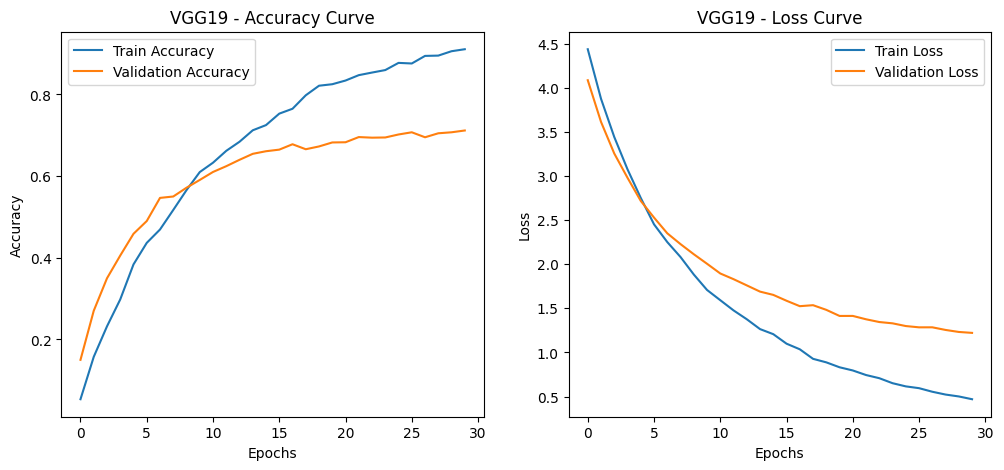

In [25]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    """
    Plots training and validation accuracy/loss curves.
    
    Parameters:
        history: Keras History object after training
        model_name: Name of the model for title
    """
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy Curve")
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()

    plt.show()

# Call function for VGG19
plot_training_history(history_vgg19, "VGG19")

# Call function for YOLOv4-Tiny
#plot_training_history(history_yolo, "YOLOv4-Tiny")


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


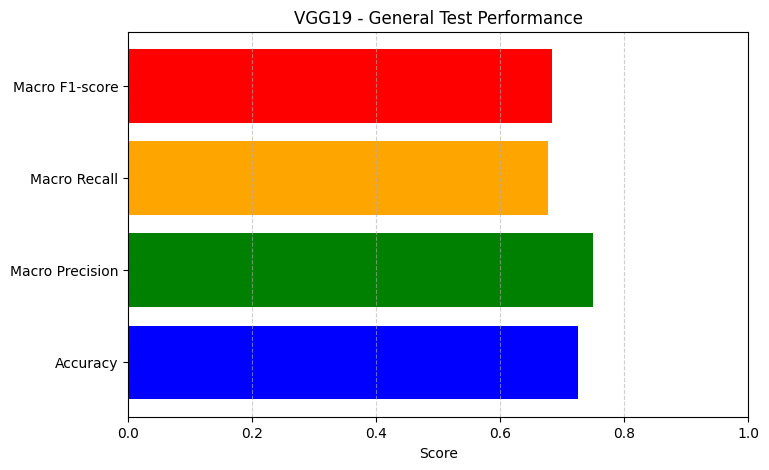

            Metric     Score
0         Accuracy  0.725586
1  Macro Precision  0.749295
2     Macro Recall  0.676326
3   Macro F1-score  0.683001


In [27]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

def summarize_classification_results(y_true, y_pred, model_name):
    """
    Summarizes the overall performance of the model on test data.
    
    Parameters:
        y_true: True labels (one-hot encoded)
        y_pred: Predicted labels (probabilities)
        model_name: Name of the model for the title
    """
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Compute overall accuracy
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    
    # Generate classification report
    report = classification_report(y_true_labels, y_pred_labels, output_dict=True)
    
    # Extract macro-average scores
    macro_avg_precision = report["macro avg"]["precision"]
    macro_avg_recall = report["macro avg"]["recall"]
    macro_avg_f1 = report["macro avg"]["f1-score"]
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1-score"],
        "Score": [accuracy, macro_avg_precision, macro_avg_recall, macro_avg_f1]
    })
    
    # Plot the general statistics
    plt.figure(figsize=(8, 5))
    plt.barh(summary_df["Metric"], summary_df["Score"], color=['blue', 'green', 'orange', 'red'])
    plt.xlim(0, 1)
    plt.xlabel("Score")
    plt.title(f"{model_name} - General Test Performance")
    plt.grid(axis='x', linestyle="--", alpha=0.6)
    
    # Show numerical results
    plt.show()
    print(summary_df)

# Predictions for VGG19
y_pred_vgg19 = vgg19_model.predict(X_test1)

# Summarize classification results for VGG19
summarize_classification_results(y_test1, y_pred_vgg19, "VGG19")


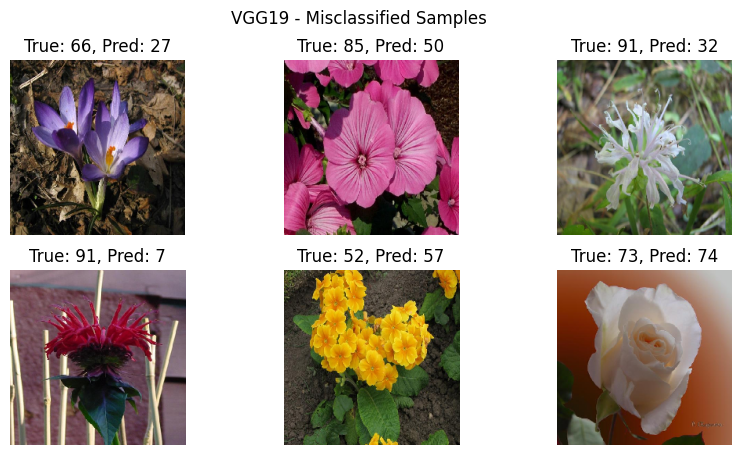

In [28]:
import random

def plot_misclassified_images(X_test, y_true, y_pred, model_name):
    """
    Plots some misclassified images.
    
    Parameters:
        X_test: Test images
        y_true: True labels
        y_pred: Predicted labels
        model_name: Name of the model for title
    """
    y_true_labels = np.argmax(y_true, axis=1)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    misclassified = np.where(y_true_labels != y_pred_labels)[0]
    random_samples = random.sample(list(misclassified), min(6, len(misclassified)))

    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(random_samples):
        plt.subplot(2, 3, i + 1)
        plt.imshow(X_test[idx])
        plt.title(f"True: {y_true_labels[idx]}, Pred: {y_pred_labels[idx]}")
        plt.axis("off")
    
    plt.suptitle(f"{model_name} - Misclassified Samples")
    plt.show()

# Plot misclassified images for VGG19
plot_misclassified_images(X_test1, y_test1, y_pred_vgg19, "VGG19")

# Plot misclassified images for YOLOv4-Tiny
#plot_misclassified_images(X_test2, y_test2, y_pred_yolo, "YOLOv4-Tiny")
